In [1]:
import transformers
from transformers import XLNetTokenizer, XLNetModel, AutoModel, BertTokenizerFast, AdamW

import torch
import torch.nn as nn
from torch.nn import MSELoss
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity, pairwise_distances
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, StandardScaler

from torch.nn import TripletMarginLoss

import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from tqdm import tqdm
from scipy.stats import spearmanr
import mplcursors
import time
import random
import pandas as pd
import numpy as np
import warnings
import re
import json
import networkx as nx
import obonet
from collections import Counter
import collections
import pickle

from pytorch_metric_learning.losses import NTXentLoss





## Section1: Soluibility 

In [2]:
import torch
import random
import numpy as np
import pandas as pd
import gc
from sklearn.metrics import accuracy_score

from src.litgene import FineTunedBERT
from src.utils import process_data
from src.train import trainer

torch.cuda.empty_cache()
gc.collect()



epochs =1
lr = 3e-05
pool ="mean"
max_length = 512
batch_size = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
genes = pd.read_csv("data/combined_solubility.csv")
task_type = "classification"
save_model_path = '/home/tailab/LitGene/models/solubility/'
start_model = "/home/tailab/LitGene/models/checkpoints/litgene_go_0.pth"




if task_type == "classification":
    n_labels = len(set(genes.Label))
elif task_type ==  "regression":
    n_labels = 1
else:
    raise ValueError(f"task_type error:{task_type}")



starting_point_model = FineTunedBERT(pool=pool,
                          model_name=model_name,
                          gene2vec_flag=False,
                          gene2vec_hidden=200,
                          task_type="unsupervised",
                          n_labels=1,
                          device=device).to(device)

starting_point_model.load_state_dict(torch.load(start_model))

train_loader, val_loader, test_loader = process_data(genes, max_length, batch_size,
                                                     test_split_size=0.25,
                                                     val_split_size=0.003,
                                                     model_name=model_name)

print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

sol_model, history, labels_test, best_pred = trainer(
    epochs,
    train_loader=train_loader,
    val_loader=test_loader,
    test_loader=val_loader,
    lr=lr,
    pool=pool,
    max_length=max_length,
    device=device,
    task_type=task_type,
    n_labels=n_labels,
    model_name=model_name,
    load_model=starting_point_model,
    save_model_path=save_model_path
)

test_acc = accuracy_score(labels_test, best_pred)

print(f"Test Accuracy: {test_acc}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


1467
6
491
##########################################################
Currently running Single-Label Classification with n_labels = 2.
##########################################################



/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 1
-------------------------------
Training ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:29<00:00,  1.01it/s]


Validation ...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.76it/s]


Testing ...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.46it/s]


	ET: 35.829 Seconds
Train Loss: 0.58186, Accuracy: 0.663, F1: 0.662, Precision: 0.663, Recall: 0.663
Val Loss: 0.47707, Accuracy: 0.770, F1: 0.770, Precision: 0.770, Recall: 0.770
Test Loss: 0.72349, Accuracy: 0.333, F1: 0.500, Precision: 0.200, Recall: 0.333
Test Accuracy: 0.3333333333333333


### Get embeddings

In [3]:
import pickle

dPathSolubility = '/home/tailab/LitGene/models/solubility/best_model.pth'

# Open the pickle file in binary read mode


with open(dPathSolubility, 'rb') as file:
    # Load the object from the file
    sol_model = torch.load(file,map_location="cuda")

In [4]:
geneDataPath = "/home/tailab/LitGene/data/clean_genes.csv"
all_genes = pd.read_csv(geneDataPath)
all_genes

,Gene name,Summary
0,FES,This gene encodes the human cellular counterpa...
1,HADHA,This gene encodes the alpha subunit of the mit...
2,SLC7A7,The protein encoded by this gene is the light ...
3,LCK,This gene is a member of the Src family of pro...
4,HSPA2,Molecular chaperone implicated in a wide vari...
...,...,...
14445,BPY2C,This gene is located in the nonrecombining por...
14446,CLPS,The protein encoded by this gene is a cofactor...
14447,DNER,Predicted to enable Notch binding activity. In...
14448,SOX7,This gene encodes a member of the SOX (SRYrela...


In [5]:
all_genes[all_genes["Gene name"].isin(["CREBBP "])]

,Gene name,Summary
8475,CREBBP,This gene is ubiquitously expressed and is inv...


In [7]:
geneDataPath = "/home/tailab/LitGene/data/clean_genes.csv"
all_genes = pd.read_csv(geneDataPath)
soluDataPath = "/home/tailab/LitGene/data/sol_embeddings_trian.csv"
training_set = pd.read_csv(soluDataPath).Gene.to_list()
all_genes = all_genes[~all_genes['Gene name'].isin(training_set)]
all_genes

In [134]:
sol_embeddings, sol_preds = getEmbeddings(all_genes["Summary"].to_list(),
                                          batch_size=20,
                                          model = sol_model.module,
                                          return_preds=True)

Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 649/649 [00:59<00:00, 10.86it/s]


(12977, 768)
(12977, 2)


In [136]:
df = pd.DataFrame(sol_embeddings, index=all_genes["Gene name"].to_list())
df.index.name = 'Gene'
df.reset_index(inplace=True)
df.to_csv('/home/tailab/LitGene/outputs/solubility/sol_embeddings_full.csv', index=False)


In [145]:
df_preds = pd.DataFrame({
    'preds': ['Soluble' if pred == 1 else 'Insoluble' for pred in np.argmax(sol_preds, axis=1)]
}, index=all_genes["Gene name"].to_list())

df_preds.index.name = 'Gene'
soluResPath = "/home/tailab/LitGene/outputs/solubility/sol_preds_full.csv"
df_preds.to_csv(soluResPath, index=False)

### Linear eval of GeneLLM

In [102]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Assuming FineTunedBERT and necessary functions are defined/imported

new_model = FineTunedBERT(pool="mean",
                          model_name=model_name,
                          gene2vec_flag=False,
                          gene2vec_hidden=200,
                          task_type="unsupervised",
                          n_labels=1,
                          device="cuda").to(device)

new_model.load_state_dict(torch.load("/home/tailab/LitGene/models/zero-shot/state_dict_0.pth"))

train_splits, test_splits = stratified_k_fold_split(genes, 'Label')

sol_scores_f1_LR = []
sol_scores_acc_LR = []

for train_split, test_split in zip(train_splits, test_splits):
    # Get embeddings
    X_train = getEmbeddings(train_split["Summary"].to_list(), model=new_model,batch_size=50)
    X_test = getEmbeddings(test_split["Summary"].to_list(), model=new_model,batch_size=50)
    
    y_train = train_split["Label"].to_list()
    y_test = test_split["Label"].to_list()
    
    # Train Logistic Regression model
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    # Predict on test set
    y_pred = lr_model.predict(X_test)
    
    # Calculate scores
    sol_scores_f1_LR.append(f1_score(y_test, y_pred))
    sol_scores_acc_LR.append(accuracy_score(y_test, y_pred))

# Optionally, print or return the results
print(f'F1 Scores: {sol_scores_f1_LR}')
print(f'Accuracy Scores: {sol_scores_acc_LR}')


Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.05it/s]


torch.Size([1571, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.66it/s]


torch.Size([393, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.05it/s]


torch.Size([1571, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.65it/s]


torch.Size([393, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.04it/s]


torch.Size([1571, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.62it/s]


torch.Size([393, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.02it/s]


torch.Size([1571, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.60it/s]


torch.Size([393, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:06<00:00,  5.00it/s]


torch.Size([1572, 768])
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


torch.Size([392, 768])
F1 Scores: [0.7911547911547911, 0.7614213197969544, 0.7549019607843137, 0.7609756097560977, 0.7788944723618091]
Accuracy Scores: [0.7837150127226463, 0.7608142493638677, 0.7455470737913485, 0.7506361323155216, 0.7755102040816326]


In [146]:
df_preds

,preds
Gene,
HADHA,Insoluble
SLC7A7,Insoluble
LCK,Soluble
ZSCAN9,Insoluble
SNX10,Soluble
...,...
BPY2C,Soluble
CLPS,Soluble
DNER,Insoluble


In [ ]:
# df = pd.DataFrame(sol_preds, index=all_genes["Gene name"].to_list())
# df.index.name = 'Gene'
# df.reset_index(inplace=True)
# df.to_csv('solubility/sol_embeddings_full.csv', index=False)


In [104]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer

train_splits, test_splits = stratified_k_fold_split(genes, 'Label')

f1_scores_LR_CV = []
accuracy_scores_LR_CV = []

vectorizer = CountVectorizer()

for train_split, test_split in zip(train_splits, test_splits):
    X_train = vectorizer.fit_transform(train_split["Summary"].to_list()).toarray()
    X_test = vectorizer.transform(test_split["Summary"].to_list()).toarray()
    
    y_train = train_split["Label"].to_list()
    y_test = test_split["Label"].to_list()
    
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    3
    y_pred = lr_model.predict(X_test)
    
    f1_scores_LR_CV.append(f1_score(y_test, y_pred))
    accuracy_scores_LR_CV.append(accuracy_score(y_test, y_pred))

print(f'Accuracy : {accuracy_scores_LR_CV}')
print(f'F1 : {f1_scores_LR_CV}')


Accuracy : [0.8142493638676844, 0.7888040712468194, 0.7837150127226463, 0.7684478371501272, 0.7525510204081632]
F1 : [0.819753086419753, 0.7877237851662405, 0.7911547911547911, 0.7817745803357314, 0.762836185819071]


In [105]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer

train_splits, test_splits = stratified_k_fold_split(genes, 'Label')

f1_scores_LR_TF = []
accuracy_scores_LR_TF = []

vectorizer = TfidfVectorizer()

for train_split, test_split in zip(train_splits, test_splits):
    X_train = vectorizer.fit_transform(train_split["Summary"].to_list()).toarray()
    X_test = vectorizer.transform(test_split["Summary"].to_list()).toarray()
    
    y_train = train_split["Label"].to_list()
    y_test = test_split["Label"].to_list()
    
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)
    
    y_pred = lr_model.predict(X_test)
    
    f1_scores_LR_TF.append(f1_score(y_test, y_pred))
    accuracy_scores_LR_TF.append(accuracy_score(y_test, y_pred))

print(f'Accuracy: {accuracy_scores_LR_TF}')
print(f'F1 Scores: {f1_scores_LR_TF}')


Accuracy: [0.7989821882951654, 0.7913486005089059, 0.7735368956743003, 0.7430025445292621, 0.7831632653061225]
F1 Scores: [0.8087167070217918, 0.8, 0.7855421686746988, 0.7530562347188263, 0.7951807228915663]


### Well/Less-studied genes: Bias Analysis

In [333]:
def split_and_truncate_summaries(df, trunc_length=10):
    # Split the data into train and test sets
    train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['Label'], random_state=42)

    # Retrieve summaries that are already shorter than the trunc_length
    short_summaries_df = test_df[test_df['Summary'].apply(lambda x: len(x.split()) < trunc_length)]
    
    # Sample from the remaining summaries
    remaining_df = test_df.drop(short_summaries_df.index)
    trunc_df = remaining_df.sample(frac=0.5, random_state=42)
    well_studied_df = remaining_df.drop(trunc_df.index)

    # Truncate the summaries by number of words for the sampled trunc_df
    trunc_df['Summary'] = trunc_df['Summary'].apply(lambda x: ' '.join(x.split()[:trunc_length]))

    # Label the truncated and non-truncated summaries using .loc to avoid SettingWithCopyWarning
    short_summaries_df.loc[:, 'Category'] = 'Less-studied'
    trunc_df.loc[:, 'Category'] = 'Less-studied'
    well_studied_df.loc[:, 'Category'] = 'Well-studied'

    # Combine the dataframes
    final_test_df = pd.concat([short_summaries_df, trunc_df, well_studied_df]).reset_index(drop=True)

    return train_df, final_test_df


train_df, test_df = split_and_truncate_summaries(genes, trunc_length = 10)
test_df[test_df.Category == "Less-studied"].Label.value_counts() ,\
test_df[test_df.Category == "Well-studied"].Label.value_counts()

(Label
 1    151
 0    144
 Name: count, dtype: int64,
 Label
 1    149
 0    146
 Name: count, dtype: int64)

#### GeneLLM-CL

In [334]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split

# Assuming FineTunedBERT and necessary functions are defined/imported

# Define the model
new_model = FineTunedBERT(pool="mean",
                          model_name=model_name,
                          gene2vec_flag=False,
                          gene2vec_hidden=200,
                          task_type="unsupervised",
                          n_labels=1,
                          device="cuda").to(device)


new_model.load_state_dict(torch.load("/home/tailab/LitGene/models/zero-shot/state_dict_0.pth"))


# Get embeddings for training data
X_train = getEmbeddings(train_df["Summary"].tolist(), model=new_model, batch_size=50)
y_train = train_df["Label"].tolist()

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

results_wo_ft = {
    'Well-studied': {'F1': [], 'Accuracy': []},
    'Less-studied': {'F1': [], 'Accuracy': []}
}

for category in ['Well-studied', 'Less-studied']:
    test_category_genes = test_df[test_df['Category'] == category]
    
    if test_category_genes.empty:
        print(f"No genes found for category {category} in the test set, skipping.")
        break

    # Get embeddings for test data
    X_test = getEmbeddings(test_category_genes["Summary"].tolist(), model=new_model, batch_size=50)
    y_test = test_category_genes["Label"].tolist()
    
    y_pred = lr_model.predict(X_test)
    
    results_wo_ft[category]['F1'].append(round(f1_score(y_test, y_pred), 3))
    results_wo_ft[category]['Accuracy'].append(round(accuracy_score(y_test, y_pred), 3))

for category in results:
    print(f"{category} - F1: {results_wo_ft[category]['F1']}, Accuracy: {results_wo_ft[category]['Accuracy']}")


Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.12it/s]


(1374, 768)
(1374, 1)
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.04it/s]


(295, 768)
(295, 1)
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00,  6.05it/s]

(295, 768)
(295, 1)
Well-studied - F1: [0.755], Accuracy: [0.763]
Less-studied - F1: [0.649], Accuracy: [0.644]


#### GeneLLM-CL Finetuned

In [335]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

epochs = 6
lr = 3e-05
pool = "mean"
max_length = 512
batch_size = 50
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

new_model = FineTunedBERT(pool=pool,
                          model_name=model_name,
                          gene2vec_flag=False,
                          gene2vec_hidden=200,
                          task_type="unsupervised",
                          n_labels=1,
                          device=device).to(device)

new_model.load_state_dict(torch.load("/home/tailab/LitGene/models/zero-shot/state_dict_0.pth"))

train_loader, val_loader, test_loader = process_data(genes,
                                                     max_length,
                                                     batch_size,
                                                     test_genes=test_df["Gene name"].to_list(),
                                                     val_split_size=0,
                                                     model_name=model_name)

sol_model, history, labels_test, best_pred = trainer(
    epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=lr,
    pool=pool,
    max_length=max_length,
    device=device,
    task_type="classification",
    n_labels=2,
    model_name=model_name,
    load_model=new_model,
    save_model_path="/home/tailab/LitGene/models/solubility/"
)

results_w_ft = {
    'Well-studied': {'F1': [], 'Accuracy': []},
    'Less-studied': {'F1': [], 'Accuracy': []}
}

for category in ['Well-studied', 'Less-studied']:
    test_category_genes = test_df[test_df['Category'] == category]
    
    if test_category_genes.empty:
        print(f"No genes found for category {category} in the test set, skipping.")
        continue

    # Get embeddings for test data
    _, y_pred = getEmbeddings(test_category_genes["Summary"].tolist(), model=sol_model.module, batch_size=50, return_preds=True)
    y_test = test_category_genes["Label"].tolist()
    
    y_pred = np.argmax(y_pred, axis=1)
    
    results_w_ft[category]['F1'].append(round(f1_score(y_test, y_pred), 3))
    results_w_ft[category]['Accuracy'].append(round(accuracy_score(y_test, y_pred), 3))

for category in results:
    print(f"{category} - F1: {results_w_ft[category]['F1']}, Accuracy: {results_w_ft[category]['Accuracy']}")


Shape of tokens_df before gene2vec:(1964, 6)
Shape of tokens_df after gene2vec:(1964, 6)
##########################################################
Currently running Single-Label Classification with n_labels = 2.
##########################################################



/home/alaj/.conda/envs/deepV_a100/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.39it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.48it/s]


	ET: 6.624 Seconds
Train Loss: 0.72816, Accuracy: 0.517, F1: 0.512, Precision: 0.519, Recall: 0.517
Test Loss: 0.56739, Accuracy: 0.690, F1: 0.686, Precision: 0.698, Recall: 0.690
Epoch 2 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.37it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.46it/s]


	ET: 6.650 Seconds
Train Loss: 0.55242, Accuracy: 0.728, F1: 0.727, Precision: 0.729, Recall: 0.728
Test Loss: 0.48410, Accuracy: 0.753, F1: 0.751, Precision: 0.757, Recall: 0.753
Epoch 3 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.35it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.39it/s]


	ET: 6.682 Seconds
Train Loss: 0.46376, Accuracy: 0.786, F1: 0.785, Precision: 0.790, Recall: 0.786
Test Loss: 0.44927, Accuracy: 0.768, F1: 0.767, Precision: 0.772, Recall: 0.768
Epoch 4 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.30it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.41it/s]


	ET: 6.722 Seconds
Train Loss: 0.40322, Accuracy: 0.811, F1: 0.810, Precision: 0.814, Recall: 0.811
Test Loss: 0.44182, Accuracy: 0.790, F1: 0.789, Precision: 0.791, Recall: 0.790
Epoch 5 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.29it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.36it/s]


	ET: 6.740 Seconds
Train Loss: 0.34732, Accuracy: 0.840, F1: 0.839, Precision: 0.843, Recall: 0.840
Test Loss: 0.43563, Accuracy: 0.807, F1: 0.807, Precision: 0.808, Recall: 0.807
Epoch 6 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:05<00:00,  5.26it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.26it/s]


	ET: 6.788 Seconds
Train Loss: 0.28133, Accuracy: 0.875, F1: 0.875, Precision: 0.876, Recall: 0.875
Test Loss: 0.46529, Accuracy: 0.808, F1: 0.808, Precision: 0.810, Recall: 0.808
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.89it/s]


(295, 768)
(295, 2)
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.93it/s]

(295, 768)
(295, 2)
Well-studied - F1: [0.852], Accuracy: [0.841]
Less-studied - F1: [0.719], Accuracy: [0.658]


#### Gene2Vec

In [336]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split


###########Train##############
Gene2Vec = dict()

file_path = f'embeddings/gene2vec/gene2vec_embeddings.txt'
with open(file_path, 'r') as file:
    for line in file:
        name, embed = line.strip().split("\t")
        embed = [float(value) for value in embed.split()]
        Gene2Vec[name.strip()] = embed
###########Train##############

X_train, y_train = [],[]
for g, l in zip(train_df["Gene name"], train_df["Label"]):
    if g in Gene2Vec.keys():
        X_train += [Gene2Vec[g]]
        y_train += [l]

X_train = np.array(X_train)
y_train = np.array(y_train)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

results_gv = {
    'Well-studied': {'F1': [], 'Accuracy': []},
    'Less-studied': {'F1': [], 'Accuracy': []}
}

for category in ['Well-studied', 'Less-studied']:
    test_category_genes = test_df[test_df['Category'] == category]
    
    if test_category_genes.empty:
        print(f"No genes found for category {category} in the test set, skipping.")
        break

    X_test, y_test = [],[]
    # Get embeddings for test data
    for g, l in zip(test_category_genes["Gene name"], test_category_genes["Label"]):
        if g in Gene2Vec.keys():
            X_test += [Gene2Vec[g]]
            y_test += [l]

    X_test = np.array(X_test)
    y_test = np.array(y_test)

    y_pred = lr_model.predict(X_test)

    results_gv[category]['F1'].append(round(f1_score(y_test, y_pred), 3))
    results_gv[category]['Accuracy'].append(round(accuracy_score(y_test, y_pred), 3))
    
print("Gene2Vec:")
for category in results:
    print(f"{category} - F1: {results_gv[category]['F1']}, Accuracy: {results_gv[category]['Accuracy']}")


Gene2Vec:
Well-studied - F1: [0.587], Accuracy: [0.579]
Less-studied - F1: [0.599], Accuracy: [0.582]


#### Gene2Vec + GeneLLM

In [385]:
import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd

epochs = 6
lr = 3e-05
pool = "mean"
max_length = 512
batch_size = 50
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

new_model = FineTunedBERT(pool=pool,
                          model_name=model_name,
                          gene2vec_flag=False,
                          gene2vec_hidden=200,
                          task_type="unsupervised",
                          n_labels=1,
                          device=device).to(device)

new_model.load_state_dict(torch.load("/home/tailab/LitGene/models/zero-shot/state_dict_0.pth"))

train_loader, val_loader, test_loader = process_data(genes,
                                                     max_length,
                                                     batch_size,
                                                     test_genes=test_df["Gene name"].to_list(),
                                                     val_split_size=0,
                                                     gene2vec_flag=True,
                                                     model_name=model_name)

sol_model, history, labels_test, best_pred = trainer(
    epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    lr=lr,
    pool=pool,
    max_length=max_length,
    device=device,
    task_type="classification",
    n_labels=2,
    model_name=model_name,
    load_model=new_model,
    gene2vec_flag =True,
    gene2vec_hidden=200,
    save_model_path="/home/tailab/LitGene/models/solubility/"
)


results_gv_gl = {
    'Well-studied': {'F1': [], 'Accuracy': []},
    'Less-studied': {'F1': [], 'Accuracy': []}
}

index_gene_dict = dict(zip(genes.index, genes['Gene name']))
studied_dict = dict(zip(test_df['Gene name'],test_df.Category))


_, y_pred = getEmbeddingsWithGene2Vec(test_loader, model=sol_model.module, return_preds=True)
y_pred = np.argmax(y_pred, axis=1)
y_test = [int(test_loader.dataset[i][3]) for i in range(len(test_loader.dataset))]
y_studied = [studied_dict[index_gene_dict[int(test_loader.dataset[i][4])]] 
             for i in range(len(test_loader.dataset))]

for category in ['Well-studied', 'Less-studied']:
    cat_y_test , cat_y_pred = [],[]
    
    for i,item in enumerate(y_studied):
        if item == category:
            cat_y_test.append(y_test[i])
            cat_y_pred.append(int(y_pred[i]))
            
    results_gv_gl[category]['F1'].append(round(f1_score(cat_y_test, cat_y_pred), 3))
    results_gv_gl[category]['Accuracy'].append(round(accuracy_score(cat_y_test, cat_y_pred), 3))

for category in results:
    print(f"{category} - F1: {results_gv_gl[category]['F1']}, Accuracy: {results_w_ft[category]['Accuracy']}")


Shape of tokens_df before gene2vec:(1964, 6)
Adding Gene2Vec data ...
Shape of tokens_df after gene2vec:(1832, 7)
##########################################################
Currently running Single-Label Classification with n_labels = 2.
##########################################################



/home/alaj/.conda/envs/deepV_a100/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.30it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  9.01it/s]


	ET: 6.255 Seconds
Train Loss: 0.69428, Accuracy: 0.492, F1: 0.466, Precision: 0.495, Recall: 0.492
Test Loss: 0.66587, Accuracy: 0.689, F1: 0.687, Precision: 0.698, Recall: 0.689
Epoch 2 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.39it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.96it/s]


	ET: 6.172 Seconds
Train Loss: 0.65358, Accuracy: 0.722, F1: 0.721, Precision: 0.722, Recall: 0.722
Test Loss: 0.58496, Accuracy: 0.763, F1: 0.763, Precision: 0.764, Recall: 0.763
Epoch 3 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.37it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.92it/s]


	ET: 6.200 Seconds
Train Loss: 0.55916, Accuracy: 0.764, F1: 0.763, Precision: 0.768, Recall: 0.764
Test Loss: 0.48129, Accuracy: 0.756, F1: 0.754, Precision: 0.762, Recall: 0.756
Epoch 4 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:05<00:00,  4.45it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.93it/s]


	ET: 7.196 Seconds
Train Loss: 0.47728, Accuracy: 0.787, F1: 0.785, Precision: 0.792, Recall: 0.787
Test Loss: 0.45299, Accuracy: 0.767, F1: 0.764, Precision: 0.775, Recall: 0.767
Epoch 5 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.33it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.90it/s]


	ET: 6.238 Seconds
Train Loss: 0.43272, Accuracy: 0.808, F1: 0.807, Precision: 0.813, Recall: 0.808
Test Loss: 0.42823, Accuracy: 0.796, F1: 0.794, Precision: 0.801, Recall: 0.796
Epoch 6 of 6
-------------------------------
Training ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:04<00:00,  5.28it/s]


Testing ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00,  8.74it/s]

	ET: 6.311 Seconds
Train Loss: 0.39309, Accuracy: 0.829, F1: 0.828, Precision: 0.832, Recall: 0.829
Test Loss: 0.46151, Accuracy: 0.787, F1: 0.787, Precision: 0.787, Recall: 0.787


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:02<00:00,  5.45it/s]

(553, 768)
(553, 2)
{0, 1} {0, 1}
{0, 1} {0, 1}
Well-studied - F1: [0.83], Accuracy: [0.841]
Less-studied - F1: [0.754], Accuracy: [0.658]


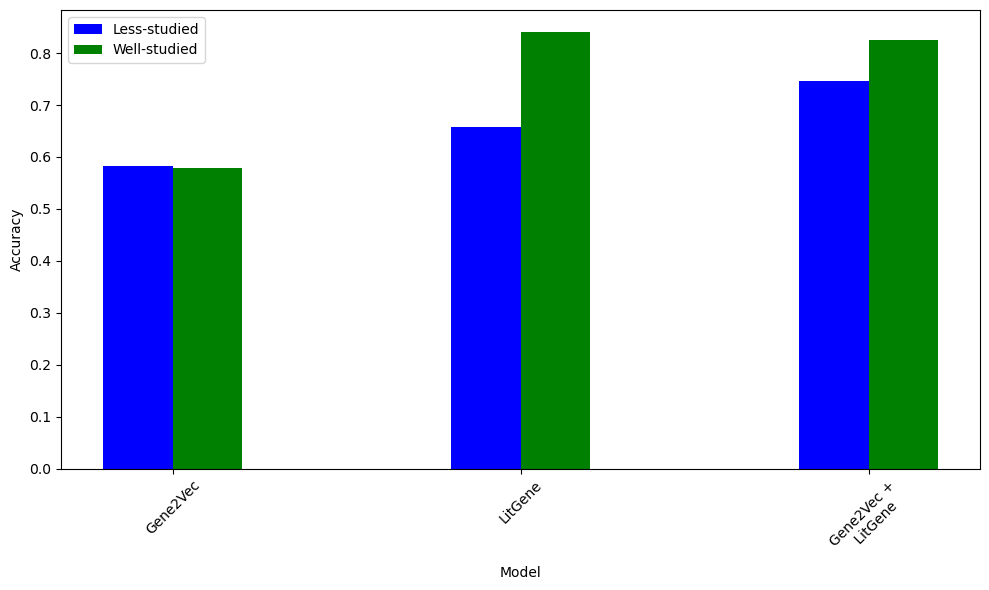

In [417]:
def plot_combined_accuracy(results_gv, results_wo_ft, results_w_ft, results_gv_gl, save_path, w_ft=True):
#     if w_ft: 
#         models = ['Gene2Vec', 'LitGene w/o\n Finetuning', 'LitGene', "Gene2Vec +\n LitGene"]
#     else:
    models = ['Gene2Vec', 'LitGene', "Gene2Vec +\n LitGene"]
    
    less_studied_accuracies = [
        results_gv['Less-studied']['Accuracy'][0],
#         results_wo_ft['Less-studied']['Accuracy'][0],
        results_w_ft['Less-studied']['Accuracy'][0],
        results_gv_gl['Less-studied']['Accuracy'][0]
    ]
    
    well_studied_accuracies = [
        results_gv['Well-studied']['Accuracy'][0],
#         results_wo_ft['Well-studied']['Accuracy'][0],
        results_w_ft['Well-studied']['Accuracy'][0],
        results_gv_gl['Well-studied']['Accuracy'][0]
    ]
    
    x = range(len(models))
    
    plt.figure(figsize=(10, 6))
    plt.bar([i - 0.1 for i in x], less_studied_accuracies, width=0.2, label='Less-studied', color='blue')
    plt.bar([i + 0.1 for i in x], well_studied_accuracies, width=0.2, label='Well-studied', color='green')
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
#     plt.title('10 summary length')
    plt.xticks(x, models, rotation=45)
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(save_path)
    plt.show()

save_path = "/home/tailab/LitGene/outputs/solubility/bias/10_updated.pdf"
plot_combined_accuracy(results_gv, results_wo_ft, results_w_ft, results_gv_gl, save_path, w_ft=True)


In [418]:
file_path = '/home/tailab/LitGene/data/embeddings/PMC-LLaMA/PMC_LLaMA_13B_embeddings.pt'


llama_embeddings = torch.load(file_path)

In [420]:
llama_embeddings.shape

torch.Size([14516, 5120])

In [8]:
import pickle

# Open the pickle file in binary read mode
with open('/home/tailab/LitGene/models/solubility/best_model.pth', 'rb') as file:
    # Load the object from the file
    sol_model = torch.load(file,map_location = 'cuda')


FileNotFoundError: [Errno 2] No such file or directory: '/home/tailab/LitGene/solubility/best_model.pkl'

In [ ]:
sol_embeddings = getEmbeddings(genes["Summary"].to_list(), model = sol_model.module)
sol_embeddings

In [ ]:
gene_embeddings_solubility = {g:emb.tolist() for g,emb in zip(genes["Gene name"], sol_embeddings)}
gene_embeddings_solubility

## Zero Shot Learning: Go-Terms

In [5]:
import pandas as pd
from itertools import product
import random

def find_siblings(G, target_node):

    parents = {node for node, child in G.edges() if child == target_node}

    siblings = set()
    for parent in parents:
        siblings.update({child for _, child in G.edges() if _ == parent})

    siblings.discard(target_node)
    
    return siblings


def go_terms_triplets_all_levels(held_out_size=3000):
    
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    
    
    go_terms_df = pd.read_csv('data/GO/mart_export.txt', delimiter=",")
    go_terms_df = go_terms_df[go_terms_df['Gene name'].isin(genes["Gene name"].to_list())].dropna()
    go_terms_df = go_terms_df[["Gene name", "GO term accession"]].drop_duplicates(keep='first').reset_index(drop=True)
    go_terms_df = go_terms_df.rename(columns = {"GO term accession": "GO Term"})
    
    
    list_of_gos = list(set(go_terms_df["GO Term"].to_list()))
    
    #hold 3000 go terms for zero shot learning
    while True:

        held_out = random.sample(list_of_gos, held_out_size)
        held_out_df = go_terms_df[go_terms_df['GO Term'].isin(held_out)]

        if int(len(go_terms_df)*0.2) < len(held_out_df) and len(held_out_df) < int(len(go_terms_df)*0.3):
            break

    
    go_terms_df = go_terms_df[~go_terms_df['GO Term'].isin(held_out)]
    r = len(set(go_terms_df["GO Term"]))
    print(f"Remaining unique GO Terms:{r} / {len(list_of_gos)}")
    
    
    # Performing triplet dataset
    go_to_summary = dict()
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
    GO_graph = obonet.read_obo("/home/tailab/LitGene/data/GO/go-basic.obo")

    for go_term in list_of_gos:
        
        if  GO_graph.nodes.get(go_term, False):
            go_to_summary[go_term] = re.findall(r'"(.*?)"', GO_graph.nodes[go_term]["def"])[0]
        else:
            go_to_summary[go_term] = None
    

    
    universe = set(go_terms_df["GO Term"])

    anchor_list=[]
    positive_list = []
    negative_list = []

    
    genes_to_go_terms = go_terms_df.groupby('Gene name')['GO Term'].apply(set).to_dict()
    for g in tqdm(genes_to_go_terms.keys()):


        positive_terms = genes_to_go_terms[g]
#         negative_terms = universe - positive_terms 

        #getting hard negatives only:
        negative_terms = set()
        for term in positive_terms:
            negative_terms |= find_siblings(GO_graph, term)
        
        #Make sure GO terms in list_of_go
        negative_terms &= set(list_of_gos)
        
        #Make sure it's not in positive
        negative_terms -= positive_terms
        
        #Make sure it's not in held_out
        negative_terms -= set(held_out)
        
        
#         unique = {(i, j) for i, j in product(positive_terms, negative_terms)}
        
        #for one gene as anchor
        collect =[[],[],[]]
        for pt, nt in product(positive_terms, negative_terms):
            collect[0].append(g)
            collect[1].append(pt)
            collect[2].append(nt)
        
        
        anchor_list.extend(collect[0])
        
        positive_list.extend(collect[1])
        
        negative_list.extend(collect[2])
        
    print(len(anchor_list), len(positive_list), len(negative_list))        
    triplet_data ={
        "Gene name":anchor_list,
        "Anchor": [gene_to_summary[g] for g in anchor_list],
        
        "Positive":[go_to_summary[t] for t in positive_list ],
        "PositiveTerm":positive_list,
        
        "Negative":[go_to_summary[t] for t in negative_list ],
        "NegativeTerm":negative_list}
    
    triplet_df = pd.DataFrame(triplet_data).dropna().sample(frac=1).reset_index(drop=True)
    
    
    return triplet_df, held_out_df

In [34]:
go_triplet_df, held_out_df = go_terms_triplets_all_levels()


Remaining unique GO Terms:15479 / 18479


 26%|███████████████████████▊                                                                     | 3665/14325 [11:04:09<23:16:05,  7.86s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 14325/14325 [38:04:22<00:00,  9.57s/it]


33708884 33708884 33708884


In [72]:
go_triplet_df

,Gene name,Anchor,Positive,PositiveTerm,Negative,NegativeTerm
0,PRKCZ,alcium and diacylglycerolindependent serine/t...,Any process that activates or increases the fr...,GO:0051222,Any process that modulates the activity of a c...,GO:0043281
1,MAPK3,The protein encoded by this gene is a member o...,The selective autophagy process in which a reg...,GO:0098792,The series of molecular signals which triggers...,GO:0097190
2,TNKS,Enables histone binding activity; pentosyltran...,Any process in which a protein is transported ...,GO:0070198,A vesicle-mediated transport process in which ...,GO:0006897
3,EP300,This gene encodes the adenovirus E1Aassociated...,Any process that activates or increases the fr...,GO:0032092,"Any process that stops, prevents or reduces th...",GO:1902254
4,SOX9,This region contains an enhancer that is thoug...,"The aggregation, arrangement and bonding toget...",GO:0065003,Any process that activates or increases the fr...,GO:0051152
...,...,...,...,...,...,...
33583581,STMN1,This gene belongs to the stathmin family of ge...,"Any process that stops, prevents, or reduces t...",GO:0051497,"Any process that modulates the frequency, rate...",GO:1902531
33583582,SFRP2,This gene encodes a member of the SFRP family ...,"Any process that increases the rate, frequency...",GO:0090263,The process whose specific outcome is the prog...,GO:0035050
33583583,SIRT1,This gene encodes a member of the sirtuin fami...,"Any process that modulates the rate, frequency...",GO:0010906,"Any process that modulates the frequency, rate...",GO:0010468
33583584,HES1,This protein belongs to the basic helixloophel...,A membrane-bounded organelle of eukaryotic cel...,GO:0005634,The extension of an RNA molecule after transcr...,GO:0006354


In [193]:
import ast

held_out_terms = {t:False for t in set(held_out_df["GO Term"])}
def filter_held_out(row):
    
    result1 = []
    result2 = []
    for t1,t2 in zip(row["PositiveTerm"], row["NegativeTerm"]) :
        
        if held_out_terms.get(t1, True):
            if held_out_terms.get(t2, True):
                result1.append(t1)
                result2.append(t2)

    return pd.Series([result1, result2])

df = pd.read_csv("data/GO/compact_triplet_df_hard_negatives.csv")
df['PositiveTerm'] = df['PositiveTerm'].apply(ast.literal_eval)
df['NegativeTerm'] = df['NegativeTerm'].apply(ast.literal_eval)
df[['PositiveTerm', 'NegativeTerm']] = df.apply(filter_held_out, axis=1)
df = df[df['PositiveTerm'].map(bool) | df['NegativeTerm'].map(bool)]
df

,Gene name,PositiveTerm,NegativeTerm
0,A1CF,"[GO:0005783, GO:0006397, GO:0007566, GO:190153...","[GO:0003823, GO:0071813, GO:0003725, GO:000152..."
1,A2M,"[GO:0005102, GO:0004866, GO:0002020, GO:000155...","[GO:0002863, GO:0002067, GO:1905049, GO:003299..."
2,A2ML1,"[GO:0005615, GO:0004866, GO:0030414, GO:000557...","[GO:0043226, GO:0110165, GO:0019814, GO:004303..."
3,A4GALT,"[GO:0008378, GO:0006629, GO:0006688, GO:001602...","[GO:0007338, GO:0018208, GO:0060049, GO:009858..."
4,A4GNT,"[GO:0006493, GO:0008375, GO:0050680, GO:000649...","[GO:0033599, GO:0072574, GO:0036211, GO:006005..."
...,...,...,...
14302,ZXDB,"[GO:0005634, GO:0005634, GO:0003674, GO:004687...","[GO:0005874, GO:0050840, GO:0032991, GO:001623..."
14303,ZYG11B,"[GO:0005515, GO:0005515, GO:0032436, GO:000651...","[GO:1904294, GO:0042562, GO:0031145, GO:190578..."
14304,ZYX,"[GO:0007155, GO:0005856, GO:0001725, GO:007016...","[GO:0097367, GO:0060762, GO:0097367, GO:009010..."
14305,ZZEF1,"[GO:0140566, GO:0005515, GO:0006325, GO:000550...","[GO:0065004, GO:0007000, GO:0042562, GO:000728..."


In [42]:
import ast
from torch.nn.utils.rnn import pad_sequence

def tokenize_GO_data(df_triplet, anchor_max_length=512, triplet_max_length=250,
                     batch_size=100, model_name= "bert-base-cased",
                     test_split_size=0.15):
    
    with open('/home/tailab/LitGene/data/GO/intGO_to_summary.json', 'r') as file:
        intGO_to_summary = json.load(file)
    
    with open('/home/tailab/LitGene/data/GO/strGO_to_intGO.json', 'r') as file:
        strGO_to_intGO = json.load(file)
    
    gene_to_summary = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv").set_index('Gene name').to_dict()['Summary']
    df_triplet["Anchor"] = df_triplet["Gene name"].apply(lambda g: gene_to_summary[g])
    df_triplet['PositiveTerm'] = df_triplet['PositiveTerm'].apply(ast.literal_eval)
    df_triplet['NegativeTerm'] = df_triplet['NegativeTerm'].apply(ast.literal_eval)
    df_triplet['PositiveTermInt'] = df_triplet['PositiveTerm'].apply(lambda l: [strGO_to_intGO[t] for t in l ])
    df_triplet['NegativeTermInt'] = df_triplet['NegativeTerm'].apply(lambda l: [strGO_to_intGO[t] for t in l ])
    
    anchor = df_triplet["Anchor"].tolist()
    positive = df_triplet['PositiveTermInt'].tolist()
    positive = pad_sequence([torch.tensor(p) for p in positive], batch_first=True, padding_value=-1).tolist()
    negative = df_triplet['NegativeTermInt'].tolist()
    negative = pad_sequence([torch.tensor(n) for n in negative], batch_first=True, padding_value=-1).tolist()
    GO_summary = list(intGO_to_summary.values())
    
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    tokens_a = tokenizer.batch_encode_plus(anchor, max_length = anchor_max_length,
                                           padding="max_length", truncation=True)
    tokens_go = tokenizer.batch_encode_plus(GO_summary, max_length = triplet_max_length,
                                            padding="max_length", truncation=True, return_tensors="pt")
    
    
#     print(len(positive), len(positive[0]) )
#     print(len(negative), len(negative[0]) )
    
#     print(len(tokens_a["input_ids"]), len(tokens_a["input_ids"][0]) )
#     print(len(tokens_a["attention_mask"]), len(tokens_a["attention_mask"][0]) )
    
    data = {
        'input_ids': tokens_a["input_ids"],
        'attention_mask': tokens_a["attention_mask"],
        'positive':positive,
        'negative': negative}
        
    tokens_df = pd.DataFrame(data)

    train_tokens, val_tokens = train_test_split(tokens_df, test_size=test_split_size,
                                                 random_state=1)

#     test_tokens, val_tokens = train_test_split(test_tokens,test_size=0.5,
#                                                random_state=1)

    train_tokens = train_tokens.reset_index(drop=True)
    val_tokens = val_tokens.reset_index(drop=True)
#     test_tokens = test_tokens.reset_index(drop=True)


    train_dataset = TensorDataset(
        torch.tensor(train_tokens["input_ids"].tolist()),
        torch.tensor(train_tokens["attention_mask"].tolist()),
        torch.tensor(train_tokens["positive"]),
        torch.tensor(train_tokens["negative"]))

    val_dataset = TensorDataset(
        torch.tensor(val_tokens["input_ids"].tolist()) ,
        torch.tensor(val_tokens["attention_mask"].tolist()),        
        torch.tensor(val_tokens["positive"].tolist()) ,
        torch.tensor(val_tokens["negative"].tolist()))

    print(len(train_dataset), len(val_dataset))
#     test_dataset = TensorDataset(
#         torch.tensor(test_tokens["input_ids"].tolist()),
#         torch.tensor(test_tokens["attention_mask"].tolist()),
#         torch.tensor(test_tokens["positive"].tolist()),
#         torch.tensor(test_tokens["negative"].tolist()))

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#     test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    
    return train_dataset, val_dataset, tokens_go


### Runing GeneLLM

In [43]:
import gc
torch.cuda.empty_cache()
gc.collect()


temperature = 0.1
epochs =5
lr = 2e-5
pool ="mean"
anchor_max_length = 512
triplet_max_length=250
batch_size =1
go_batch_size = 400
drop_rate = 0.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"


df = pd.read_csv("/home/tailab/LitGene/data/GO/compact_triplet_df_hard_negatives_without_heldout.csv")

    
train_dataset, val_dataset, tokens_go = tokenize_GO_data(df, anchor_max_length=anchor_max_length,
                                                       triplet_max_length=triplet_max_length,
                                                       batch_size=batch_size,
                                                       model_name= model_name,
                                                       test_split_size=0.15)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


CL_Trainer(
    train_loader, val_loader, tokens_go,
    epochs =epochs,
    lr = lr, pool = pool,
    model_name= model_name,
    device = device,
    batch_size =batch_size,
    go_batch_size =go_batch_size,
    temperature = temperature,
    save_model_path = "/home/tailab/LitGene/models/zero-shot/GO_33M/")

12148 2144


/home/alaj/.conda/envs/deepV_a100/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 of 5
-------------------------------
Training ...


3027it [5:07:43, 11.95s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

6316it [10:38:32,  3.82s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2144it [2:13:40,  3.74s/it]


Best Model was Found at epoch 0.
	ET: 78942.981 Seconds
Train Loss: 2.85091
Val Loss: 2.77283
Epoch 2 of 5
-------------------------------
Training ...


6079it [10:15:08,  6.56s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

5462it [9:28:44,  5.03s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2144it [2:11:08,  3.67s/it]


Best Model was Found at epoch 2.
	ET: 80965.710 Seconds
Train Loss: 1.78516
Val Loss: 2.42459
Epoch 4 of 5
-------------------------------
Training ...


3904it [6:32:51,  3.40s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

5089it [8:28:36, 10.79s/it] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [221]:
df

,Gene name,PositiveTerm,NegativeTerm,Anchor,PositiveTermInt,NegativeTermInt
0,A1CF,"[GO:0005783, GO:0006397, GO:0007566, GO:190153...","[GO:0003823, GO:0071813, GO:0003725, GO:000152...",Mammalian apolipoprotein B mRNA undergoes site...,"[14033, 5015, 11300, 5339, 2440, 11300, 8959, ...","[5159, 2765, 11116, 237, 237, 9660, 5159, 1065..."
1,A2M,"[GO:0005102, GO:0004866, GO:0002020, GO:000155...","[GO:0002863, GO:0002067, GO:1905049, GO:003299...",The protein encoded by this gene is a protease...,"[8999, 13879, 9691, 13650, 13505, 3327, 5336, ...","[1808, 12551, 7826, 13503, 11910, 14604, 13011..."
2,A2ML1,"[GO:0005615, GO:0004866, GO:0030414, GO:000557...","[GO:0043226, GO:0110165, GO:0019814, GO:004303...",Is able to inhibit all four classes of protei...,"[1317, 13879, 8820, 2577, 13879, 2577, 5336, 1...","[7422, 3977, 8754, 13674, 13674, 7422, 3977, 1..."
3,A4GALT,"[GO:0008378, GO:0006629, GO:0006688, GO:001602...","[GO:0007338, GO:0018208, GO:0060049, GO:009858...",The protein encoded by this gene catalyzes the...,"[15119, 12758, 13730, 2906, 14793, 14793, 9511...","[6576, 15267, 14760, 13671, 2053, 184, 11972, ..."
4,A4GNT,"[GO:0006493, GO:0008375, GO:0050680, GO:000649...","[GO:0033599, GO:0072574, GO:0036211, GO:006005...",This gene encodes a protein from the glycosylt...,"[1440, 3847, 10829, 1440, 9049, 1670, 10829, 4...","[13835, 8395, 15333, 3808, 8712, 12376, 6143, ..."
...,...,...,...,...,...,...
14287,ZXDB,"[GO:0005634, GO:0005634, GO:0003674, GO:004687...","[GO:0005874, GO:0050840, GO:0032991, GO:001623...",The ZXDB gene is one of a pair of duplicated z...,"[4608, 4608, 12553, 7544, 8233, 4608, 8233, 75...","[9660, 11986, 13503, 11680, 14886, 14886, 5159..."
14288,ZYG11B,"[GO:0005515, GO:0005515, GO:0032436, GO:000651...","[GO:1904294, GO:0042562, GO:0031145, GO:190578...",Involved in positive regulation of proteasomal...,"[8233, 8233, 5049, 2306, 5049, 2306, 2306, 504...","[11349, 284, 6536, 4232, 14604, 14604, 8083, 2..."
14289,ZYX,"[GO:0007155, GO:0005856, GO:0001725, GO:007016...","[GO:0097367, GO:0060762, GO:0097367, GO:009010...",Focal adhesions are actinrich structures that ...,"[13340, 10842, 10061, 13228, 7555, 13340, 1084...","[14604, 4996, 14604, 507, 6840, 13716, 3980, 8..."
14290,ZZEF1,"[GO:0140566, GO:0005515, GO:0006325, GO:000550...","[GO:0065004, GO:0007000, GO:0042562, GO:000728...",Predicted to enable ubiquitinlike protein liga...,"[1951, 8233, 6556, 8378, 13812, 7544, 13812, 1...","[13416, 1817, 284, 13692, 7202, 7982, 10945, 2..."


In [ ]:
# Best Model was Found at epoch 0.
#   ET: 78942.981 Seconds
#   Train Loss: 2.85091
#   Val Loss: 2.77283

# Epoch 2 of 5

In [ ]:
# 3056it [5:06:10,  4.58s/it]
# 7893it [13:29:38,  3.49s/it]
# 9199it [15:40:53,  6.99s/it]
# 9809it [16:40:40,  6.12s/it]

In [196]:
#df.to_csv('data/GO/compact_triplet_df_hard_negatives_without_heldout.csv', index=False)

In [195]:

lens1 = [len(lst) for lst in df["NegativeTerm"]]


np.min(lens1), np.max(lens1), lens1.count(0), lens1.count(1)


(1, 150150, 0, 6)

In [197]:
GO_terms = set()
for go_pos, go_neg in tqdm(zip(df["PositiveTerm"], df["NegativeTerm"])):
    GO_terms.update(set(go_pos))
    GO_terms.update(set(go_neg)) 
    
    
GO_graph = obonet.read_obo("/home/tailab/LitGene/data/GO/go-basic.obo")
go_to_summary = dict()

for go_term in GO_terms:
    if  GO_graph.nodes.get(go_term, False):
        go_to_summary[go_term] = re.findall(r'"(.*?)"', GO_graph.nodes[go_term]["def"])[0]
    else:
        print("c" , end=" ")


14292it [00:00, 15625.94it/s]


In [198]:
intGO_to_summary = {}
strGO_to_intGO = {}


for i, (go_name, summary) in enumerate(go_to_summary.items()):
    intGO_to_summary[i] = summary
    strGO_to_intGO[go_name] = i


In [44]:
33,708,884

(33, 708, 884)

In [199]:
with open('/home/tailab/LitGene/data/GO/strGO_to_intGO.json', 'w') as json_file:
    json.dump(strGO_to_intGO, json_file, indent=4)
    
with open('/home/tailab/LitGene/data/GO/go_to_summary.json', 'w') as json_file:
    json.dump(go_to_summary, json_file, indent=4)    

In [200]:
with open('/home/tailab/LitGene/data/GO/go_to_summary.json', 'w') as json_file:
    json.dump(go_to_summary, json_file, indent=4)

In [41]:
#held_out_df.to_csv('data/GO/held_out_df_hard_negatives.csv', index=False)

## TF-IDF and CountVectorizer

In [79]:
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, roc_auc_score
import os
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, accuracy_score, roc_auc_score


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             roc_auc_score, make_scorer, r2_score)
from sklearn.model_selection import cross_validate
from scipy.stats import pearsonr

import torch
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold


def binary_classifier_with_specific_words(summaries, labels, specific_words):

    summaries = [summary.lower() for summary in summaries]
    specific_words = [word.lower() for word in specific_words]
    

    feature_matrix = np.zeros((len(summaries), len(specific_words)))
    

    
    for i, summary in enumerate(summaries):
        for j, word in enumerate(specific_words):
            feature_matrix[i, j] = word in summary
    
    print(specific_words)
    print(feature_matrix)
    
    # Initialize logistic regression model
    model = LogisticRegression()
    
    # Define 5-fold stratified cross-validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Compute evaluation metrics using cross-validation
    metrics = {
        'Accuracy': np.mean(cross_val_score(model, feature_matrix, labels, cv=cv, scoring='accuracy')),
        'F1': np.mean(cross_val_score(model, feature_matrix, labels, cv=cv, scoring='f1')),
        'Precision': np.mean(cross_val_score(model, feature_matrix, labels, cv=cv, scoring='precision')),
        'Recall': np.mean(cross_val_score(model, feature_matrix, labels, cv=cv, scoring='recall')),
        'AUC': np.mean(cross_val_score(model, feature_matrix, labels, cv=cv, scoring='roc_auc'))
    }

    return metrics

def pearson_corr(y_true, y_pred):
    """Calculate Pearson correlation coefficient for two arrays."""
    return pearsonr(y_true, y_pred)[0]

def evaluate_tfidf(summaries, labels, task_type='classification'):
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(summaries)
    y = labels
    
    if task_type == 'classification':
        model = LogisticRegression()
        scoring = {'accuracy': make_scorer(accuracy_score),
                   'f1': make_scorer(f1_score, average='weighted'),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'auc': 'roc_auc'}
    elif task_type == 'regression':
        model = LinearRegression()
        scoring = {'r2': 'r2',
                   'pearson': make_scorer(pearson_corr)}
    else:
        raise ValueError("Invalid task type. Choose 'classification' or 'regression'.")

    results = cross_validate(model, X, y, cv=5, scoring=scoring)
    
    metrics = {metric: results[f'test_{metric}'] for metric in scoring.keys()}
    return metrics

def evaluate_count_vectorizer(summaries, labels, task_type='classification'):
    vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(summaries)
    y = labels
    
    if task_type == 'classification':
        model = LogisticRegression()
        scoring = {'accuracy': make_scorer(accuracy_score),
                   'f1': make_scorer(f1_score, average='weighted'),
                   'precision': make_scorer(precision_score, average='weighted'),
                   'auc': 'roc_auc'}
    elif task_type == 'regression':
        model = LinearRegression()
        scoring = {'r2': 'r2',
                   'pearson': make_scorer(pearson_corr)}
    else:
        raise ValueError("Invalid task type. Choose 'classification' or 'regression'.")

    results = cross_validate(model, X, y, cv=5, scoring=scoring)
    
    metrics = {metric: results[f'test_{metric}'] for metric in scoring.keys()}
    return metrics



def stratified_k_fold_split(df, label_col, n_splits=5, random_state=1):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    train_splits = []
    test_splits = []
    
    for train_index, test_index in skf.split(df, df[label_col]):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        train_splits.append(train_df)
        test_splits.append(test_df)
    
    return train_splits, test_splits


def k_fold_split(df, n_splits=5, random_state=1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    train_splits = []
    test_splits = []
    
    for train_index, test_index in kf.split(df):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        train_splits.append(train_df)
        test_splits.append(test_df)
    
    return train_splits, test_splits


    
def evaluate_LitGene_CL(df, new_model, task_type='classification'):
    
    if task_type == "classification":
         train_splits, test_splits = stratified_k_fold_split(df, 'Label')
    elif task_type == 'regression':
        train_splits, test_splits = k_fold_split(df)


    if task_type == 'classification':
        metrics = {"f1":[] , "accuracy":[]}

    elif task_type == 'regression':
        metrics = {"pearson":[] }

    else:
        raise ValueError("Invalid task type. Choose 'classification' or 'regression'.")

    for train_split, test_split in zip(train_splits, test_splits):

        X_train = getEmbeddings(train_split["Summary"].to_list(), model=new_model,batch_size=100)
        X_test = getEmbeddings(test_split["Summary"].to_list(), model=new_model,batch_size=100)

        y_train = train_split["Label"].to_list()
        y_test = test_split["Label"].to_list()

        
        if task_type == 'classification':
            lr_model = LogisticRegression(max_iter=1000)
            
            lr_model.fit(X_train, y_train)

            y_pred = lr_model.predict(X_test)
            try:
                metrics["f1"].append(f1_score(y_test, y_pred))
            except:
                metrics["f1"].append(f1_score(y_test, y_pred, average="weighted"))
                
            metrics["accuracy"].append(accuracy_score(y_test, y_pred))
 
            
        elif task_type == 'regression':
            lr_model = LinearRegression()
            
            lr_model.fit(X_train, y_train)

            y_pred = lr_model.predict(X_test)

            metrics["pearson"].append(pearson_corr(y_test, y_pred))
            
        else:
            raise ValueError("Invalid task type. Choose 'classification' or 'regression'.")

    return metrics


def read_all_files(directory_path):
    
    file_contents = {}

    # List all files and directories in the specified path
    for filename in os.listdir(directory_path):
        # Construct full file path
        file_path = os.path.join(directory_path, filename)
        print("'"+file_path+"'")
    return file_contents


In [164]:
df = pd.read_csv('/home/tailab/LitGene/data/test_data/solubility.csv')

summaries = df["Summary"] #["This is a test summary with Word1 and Word2", "This is another test with Word3 and Word4"]
labels = df.Label #[1, 0]  # Assuming 1 and 0 are the class labels
# specific_words = ['Membrane', 'Soluble', 'insoluble']
# specific_words = ['Soluble']
# specific_words = ['insoluble']
specific_words = ['Membrane']

results = binary_classifier_with_specific_words(summaries, labels, specific_words)
print(results)




['membrane']
[[1.]
 [1.]
 [1.]
 ...
 [0.]
 [0.]
 [1.]]
{'Accuracy': 0.7550329074719319, 'F1': 0.7818050881224584, 'Precision': 0.7249036002436944, 'Recall': 0.8488481770360965, 'AUC': 0.7519677678602887}


In [7]:
import warnings
import pandas as pd
import numpy as np
import json

warnings.filterwarnings("ignore")

tasks = [
    ('/home/tailab/LitGene/data/test_data/combined_solubility.csv',"classification"),
    ('/home/tailab/LitGene/data/test_data/DosageSensitivity.csv',"classification"),
    ('/home/tailab/LitGene/data/test_data/BivalentVsLys4.csv',"classification"),
    ('/home/tailab/LitGene/data/test_data/TF_target_type.csv',"classification"),
    ('/home/tailab/LitGene/data/test_data/Tf_range.csv',"classification"),
    ('/home/tailab/LitGene/data/test_data/BivalentVsNonMethylated.csv',"classification"),
    ('/home/tailab/LitGene/data/test_data/localization.csv',"classification"),
    ("/home/tailab/LitGene/data/test_data/Conservation.csv", "regression"),
]

results = []

for t1, t2 in tasks:
    task_name = t1.split("/")[-1].split(".")[0]
    print(task_name)
    df = pd.read_csv(t1)
    df.sample(frac=1).reset_index(drop=True)
    
    cVect = evaluate_count_vectorizer(df["Summary"], df["Label"], t2)
    tfidf = evaluate_tfidf(df["Summary"], df["Label"], t2)
    
    if t2 == "regression":
        mu_vect, std_vect = round(np.mean(cVect["pearson"]), 3), round(np.std(cVect["pearson"]), 3)
        mu_tf ,std_tf = round(np.mean(tfidf["pearson"]), 3), round(np.std(tfidf["pearson"]), 3)
        cv_metric = [round(val, 3) for val in cVect["pearson"]]
        tfidf_metric = [round(val, 3) for val in tfidf["pearson"]]
    else:
        mu_vect_f1, std_vect_f1  = round(np.mean(cVect["f1"]), 3), round(np.std(cVect["f1"]), 3)
        mu_tf_f1 ,std_tf_f1 = round(np.mean(tfidf["f1"]), 3), round(np.std(tfidf["f1"]), 3)
        mu_vect_acc, std_vect_acc  = round(np.mean(cVect["accuracy"]), 3), round(np.std(cVect["accuracy"]), 3)
        mu_tf_acc ,std_tf_acc = round(np.mean(tfidf["accuracy"]), 3), round(np.std(tfidf["accuracy"]), 3)
        cv_metric_f1 = [round(val, 3) for val in cVect["f1"]]
        tfidf_metric_f1 = [round(val, 3) for val in tfidf["f1"]]
        cv_metric_acc = [round(val, 3) for val in cVect["accuracy"]]
        tfidf_metric_acc = [round(val, 3) for val in tfidf["accuracy"]]
    
    if t2 == "regression":
        print("CountVectorizer (Pearson):")
        print("\t", mu_vect, std_vect, cv_metric)
        
        print("TF-IDF (Pearson):")
        print("\t", mu_tf ,std_tf, tfidf_metric)
        
        results.append({
            "task": task_name,
            "count_vectorizer": {
                "mean": mu_vect,
                "std": std_vect,
                "pearson": cv_metric
            },
            "tfidf": {
                "mean": mu_tf,
                "std": std_tf,
                "pearson": tfidf_metric
            }
        })
    else:
        print("CountVectorizer (F1):")
        print("\t", mu_vect_f1, std_vect_f1, cv_metric_f1)
        
        print("TF-IDF (F1):")
        print("\t", mu_tf_f1, std_tf_f1, tfidf_metric_f1)
        
        print("CountVectorizer (Accuracy):")
        print("\t", mu_vect_acc, std_vect_acc, cv_metric_acc)
        
        print("TF-IDF (Accuracy):")
        print("\t", mu_tf_acc, std_tf_acc, tfidf_metric_acc)
        
        results.append({
            "task": task_name,
            "count_vectorizer": {
                "mean_f1": mu_vect_f1,
                "std_f1": std_vect_f1,
                "f1": cv_metric_f1,
                "mean_accuracy": mu_vect_acc,
                "std_accuracy": std_vect_acc,
                "accuracy": cv_metric_acc
            },
            "tfidf": {
                "mean_f1": mu_tf_f1,
                "std_f1": std_tf_f1,
                "f1": tfidf_metric_f1,
                "mean_accuracy": mu_tf_acc,
                "std_accuracy": std_tf_acc,
                "accuracy": tfidf_metric_acc
            }
        })

    print()
    print("-"*60)
    print()

# Save results to a JSON file in the specified directory
output_path = "/home/tailab/LitGene/outputs/data/test_data/results_counting.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"Results have been saved to {output_path}")


combined_solubility
CountVectorizer (F1):
	 0.673 0.098 [0.538, 0.724, 0.821, 0.683, 0.6]
TF-IDF (F1):
	 0.671 0.098 [0.55, 0.698, 0.831, 0.687, 0.589]
CountVectorizer (Accuracy):
	 0.677 0.095 [0.547, 0.725, 0.822, 0.687, 0.605]
TF-IDF (Accuracy):
	 0.676 0.096 [0.562, 0.705, 0.832, 0.692, 0.589]

------------------------------------------------------------

DosageSensitivity
CountVectorizer (F1):
	 0.788 0.033 [0.785, 0.841, 0.738, 0.787, 0.791]
TF-IDF (F1):
	 0.807 0.043 [0.781, 0.821, 0.738, 0.856, 0.84]
CountVectorizer (Accuracy):
	 0.789 0.033 [0.789, 0.842, 0.737, 0.789, 0.789]
TF-IDF (Accuracy):
	 0.811 0.044 [0.789, 0.825, 0.737, 0.86, 0.842]

------------------------------------------------------------

BivalentVsLys4
CountVectorizer (F1):
	 0.844 0.022 [0.824, 0.852, 0.879, 0.818, 0.849]
TF-IDF (F1):
	 0.867 0.04 [0.822, 0.879, 0.909, 0.818, 0.909]
CountVectorizer (Accuracy):
	 0.844 0.022 [0.824, 0.853, 0.879, 0.818, 0.848]
TF-IDF (Accuracy):
	 0.868 0.04 [0.824, 0.882, 0.9

In [82]:
import warnings
import pandas as pd
import numpy as np
import json
import torch
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import f1_score, accuracy_score

warnings.filterwarnings("ignore")

tasks = [
#     ('data/test_data/combined_solubility.csv', "classification"),
#     ('data/test_data/DosageSensitivity.csv', "classification"),
#     ('data/test_data/BivalentVsLys4.csv', "classification"),
#     ('data/test_data/TF_target_type.csv', "classification"),
#     ('data/test_data/Tf_range.csv', "classification"),
#     ('data/test_data/BivalentVsNonMethylated.csv', "classification"),
#     ('data/test_data/localization.csv', "classification"),
    ("data/test_data/Conservation.csv", "regression"),
]


# new_model = FineTunedBERT(pool="mean",
#                           model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
#                           gene2vec_flag=False,
#                           gene2vec_hidden=200,
#                           task_type="unsupervised",
#                           n_labels=1,
#                           device="cuda").to("cuda")

# new_model.load_state_dict(torch.load("zero-shot/state_dict_0.pth"))

new_model = None
results = []

for t1, t2 in tasks:
    task_name = t1.split("/")[-1].split(".")[0]
    print(task_name)
    df = pd.read_csv(t1)
    df = df.sample(frac=1).reset_index(drop=True)
    
    print(df["Label"].value_counts())
    
    metrics = evaluate_LitGene_CL(df, new_model, t2)
    
    if t2 == "regression":
        mu, std = round(np.mean(metrics["pearson"]), 3), round(np.std(metrics["pearson"]), 3)
        metric_values = metrics["pearson"]
        print("LitGene_CL (Pearson):")
        print("\t", mu, std, metric_values)
        results.append({
            "task": task_name,
            "LitGene_CL": {
                "mean": mu,
                "std": std,
                "pearson": metric_values
            }
        })
    else:
        mu_f1, std_f1 = round(np.mean(metrics["f1"]), 3), round(np.std(metrics["f1"]), 3)
        mu_acc, std_acc = round(np.mean(metrics["accuracy"]), 3), round(np.std(metrics["accuracy"]), 3)
        metric_values_f1 = metrics["f1"]
        metric_values_acc = metrics["accuracy"]
        print("LitGene_CL (F1):")
        print("\t", mu_f1, std_f1, metric_values_f1)
        print("LitGene_CL (Accuracy):")
        print("\t", mu_acc, std_acc, metric_values_acc)
        results.append({
            "task": task_name,
            "LitGene_CL": {
                "mean_f1": mu_f1,
                "std_f1": std_f1,
                "f1": metric_values_f1,
                "mean_accuracy": mu_acc,
                "std_accuracy": std_acc,
                "accuracy": metric_values_acc
            }
        })

    print()
    print("-" * 60)
    print()



Conservation
Label
0.000000    12
0.399701     1
0.796673     1
0.496272     1
0.751770     1
            ..
0.530066     1
0.819789     1
0.427445     1
0.433777     1
0.560918     1
Name: count, Length: 13366, dtype: int64
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:50<00:00,  2.14it/s]


(10701, 768)
(10701, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.52it/s]


(2676, 768)
(2676, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:43<00:00,  2.50it/s]


(10701, 768)
(10701, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.59it/s]


(2676, 768)
(2676, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:42<00:00,  2.51it/s]


(10702, 768)
(10702, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.58it/s]


(2675, 768)
(2675, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:42<00:00,  2.52it/s]


(10702, 768)
(10702, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.59it/s]


(2675, 768)
(2675, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 108/108 [00:43<00:00,  2.50it/s]


(10702, 768)
(10702, 1)
Creating a new pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:10<00:00,  2.60it/s]


(2675, 768)
(2675, 1)
LitGene_CL (Pearson):
	 0.462 0.013 [0.47048888412101886, 0.47281042565903897, 0.4508464852836226, 0.4415587274597045, 0.47340226600474866]

------------------------------------------------------------



In [81]:
results

[{'task': 'Conservation',
  'LitGene_CL': {'mean': 0.481,
   'std': 0.018,
   'pearson': [0.4541897136776515,
    0.48485176831199894,
    0.4840593905159051,
    0.5093495895541085,
    0.47089926630121937]}}]

In [76]:
# results[0]

for t in results:
#     print(t)
    try:
        print(t["task"], t["LitGene_CL"]["mean_f1"], t["LitGene_CL"]["std_f1"])
        print()
    except:
        print(t["task"], t["LitGene_CL"]["mean"], t["LitGene_CL"]["std"])
        print()
        
        

combined_solubility 0.763 0.026

DosageSensitivity 0.728 0.079

BivalentVsLys4 0.829 0.065

TF_target_type 0.073 0.012

Tf_range 0.769 0.035

BivalentVsNonMethylated 0.699 0.046

localization 0.794 0.011



## KEGG and ProteinBERT

In [72]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

def train_classifiers_per_kegg(gene_embedding1, gene_embedding2, KEGG_embedding, gene_kegg_relationships, mini = 10,):
    accuracies_1_emb = []
    accuracies_2_emb = []
    counts_of_related = []
    KEGGs = []

    # Initialize a scaler
    scaler = StandardScaler()

    # Iterate over each KEGG pathway
    for kegg, group in tqdm(zip(gene_kegg_relationships["id"], gene_kegg_relationships["Genes"])): #gene_kegg_relationships.groupby('kegg_name'):

        related_genes = set(group) 
        non_related_genes = set(gene_embedding1.keys()) - related_genes

        
        if len(related_genes) < mini:
            continue
        
       # Sample non-related genes
        if len(related_genes) > len(non_related_genes):
            k = len(non_related_genes)
        else:
            k = len(related_genes)
            
        sampled_non_related = np.random.choice(list(non_related_genes), k, replace=False)

        gene_names = list(related_genes) + list(sampled_non_related)
        labels = [1] * len(related_genes) + [0] * len(sampled_non_related)

        # Prepare data for both embeddings
        X_1 = np.array([np.concatenate([gene_embedding1[gene], KEGG_embedding[kegg]]) for gene in gene_names])
        X_2 = np.array([np.concatenate([gene_embedding1[gene], gene_embedding2[gene], KEGG_embedding[kegg]]) for gene in gene_names])

        # Normalize the embeddings
        X_1 = scaler.fit_transform(X_1)
        X_2 = scaler.fit_transform(X_2)

        # Initialize logistic regression classifiers
        clf1 = LogisticRegression()
        clf2 = LogisticRegression()

        # Compute 5-fold cross-validation accuracy
        scores_1 = cross_val_score(clf1, X_1, labels, cv=5)
        scores_2 = cross_val_score(clf2, X_2, labels, cv=5)

        accuracies_1_emb.append(scores_1.mean())
        accuracies_2_emb.append(scores_2.mean())
        counts_of_related.append(len(related_genes))
        KEGGs.append(kegg)

    return accuracies_1_emb, accuracies_2_emb, counts_of_related, KEGGs



def train_classifier_forall_kegg(gene_embedding1, gene_embedding2,
                                 KEGG_embedding, gene_kegg_relationships, mini = 10,):
    accuracies_1_emb = []
    accuracies_2_emb = []
    counts_of_related = []
    KEGGs = []

    # Initialize a scaler
    scaler = StandardScaler()
    X1 = []
    X2 = []
    y = []

    # Iterate over each KEGG pathway
    for kegg, group in tqdm(zip(gene_kegg_relationships["id"], gene_kegg_relationships["Genes"])): #gene_kegg_relationships.groupby('kegg_name'):

        related_genes = set(group) 
        non_related_genes = set(gene_embedding1.keys()) - related_genes

        
        if len(related_genes) < mini:
            continue
        
        # Sample non-related genes
        if len(related_genes) > len(non_related_genes):
            k = len(non_related_genes)
        else:
            k = len(related_genes)
            
        sampled_non_related = np.random.choice(list(non_related_genes), k, replace=False)

        gene_names = list(related_genes) + list(sampled_non_related)
        labels = [1] * len(related_genes) + [0] * len(sampled_non_related)

        # Prepare data for both embeddings
        x_1 = np.array([np.concatenate([KEGG_embedding[kegg], gene_embedding1[gene]]) for gene in gene_names])
        x_2 = np.array([np.concatenate([KEGG_embedding[kegg],gene_embedding2[gene], gene_embedding1[gene]]) for gene in gene_names])
        
        X1.append(x_1)
        X2.append(x_2)
        y.append(labels)
    
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    y = np.concatenate(y)
    
    print(X1.shape)
    print(X2.shape)
    print(y.shape)
    # Normalize the embeddings
    X_1 = scaler.fit_transform(X1)
    X_2 = scaler.fit_transform(X2)

    # Initialize logistic regression classifiers
    clf1 = LogisticRegression()
    clf2 = LogisticRegression()
    
    
    
        # Split the datasets into training and testing sets
    X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=42)
    X_2_train, X_2_test, _, _ = train_test_split(X_2, y, test_size=0.2, random_state=42)


    # Compute 5-fold cross-validation accuracy
    scores1 = cross_val_score(clf1, X_1, y, cv=5)
    scores2 = cross_val_score(clf2, X_2, y, cv=5)

    print(scores1.mean(), scores2.mean())    


    return scores1, scores2#, counts_of_related, KEGGs




def train_classifier_forall_kegg_probabilities(gene_embedding1, gene_embedding2,
                                               KEGG_embedding, gene_kegg_relationships,
                                               mini = 10, n_runs = 10):
    accuracies_1_emb = []
    accuracies_2_emb = []
    counts_of_related = []
    KEGGs = []

    # Initialize a scaler
    scaler = StandardScaler()
    X1 = []
    X2 = []
    X3 = []
    y = []

    # Iterate over each KEGG pathway
    for kegg, group in tqdm(zip(gene_kegg_relationships["id"], gene_kegg_relationships["Genes"])): #gene_kegg_relationships.groupby('kegg_name'):

        related_genes = set(group) 
        non_related_genes = set(gene_embedding1.keys()) - related_genes

    
        if len(related_genes) < mini:
            continue
        
       # Sample non-related genes
        if len(related_genes) > len(non_related_genes):
            k = len(non_related_genes)
        else:
            k = len(related_genes)
            
        sampled_non_related = np.random.choice(list(non_related_genes), k, replace=False)

        gene_names = list(related_genes) + list(sampled_non_related)
        labels = [1] * len(related_genes) + [0] * len(sampled_non_related)

        # Prepare data for both embeddings
        x_1 = np.array([np.concatenate([KEGG_embedding[kegg], gene_embedding1[gene]]) for gene in gene_names])
        x_2 = np.array([np.concatenate([KEGG_embedding[kegg], gene_embedding2[gene]]) for gene in gene_names])
        x_3 = np.array([np.concatenate([KEGG_embedding[kegg],gene_embedding2[gene], gene_embedding1[gene]]) for gene in gene_names])
        
        X1.append(x_1)
        X2.append(x_2)
        X3.append(x_3)
        y.append(labels)
    
    X1 = np.vstack(X1)
    X2 = np.vstack(X2)
    X3 = np.vstack(X3)
    y = np.concatenate(y)
    
    print(X1.shape)
    print(X2.shape)
    print(X3.shape)
    
    # Normalize the embeddings
    X_1 = scaler.fit_transform(X1)
    X_2 = scaler.fit_transform(X2)
    X_3 = scaler.fit_transform(X3)

    # Initialize logistic regression classifiers
    clf1 = LogisticRegression()
    clf2 = LogisticRegression()
    clf3 = LogisticRegression()
    

    # Split the datasets into training and testing sets once
    X_1_train, X_1_test, y_train, y_test = train_test_split(X_1, y, test_size=0.2, random_state=42)
    X_2_train, X_2_test = train_test_split(X_2, test_size=0.2, random_state=42)
    X_3_train, X_3_test = train_test_split(X_3, test_size=0.2, random_state=42)

    # Initialize lists to store the probabilities for each run
    probs_1 = []
    probs_2 = []
    probs_3 = []

    # Loop to train and predict with each classifier 10 times
    for _ in range(n_runs):
        clf1 = LogisticRegression()
        clf1.fit(X_1_train, y_train)
        probs_1.append(clf1.predict_proba(X_1_test))

        clf2 = LogisticRegression()
        clf2.fit(X_2_train, y_train)
        probs_2.append(clf2.predict_proba(X_2_test))
        
        clf3 = LogisticRegression()
        clf3.fit(X_3_train, y_train)
        probs_3.append(clf3.predict_proba(X_3_test))

    # Calculate the mean probabilities across the 10 runs
    mean_probs_1 = np.mean(probs_1, axis=0)
    mean_probs_2 = np.mean(probs_2, axis=0)
    mean_probs_3 = np.mean(probs_3, axis=0)

    return mean_probs_1, mean_probs_2, mean_probs_3, y_test



def plot_auc(y_true,
             classifier1_scores,
             classifier2_scores,
             classifier3_scores,
             classifier1_label='Classifier 1',
             classifier2_label='Classifier 2',
             classifier3_label='Classifier 3',
             pos_class_index = 1, text_pos=(0.95, 0.05),
             dpi=600
            ):
    # Extract the scores for the positive class
    scores1 = classifier1_scores[:, pos_class_index]
    scores2 = classifier2_scores[:, pos_class_index]
    scores3 = classifier3_scores[:, pos_class_index]

    # Calculate ROC curve and AUC for the first classifier
    fpr1, tpr1, _ = roc_curve(y_true, scores1)
    auc1 = auc(fpr1, tpr1)

    # Calculate ROC curve and AUC for the second classifier
    fpr2, tpr2, _ = roc_curve(y_true, scores2)
    auc2 = auc(fpr2, tpr2)
    
    
    # Calculate ROC curve and AUC for the second classifier
    fpr3, tpr3, _ = roc_curve(y_true, scores3)
    auc3 = auc(fpr3, tpr3)

    # Plot the ROC curves
    plt.figure(figsize=(10, 6), dpi=dpi)
    plt.plot(fpr1, tpr1, label=f"{classifier1_label} (AUC = {auc1:.2f})", color='blue')
#     plt.plot(fpr2, tpr2, label=f"{classifier2_label} (AUC = {auc2:.2f})", color='red')
    plt.plot(fpr3, tpr3, label=f"{classifier3_label} (AUC = {auc3:.2f})", color='green')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve Comparison')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.text(text_pos[0], text_pos[1], 'p-value = $2.9 \\times 10^{-12}$', 
             horizontalalignment='right', 
             verticalalignment='bottom', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.5),
             transform=plt.gca().transAxes)

    plt.show()



def embedd_KEGG_genes(gene_to_summary, kegg_to_summary):
    
    gene_names = gene_to_summary.keys()
    kegg_names = kegg_to_summary.keys()


    gene_text= list(gene_to_summary.values())
    kegg_text= list(kegg_to_summary.values()) 
    text = gene_text + kegg_text


    loaded_model = torch.load(f"zero-shot/state_dict_{str(0)}.pth")
    embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()
    gembed = embed[:len(gene_text)] 
    kembed = embed[len(gene_text):]
    
    GeneLLM_embeddings ={g:e for g,e in zip(gene_names,gembed)}
    kegg_embeddings = {k:e for k,e in zip(kegg_names, kembed)}
    
    return GeneLLM_embeddings, kegg_embeddings



def analyzeOne(gene_embeddings, gene_names, term_embeddings, term_names, relationships, mini = 20):
    
    gene_embeddings_dict = {gname: embed for gname, embed in zip(gene_names, gene_embeddings)}
    term_embeddings_dict = {tname: embed for tname, embed in zip(term_names, term_embeddings)}
    
    belong_similarities =[]
    no_belong_similarities = []
    names = []
    
    for term, t_genes in tqdm(relationships.items()):
        
        
        if len(t_genes) > mini:
            belong = t_genes
            no_belong = list(set(gene_names) - set(t_genes))
            
            belong_embedding = np.array([gene_embeddings_dict[g] for g in belong])
            no_belong_embedding = np.array([gene_embeddings_dict[g] for g in no_belong])

            _, bsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], belong_embedding)
            
            _, nsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], no_belong_embedding)
            

            belong_similarities.append(np.squeeze(bsim))
            no_belong_similarities.append(np.squeeze(nsim))
            names.append(term)
            
    return belong_similarities, no_belong_similarities, names


def plot_scatter_of_medians(belong_similarities, no_belong_similarities,  path_to_save ="/home/tailab/LitGene/models/zero-shot/ScatterGO.pdf"):

    medians1 = [np.median(inner_list) for inner_list in belong_similarities]
    medians2 = [np.median(inner_list) for inner_list in no_belong_similarities]
    sizes = [len(inner_list) if type(inner_list) == list else 1 for inner_list in belong_similarities]

    sizes=[]
    for inner_list in belong_similarities:
        try:
            sizes.append(len(inner_list))
        except:
            sizes.append(0)


    plt.figure(600, figsize=(8,6))

#     plt.scatter(medians2, medians1 , s=np.array(sizes)*1, c='#8FED8F')  # x-axis: medians2, y-axis: medians1
    plt.scatter(medians2, medians1 , c='#8FED8F')  # x-axis: medians2, y-axis: medians1
    plt.xlabel('Median similarity to genes related to $\mathbf{other}$ GO terms')
    plt.ylabel('Median similarity to genes related to $\mathbf{this}$ GO terms')
    plt.xlim(-0.22,0.6)
    plt.ylim(0,1)

    # line_range = np.linspace(min(min(medians1), min(medians2)), max(max(medians1), max(medians2)), 100)
    line_range = np.linspace(0,1), np.linspace(0,1)

    plt.plot(line_range[0], line_range[0], label='x=y', color='red', linestyle='--')
    plt.legend()
    plt.savefig(path_to_save)


    plt.show()


def plot_scatter_of_means(one_embed_acc, two_embed_acc, sizes, path_to_save ="/home/tailab/LitGene/outputs/zero-shot", text_pos=(0.95, 0.05)):


    plt.figure(600, figsize=(8,6), dpi=600)

    plt.scatter(one_embed_acc, two_embed_acc , s=np.array(sizes)*7, c='skyblue')  # x-axis: medians2, y-axis: medians1
    plt.xlabel('Mean Accuracy of ProteinBERT predictions')
    plt.ylabel('Mean Accuracy of ProteinBERT+GeneLLM predictions')
    plt.xlim(0.35, 0.8)
    plt.ylim(0.35,1.03)

    #x -> 0.15 , 0.8
    #y -> 0.4 , 1

    # line_range = np.linspace(min(min(medians1), min(medians2)), max(max(medians1), max(medians2)), 100)
    line_range = np.linspace(0,1), np.linspace(0,1)

    plt.plot(line_range[0], line_range[0], label='x=y', color='red', linestyle='--')
    plt.legend()
    
    plt.text(text_pos[0], text_pos[1], 'p-value = $2.9 \\times 10^{-12}$', 
             horizontalalignment='right', 
             verticalalignment='bottom', 
             bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white', alpha=0.5),
             transform=plt.gca().transAxes)

    
    #
    plt.savefig(path_to_save+"/figure.png")
    # plt.title('Scatter Plot of Medians')
    plt.show()


In [334]:
from sklearn.decomposition import PCA

#Load Genes
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")

#Load proteinBERT embeddings
#proteinBert = pd.read_csv("embeddings/ProteinBERT/proteinbert.csv")
proteinBert = proteinBert.dropna()


common_genes = set(genes["Gene name"]) & set(proteinBert["0"])

# proteinbert_embeddings ={g:e for g,e in zip(proteinBert["0"], proteinBert.iloc[:,1:].values) 
#                          if g in common_genes}


filtered_embeddings = proteinBert[proteinBert['0'].isin(common_genes)].iloc[:, 1:]
reduced_embeddings = PCA(n_components=768).fit_transform(filtered_embeddings)
proteinbert_embeddings = {gene: embedding for gene, embedding in zip(common_genes,
                                                                     reduced_embeddings)}

gene_to_summary = genes[genes['Gene name'].isin(common_genes)].set_index('Gene name')['Summary'].to_dict()

#Load KEGG
df_kegg = pd.read_csv('zero-shot/KEGG/kegg_genes.tsv', sep='\t')
df_kegg["Genes"] = df_kegg["Genes"].apply(lambda g: g.split(";"))
df_kegg['Genes'] = df_kegg['Genes'].apply(lambda genes: [gene for gene in genes 
                                                         if gene in gene_to_summary.keys()])
temp_dict = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv',
                   names=['id', 'Summary'],
                   sep='\t', header=None).set_index('id')['Summary'].to_dict()
df_kegg['Summary']= df_kegg['id'].apply(lambda i: temp_dict.get(i, None))
df_kegg = df_kegg.dropna()
kegg_to_summary =df_kegg.set_index('id')['Summary'].to_dict()


#Get GeneLLM Embeddings 
GeneLLM_embeddings, kegg_embeddings = embedd_KEGG_genes(gene_to_summary, kegg_to_summary)


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:58<00:00,  7.27s/it]


torch.Size([14015, 768])


### Classifier per KEGG

In [336]:
accuracies_1_emb, accuracies_2_emb, counts_of_related,  KEGGs = train_classifiers_per_kegg(proteinbert_embeddings,
                                                                                  GeneLLM_embeddings,
                                                                                  kegg_embeddings,
                                                                                  df_kegg,
                                                                                  mini = 10
                                                                                 )

205it [00:01, 119.45it/s]


In [337]:
import scipy.stats as stats
t_stat, p_value = stats.ttest_rel(accuracies_1_emb, accuracies_2_emb)
t_stat, p_value


(-10.688190130802308, 2.170812698690392e-11)

In [338]:
import scipy.stats as stats
t_stat, p_value = stats.wilcoxon(accuracies_1_emb, accuracies_2_emb)
t_stat, p_value

(0.0, 3.725290298461914e-09)

In [276]:
summary_sizes= [len(kegg_to_summary[k].split()) for k in KEGGs]
summary_sizes = np.array(summary_sizes)*0.1
summary_sizes

array([13.9, 27.3, 12.6, 12.8, 14.2, 13.3, 13.2, 13.4, 11.7,  6.5, 13.5,
       11.2,  9. , 12.9, 31.5, 13.3, 14.4, 13.9, 12.2, 13. ,  8. ,  9.1,
       13.4, 10.3, 18. , 11.2, 15. , 12. ,  9.8])

In [275]:
max(accuracies_2_emb)

1.0

In [ ]:
#x -> 0.15 , 0.8
#y -> 0.4 , 1.1


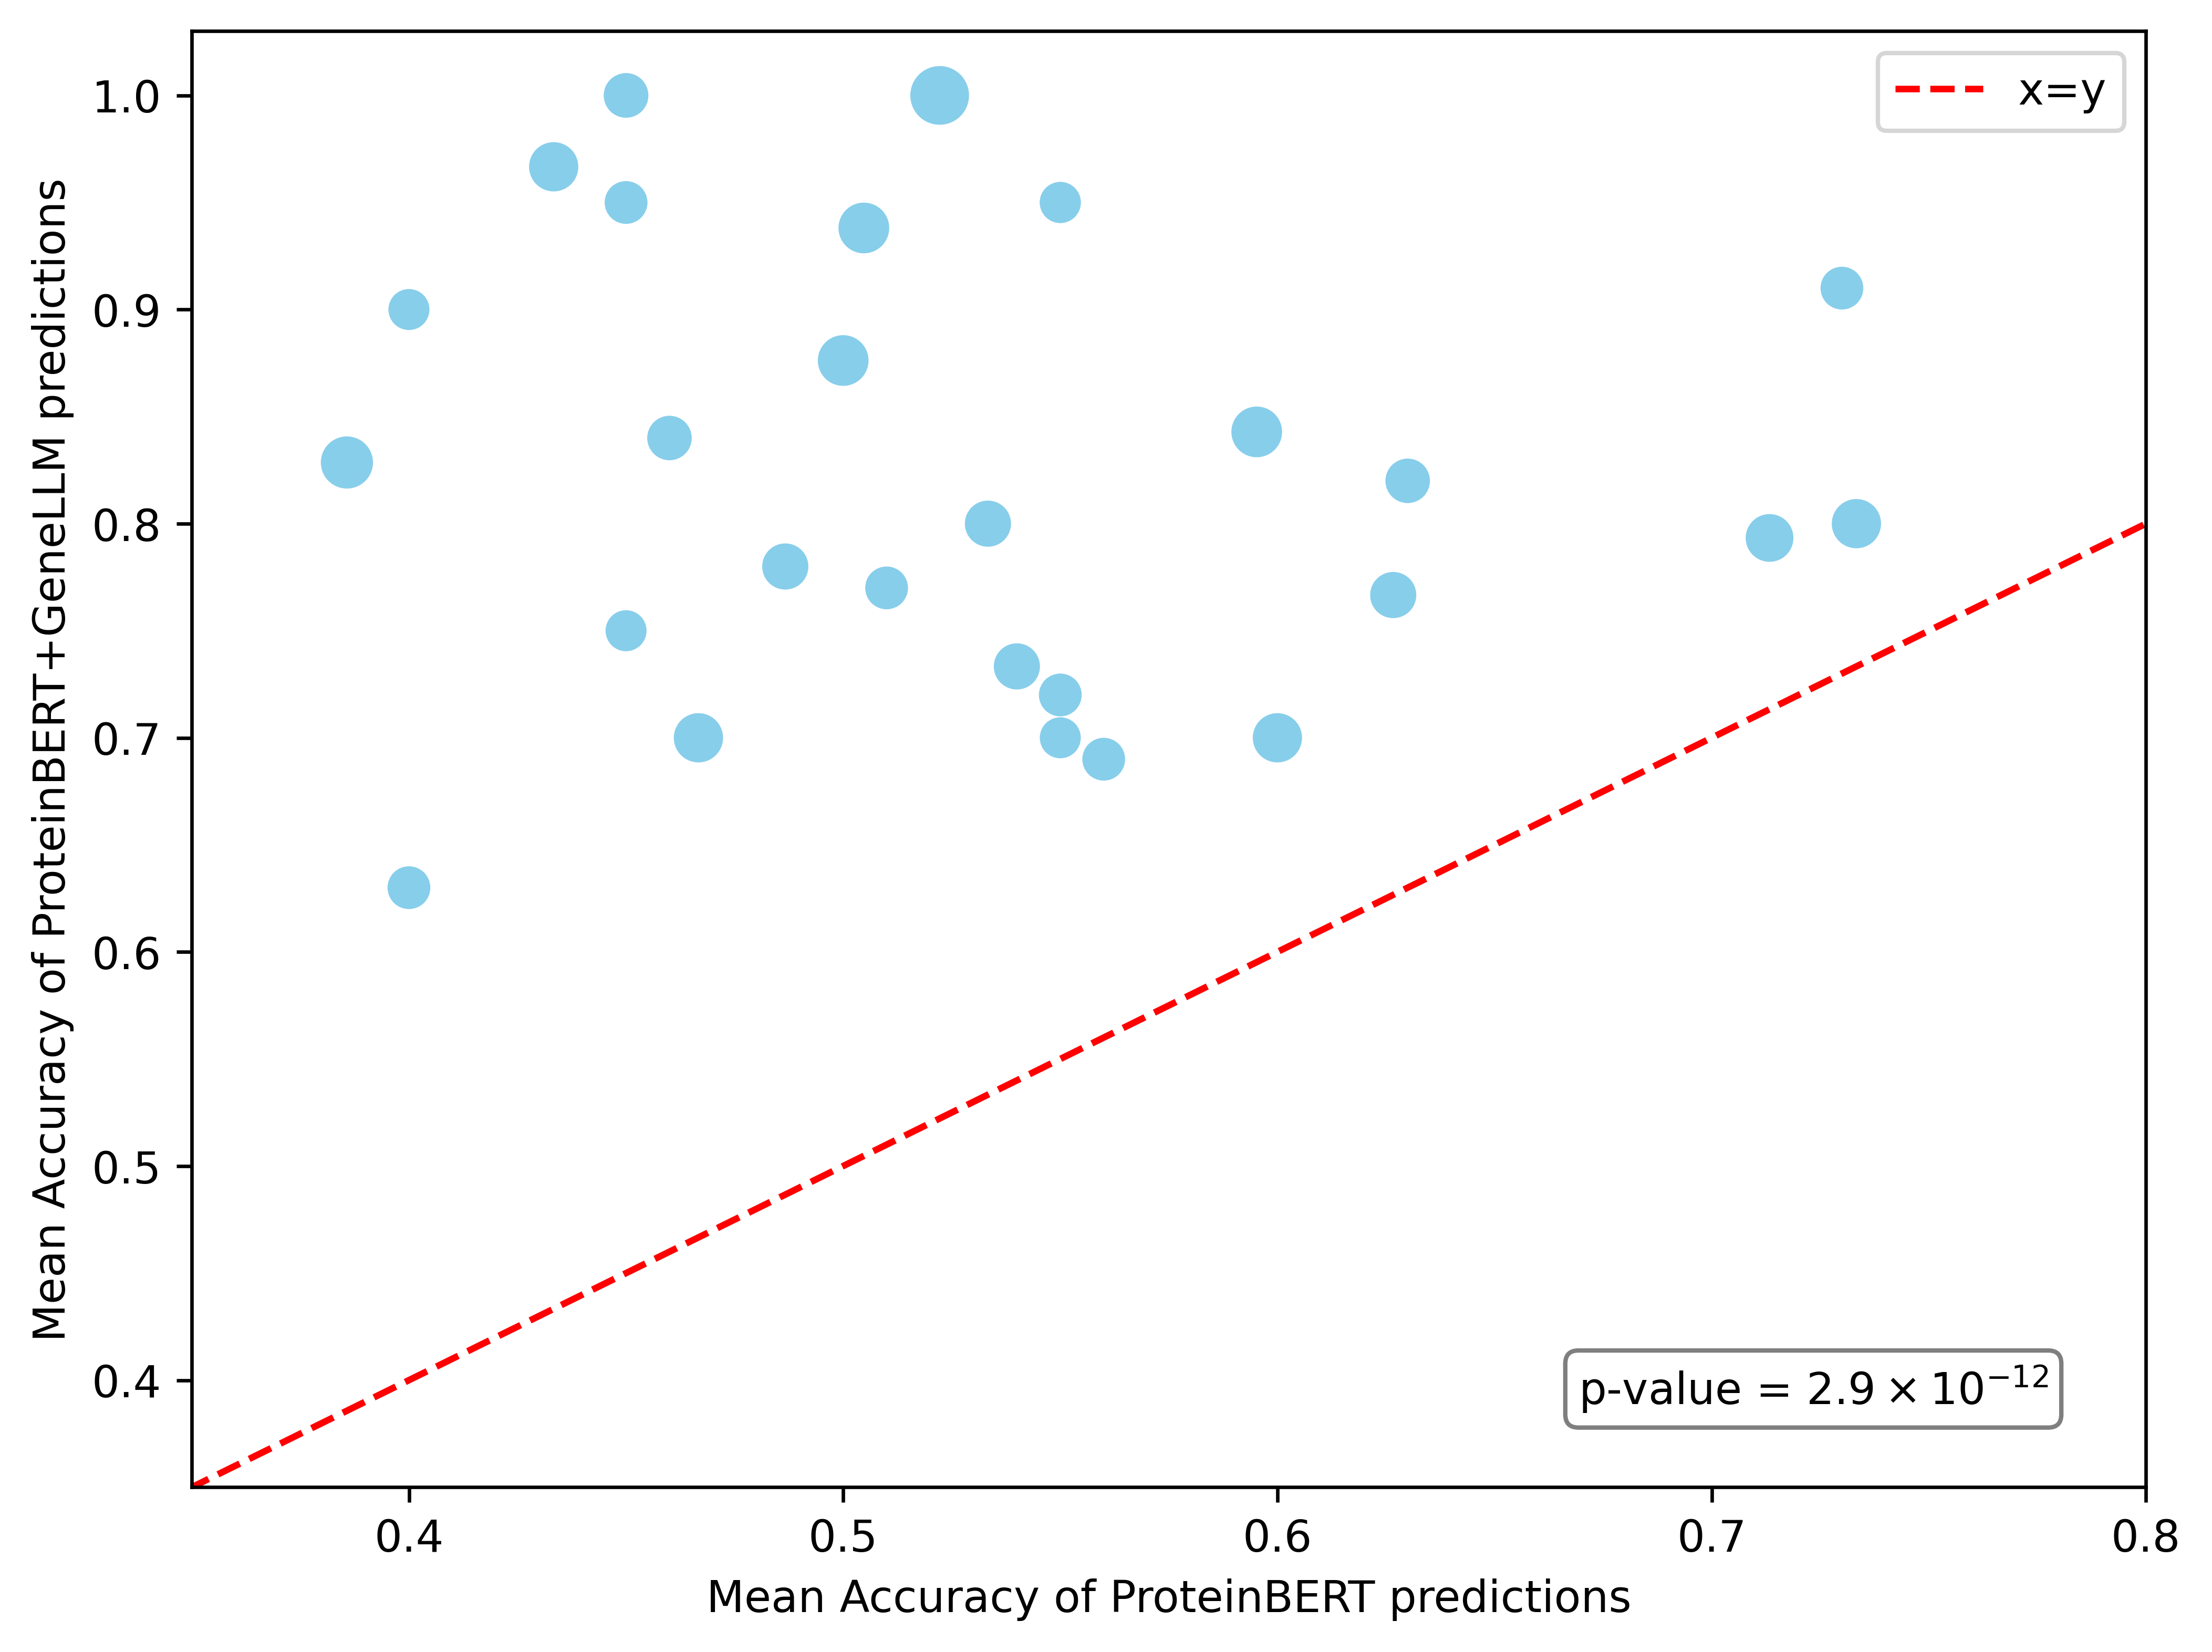

In [354]:
plot_scatter_of_means(accuracies_1_emb, accuracies_2_emb, counts_of_related)


### Classifier forall

In [290]:
accuracies_1_emb, accuracies_2_emb = train_classifier_forall_kegg(proteinbert_embeddings,
                                                                  GeneLLM_embeddings,
                                                                  kegg_embeddings,
                                                                  df_kegg,
                                                                  mini = 0)

205it [00:00, 385.26it/s]


(2272, 1536)
(2272, 2304)
(2272,)
0.7210117635668296 0.7936350873795808


In [292]:
accuracies_1_emb, accuracies_2_emb

(array([0.57802198, 0.72527473, 0.7753304 , 0.7907489 , 0.73568282]),
 array([0.68351648, 0.76483516, 0.83920705, 0.84140969, 0.83920705]))

In [356]:
(
    mean_probs_pr,
    mean_probs_gl,
    mean_probs_bo,
    y_test
)= train_classifier_forall_kegg_probabilities(proteinbert_embeddings,
                               GeneLLM_embeddings,
                               kegg_embeddings,
                               df_kegg,
                               mini = 0,
                              n_runs= 10)




205it [00:00, 390.31it/s]


(2272, 1536)
(2272, 1536)
(2272, 2304)


In [227]:
mean_probs_1

(455,)

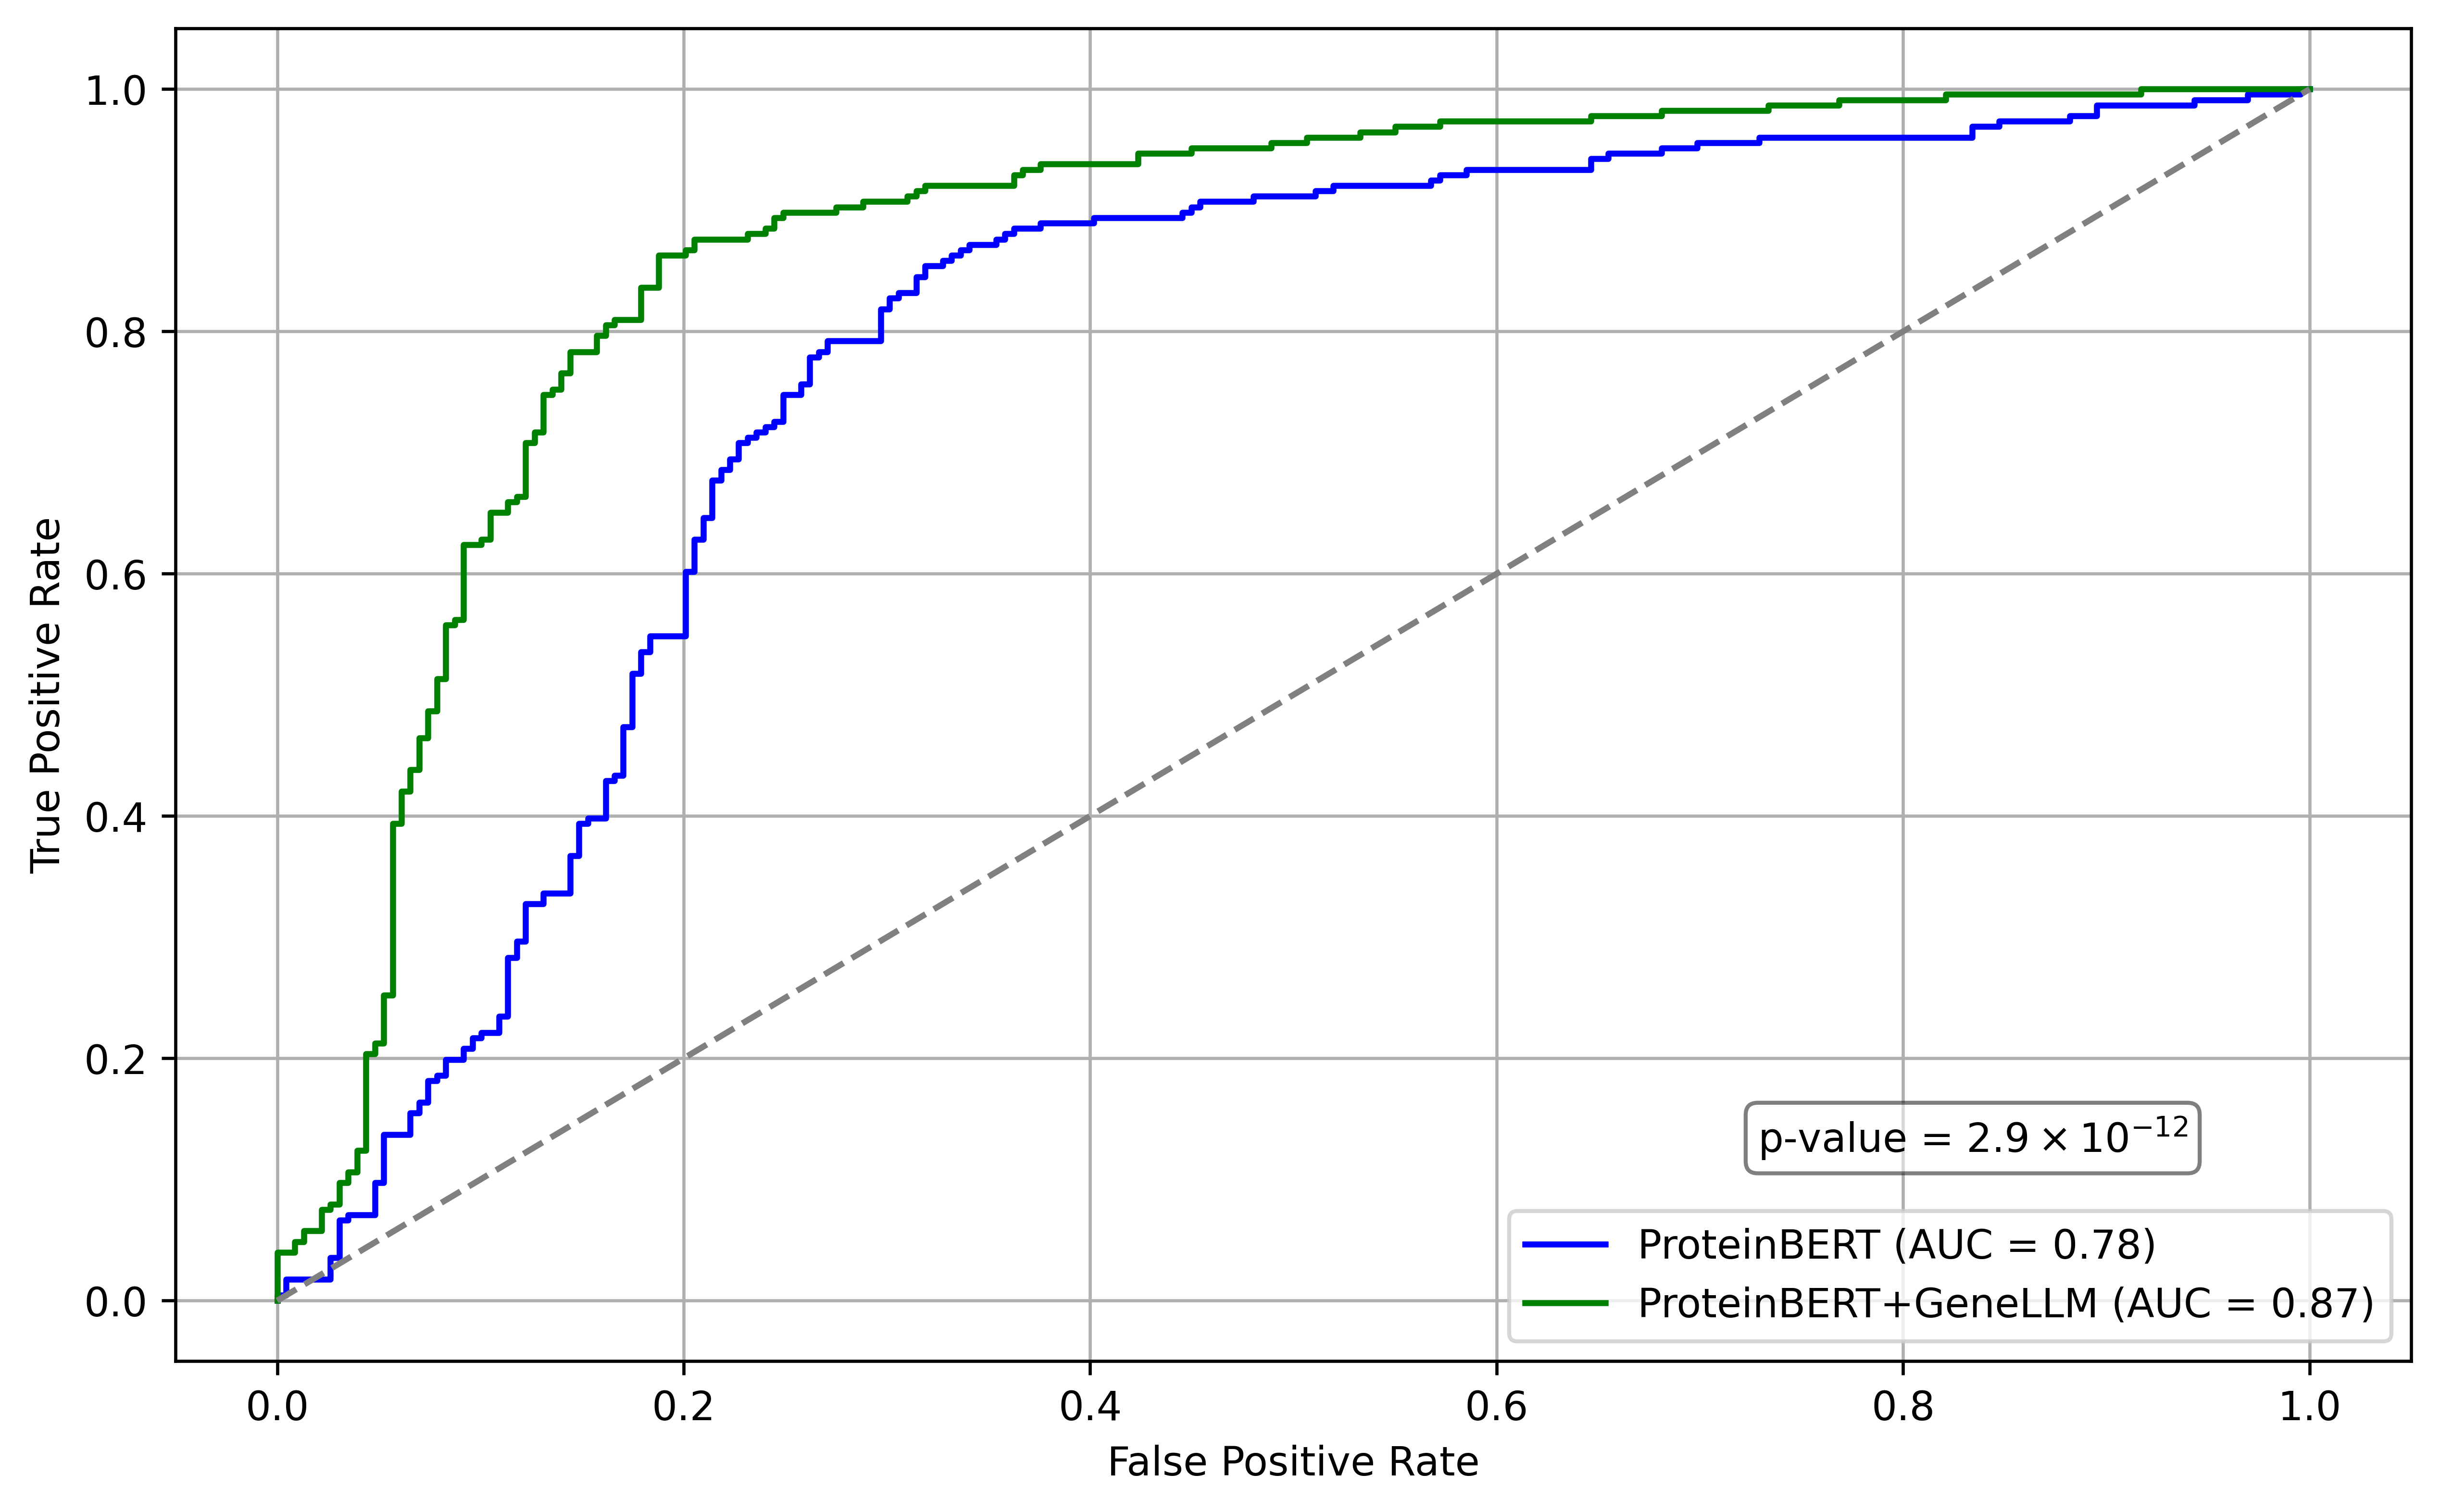

In [366]:

plot_auc(y_test,
         mean_probs_pr,
         mean_probs_gl,
         mean_probs_bo,
         classifier1_label='ProteinBERT',
         classifier2_label='GeneLLM',
         classifier3_label='ProteinBERT+GeneLLM',
         pos_class_index=1,
         text_pos = (0.9,0.15),
         dpi=600
        )

### Integration results on GO terms

In [42]:
#Load Genes
# genes = pd.read_csv("data/clean_genes.csv")

#Load proteinBERT embeddings
#proteinBert = pd.read_csv("embeddings/ProteinBERT/proteinbert.csv")
# proteinBert = proteinBert.dropna()


# common_genes = set(genes["Gene name"]) & set(proteinBert["0"])

# # proteinbert_embeddings ={g:e for g,e in zip(proteinBert["0"],
# #                                             proteinBert.iloc[:,1:].values) 
# #                          if g in common_genes}


# filtered_embeddings = proteinBert[proteinBert['0'].isin(common_genes)].iloc[:, 1:]
# reduced_embeddings = PCA(n_components=768).fit_transform(filtered_embeddings)
# proteinbert_embeddings = {gene: embedding for gene, embedding in zip(common_genes,
#                                                                      reduced_embeddings)}



genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")

#Load GO
df_go = pd.read_csv('z/home/tailab/LitGene/data/zero-shot/held_out_set.csv')
df_go = df_go.groupby('GO Term').agg({
    'Gene name': lambda x: list(set(x)), 
    'Term Summary': 'first'  
}).reset_index()
df_go.columns = ['id', 'Genes', 'Summary']

temp = set(sum(df_go["Genes"].to_list(), []))
common_genes = set(genes["Gene name"]) & temp


# gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()

gene_to_summary = genes[genes['Gene name'].isin(common_genes)].set_index('Gene name')['Summary'].to_dict()
df_go['Genes'] = df_go['Genes'].apply(lambda genes: [gene for gene in genes if gene in common_genes ])


df_go = df_go.dropna()
df_go = df_go[df_go['Genes'].apply(lambda x: len(x) > 0)]

go_to_summary =df_go.set_index('id')['Summary'].to_dict()


#Get GeneLLM Embeddings 
GeneLLM_embeddings, go_embeddings = embedd_KEGG_genes(gene_to_summary, go_to_summary)
relationships = df_go[["id","Genes"]].set_index('id')['Genes'].to_dict()

Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [01:07<00:00,  7.49s/it]


torch.Size([16928, 768])


In [46]:
belong_similarities, no_belong_similarities, index_names = analyzeOne(GeneLLM_embeddings.values(),
                                                                      GeneLLM_embeddings.keys(),
                                                                      go_embeddings.values(),
                                                                      go_embeddings.keys(),
                                                                      relationships,
                                                                      mini=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2979/2979 [01:41<00:00, 29.40it/s]


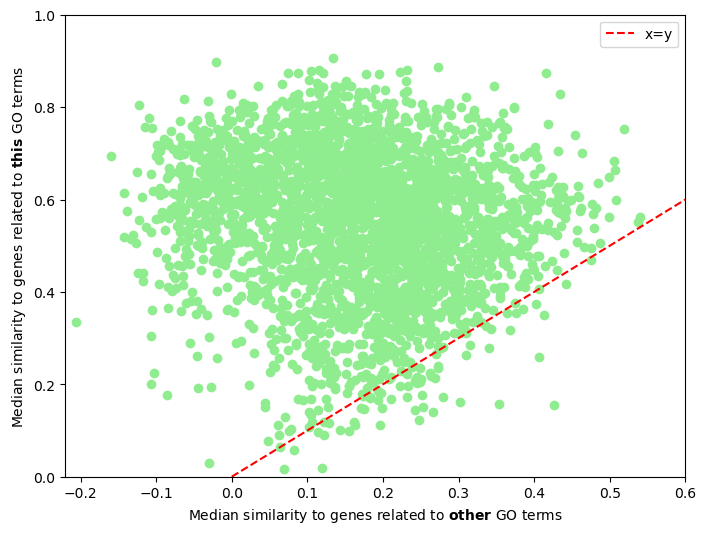

In [73]:

plot_scatter_of_medians(belong_similarities,
                        no_belong_similarities,
                        path_to_save ="/home/tailab/LitGene/outputs/zero-shot/ScatterGO.pdf")

#### classifier per GO

In [ ]:
(
    accuracies_1_emb, accuracies_2_emb, counts_of_related,  gos
) = train_classifiers_per_kegg(proteinbert_embeddings,
                              GeneLLM_embeddings,
                              go_embeddings,
                              df_go,
                              mini = 10
                             )
plot_scatter_of_means(accuracies_1_emb, accuracies_2_emb, summary_sizes)

386it [00:22,  4.19it/s] 

In [ ]:
import scipy.stats as stats
t_stat1, p_value1 = stats.ttest_rel(accuracies_1_emb, accuracies_2_emb)

t_stat2, p_value2 = stats.wilcoxon(accuracies_1_emb, accuracies_2_emb)
print(t_stat1, p_value1, "\n",t_test2, p_value2)

2960it [00:08, 348.34it/s]


(115224, 1536)
(115224, 1536)
(115224, 2304)


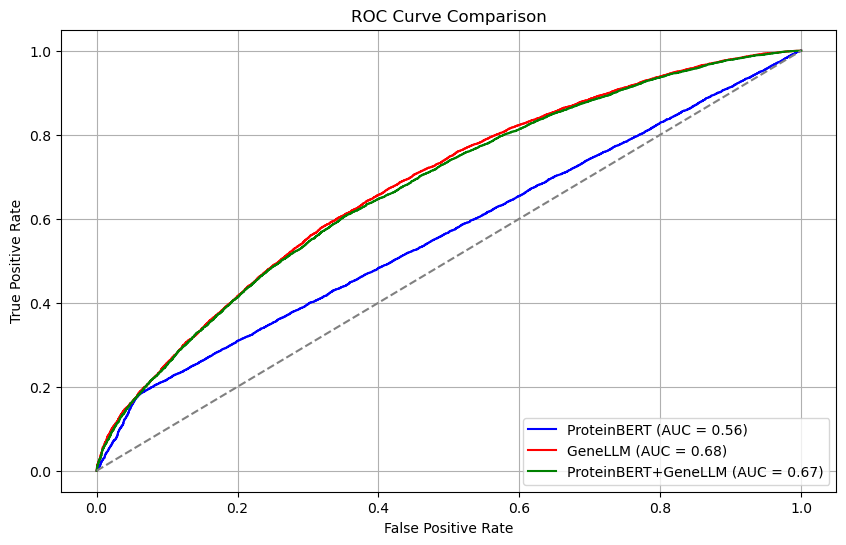

In [321]:
(
    mean_probs_pr,
    mean_probs_gl,
    mean_probs_bo,
    y_test
)= train_classifier_forall_kegg_probabilities(proteinbert_embeddings,
                               GeneLLM_embeddings,
                               go_embeddings,
                               df_go,
                               mini = 0,
                              n_runs= 5)



plot_auc(y_test,
         mean_probs_pr,
         mean_probs_gl,
         mean_probs_bo,
         classifier1_label='ProteinBERT',
         classifier2_label='GeneLLM',
         classifier3_label='ProteinBERT+GeneLLM',
         pos_class_index=1
        )

## Zero Shot Learning: KEGG pathways

In [81]:
import pandas as pd
df_relation = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_genes.tsv', sep='\t')
df_relation

,Term,id,Genes
0,Bile secretion Homo sapiens,map04976,ABCC2;SLC22A1;ATP1A4;ATP1A3;ATP1A2;SLC51B;BAAT...
1,Glycosylphosphatidylinositol(GPI)-anchor biosy...,map00563,PIGS;PIGB;PIGT;GPAA1;PIGK;PIGM;PIGG;PIGV;PIGY
2,Fatty acid elongation Homo sapiens,map00062,ELOVL1;ELOVL4;ELOVL2;TECR;ELOVL3;ACOT1;ELOVL6;...
3,Taste transduction Homo sapiens,map04742,HTR1E;HTR1F;HTR3E;HTR1D;HTR3C;HTR1A;HTR3D;TAS2...
4,Salivary secretion Homo sapiens,map04970,ATP1A4;ATP1A3;ATP1A2;LPO;CST4;HTN3;CST3;CST2;C...
...,...,...,...
258,Ribosome biogenesis in eukaryotes Homo sapiens,map03008,XRN1
259,GnRH signaling pathway Homo sapiens,map04912,ADCY9
260,Melanogenesis Homo sapiens,map04916,ADCY9
261,Alcoholism Homo sapiens,map05034,DRD2;SLC6A3


In [ ]:
c = 0
for l in list(df_relation["Genes"]):
    c += len(l.split(";"))
c

In [ ]:
import pandas as pd
df_relation = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/5/held_out_df.csv')
df_relation

In [ ]:
len(set(df_relation["Genes"]))

In [ ]:
def KEGG_triplet(df_relation, Kegg_summary_length=None, held_out_size = 30):
    
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    kg_gene_df = df_relation[["id","Genes"]].explode("Genes")
    list_of_ids = list(set(df_relation["id"]))
    
    
    #make sure the split of KEGG ids is also between 20% and 30%
    while True:

        held_out = random.sample(list_of_ids, held_out_size)
        held_out_df = kg_gene_df[kg_gene_df['id'].isin(held_out)]
        held_out_df = held_out_df[held_out_df['Genes'].isin(genes["Gene name"].to_list())]

        if int(len(kg_gene_df)*0.10) < len(held_out_df) and len(held_out_df) < int(len(kg_gene_df)*0.15):
            break
        

    #remove held_out pathways
    kg_gene_df = kg_gene_df[~kg_gene_df['id'].isin(held_out)]
    kg_gene_df = kg_gene_df[kg_gene_df['Genes'].isin(genes["Gene name"].to_list())]
    
    df_relation = df_relation[~df_relation["id"].isin(held_out)]

    
    gene_to_ids = kg_gene_df.groupby("Genes")["id"].apply(set).to_dict()
    gene_to_summary = genes.set_index("Gene name")["Summary"].to_dict()
    id_to_summary = df_relation.set_index("id")["Summary"].to_dict()


    universe = set(kg_gene_df["id"].to_list()) 
    anchor_list=[]
    positive_list = []
    negative_list = []
    

    print(len(held_out_df))
    print(len(kg_gene_df))
    
    for g in tqdm(gene_to_ids.keys()):

        positive_ids = gene_to_ids[g]
        negative_ids = universe - positive_ids

        k = len(positive_ids) 

        anchor_list.extend(random.choices([g], k=k))
        
        positive_list.extend(random.sample(list(positive_ids), k))
        
        negative_list.extend(random.sample(list(negative_ids), k))
    
    
    triplet_data ={
        "Gene name":anchor_list,
        "Anchor": [gene_to_summary.get(g,None) for g in anchor_list],
        
        "Positive":[id_to_summary.get(i,None) for i in positive_list],
        "PositiveTerm":positive_list,
        
        "Negative":[id_to_summary.get(i,None) for i in negative_list ],
        "NegativeTerm":negative_list}

    
    trim_KEGG = lambda summary, n=10: ' '.join(summary.split()[:n])
    
    triplet_df = pd.DataFrame(triplet_data).dropna().sample(frac=1).reset_index(drop=True)
    
    if Kegg_summary_length is not None:
        triplet_df["Positive"] = triplet_df["Positive"].apply(lambda s: trim_KEGG(s,Kegg_summary_length ) )
        triplet_df["Negative"] = triplet_df["Negative"].apply(lambda s: trim_KEGG(s,Kegg_summary_length ) )
        
    
        
    
    return triplet_df, held_out_df

In [ ]:
df_relation = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_genes.tsv', sep='\t')
df_relation["Genes"] = df_relation["Genes"].apply(lambda g: g.split(";"))

kegg_to_summary = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                              sep='\t', header=None).set_index('id')['Summary'].to_dict()

pathwayId_to_term = pd.read_csv('zero-shot/KEGG/kegg_pathways1.tsv',
                                sep='\t').set_index('Pathway ID')['Description'].to_dict()

df_relation["Summary"] = df_relation["id"].apply(lambda i: kegg_to_summary.get(i, None))
df_relation["Term"] = df_relation["id"].apply(lambda i: pathwayId_to_term.get(i, None))
df_relation = df_relation.dropna()
df_relation


In [ ]:
triplet_df, held_out_df = KEGG_triplet(df_relation, Kegg_summary_length=500)
triplet_df

In [ ]:
import gc
import os
torch.cuda.empty_cache()
gc.collect()

contrastive_flag = False
margin = 2
alpha=0.5

epochs =4
lr = 3e-5
pool ="mean"
max_length = 512
batch_size = 100
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = "unsupervised"
n_labels = 1
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"


for keg_length in [5,10,50,100,200,350]:
    
    path = f"/home/tailab/LitGene/da/home/tailab/LitGene/data/zero-shot/KEGG/{str(keg_length)}/"
    
    os.makedirs(path, exist_ok=True)    
    
    triplet_df, held_out_df = KEGG_triplet(df_relation, Kegg_summary_length=keg_length)
    
    triplet_df.to_csv(path+"triplet_df.csv",index=False)
    held_out_df.to_csv(path+"held_out_df.csv",index=False)

    

    train_loader, val_loader, test_loader= process_triplet_data(triplet_df, max_length=max_length,
                                                                batch_size=batch_size,
                                                                test_split_size=0.01,
                                                                gene2vec_flag = gene2vec_flag,
                                                                model_name= model_name)

    print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

    zshot_model, history, labels_test, best_pred = trainer(epochs, train_loader, val_loader,
                                                           test_loader, lr =lr, pool= pool,
                                                           max_length= max_length,
                                                           batch_size = batch_size, drop_rate =drop_rate,
                                                           gene2vec_flag = gene2vec_flag,
                                                           gene2vec_hidden = gene2vec_hidden,
                                                           device = device, task_type = task_type,
                                                           n_labels = n_labels, model_name= model_name,
                                                           class_map = None, save_model_path=path,
                                                           contrastive_flag = contrastive_flag,
                                                           alpha =alpha,margin = margin)


In [11]:
def zero_shot_learning(go_term_embeddings, gene_embeddings, threshold=0.5):
    """
    Determines if genes belong to GO terms using zero-shot learning based on cosine similarity, 
    without explicit for loops.

    Args:
    - go_term_embeddings (array): Array of embeddings for GO terms.
    - gene_embeddings (array): Array of embeddings for genes.
    - threshold (float): The threshold for deciding if a gene belongs to a GO term.

    Returns:
    - distances (array): Array of cosine similarity values between each gene and GO term pair.
    - predictions (array): Array of predictions (0 or 1) indicating whether the gene belongs to the GO term.
    """
    
    go_term_norms = np.linalg.norm(go_term_embeddings, axis=1, keepdims=True)
    gene_norms = np.linalg.norm(gene_embeddings, axis=1, keepdims=True)
    
    normalized_go_terms = go_term_embeddings / go_term_norms
    normalized_genes = gene_embeddings / gene_norms


    distances = pairwise_distances(normalized_genes, normalized_go_terms, metric='cosine')
    similarities = 1 - distances


    #include all negative genes 
    #calculate AUC per go term where distances as your predictions. 
    #box plot
    
    
    
    predictions = (similarities >= threshold).astype(int)#.numpy()
#     print(predictions)

    
    labels = np.ones(predictions.shape)
    accuracy = accuracy_score(labels, predictions)
    
    return distances, similarities, predictions, accuracy

def analyzeOne(gene_embeddings, gene_names, term_embeddings, term_names, relationships, mini = 20):
    
    gene_embeddings_dict = {gname: embed for gname, embed in zip(gene_names, gene_embeddings)}
    term_embeddings_dict = {tname: embed for tname, embed in zip(term_names, term_embeddings)}
    
    belong_similarities =[]
    no_belong_similarities = []
    names = []
    
    for term, t_genes in tqdm(relationships.items()):
        
        if len(t_genes) > mini:
            belong = t_genes
            no_belong = list(set(gene_names) - set(t_genes))

            belong_embedding = np.array([gene_embeddings_dict[g] for g in belong])
            no_belong_embedding = np.array([gene_embeddings_dict[g] for g in no_belong])

            _, bsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], belong_embedding)
            
            _, nsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], no_belong_embedding)
            

            belong_similarities.append(np.squeeze(bsim))
            no_belong_similarities.append(np.squeeze(nsim))
            names.append(term)
            
    return belong_similarities, no_belong_similarities, names
 
def relevance_differences(belong_similarities, no_belong_similarities):
    
    s=len(belong_similarities)
    return [np.mean(belong_similarities[i]) - np.mean(no_belong_similarities[i]) for i in range(s)]

def plot_zero_shot_sim(gene_embedding,gene_names,
                       kegg_embedding, kegg_names,
                       relationships, mini=0,
                       title = "GeneLLM",
                       ylim = [0,1]
                      ):

    fig, ax = plt.subplots(figsize=(15, 6), dpi=600)


    belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embedding,
                                                                          gene_names, 
                                                                          kegg_embedding,
                                                                          kegg_names,
                                                                          relationships,
                                                                          mini=0)
    
    s = len(belong_similarities)
    spacing = 0.7  
    positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
    positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

    # Box plot for the first 20 of belong_similarities
    bp1 = ax.boxplot(belong_similarities[:s],
                     positions=positions_belong,
                     patch_artist=True,
                     boxprops=dict(facecolor="#FF7F50"),
                     showfliers=False)

    # Box plot for the first 20 of no_belong_similarities
    bp2 = ax.boxplot(no_belong_similarities[:s],
                     positions=positions_no_belong,
                     patch_artist=True,
                     boxprops=dict(facecolor="#DDA0DD"),
                     showfliers=False)

    # Adding labels and titles
    #'Predicting KEGG pathways from GeneLLM trained on GO terms'
    ax.set_title(title)
    ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
    ax.set_xticklabels(index_names[:s], rotation=90, fontsize=8)
    ax.set_xlabel('KEGG Pathways')
    ax.set_ylabel('Cosine Similarity')

    # Adding legend
    legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this pathway',
                                                            'other pathways'],
                       loc='upper right', bbox_to_anchor=(1.15, 1), title='Genes annotated with ')

    legend.get_title().set_fontsize('10')  


    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    plt.tight_layout()
    plt.show()

def plot_scatter_of_medians(gembed, gene_names, kembed, kegg_names, relationships ):

    belong_similarities, no_belong_similarities, index_names = analyzeOne(gembed,
                                                                          gene_names, 
                                                                          kembed,
                                                                          kegg_names,
                                                                          relationships,
                                                                          mini=0)

    medians1 = [np.median(inner_list) for inner_list in belong_similarities]
    medians2 = [np.median(inner_list) for inner_list in no_belong_similarities]
    #sizes = [len(inner_list) for inner_list in belong_similarities]

    sizes=[]
    for inner_list in belong_similarities:
        try:
            sizes.append(len(inner_list))
        except:
            sizes.append(0)


    plt.figure(600, figsize=(8,6))

    plt.scatter(medians2, medians1 , s=np.array(sizes)*7, c='green')  # x-axis: medians2, y-axis: medians1
    plt.xlabel('Median of Genes Associated to other Pathways')
    plt.ylabel('Median of Genes Associated to the KEGG Pathways')
    plt.xlim(0,1)
    plt.ylim(0,1)

    # line_range = np.linspace(min(min(medians1), min(medians2)), max(max(medians1), max(medians2)), 100)
    line_range = np.linspace(0,1), np.linspace(0,1)

    plt.plot(line_range[0], line_range[0], label='x=y', color='red', linestyle='--')
    plt.legend()

    # plt.title('Scatter Plot of Medians')
    plt.show()


In [ ]:
held_out_set = pd.read_csv("/home/tailab/LitGene/data/zero-shot/KEGG/5/held_out_df.csv")
held_out_set

In [ ]:
with open( f"/home/tailab/LitGene/models/zero-shot/KEGG/{5}/model_{str(0)}.pth", 'rb') as file:
    loaded_model = torch.load(file,map_location = 'cuda')

In [ ]:

relevance_scores =[]
for k in [5,10,50,100,200,350]:
    print(k)
    print("-"*60)
    
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    held_out_set = pd.read_csv(f"zero-shot/KEGG/{k}/held_out_df.csv")
    relationships = held_out_set.groupby("id")['Genes'].apply(set).to_dict()
    
    trim_KEGG = lambda summary, n=10: ' '.join(summary.split()[:n])
    kegg_summary_df = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                                  sep='\t', header=None)
    
    kegg_summary_df["Summary"] = kegg_summary_df["Summary"].apply(lambda s: trim_KEGG(s,k))
    
    kegg_to_summary = kegg_summary_df.set_index('id')['Summary'].to_dict()
    
    
    
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
    gene_names = gene_to_summary.keys()
    kegg_names = kegg_to_summary.keys()


    gene_text= list(gene_to_summary.values())
    kegg_text= list(kegg_to_summary.values()) 
    text = gene_text + kegg_text

    
    with open( f"zero-shot/KEGG/{k}/model_{str(0)}.pth", 'rb') as file:
        loaded_model = torch.load(file,map_location=cuda)
    
    
    embed = getEmbeddings(text, loaded_model.module, batch_size=2000).detach().cpu().numpy()

    gene_embeddings = embed[:len(gene_text)] 
    kegg_embeddings = embed[len(gene_text):]


    belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings,
                                                                          gene_names, kegg_embeddings,
                                                                          kegg_names, relationships,
                                                                          mini=0)

    lst = relevance_differences(belong_similarities, no_belong_similarities)
    relevance_scores.append(lst)
    

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), dpi=300)

# Create violin plot
parts = ax.violinplot(relevance_scores, widths=0.3, showmeans=False, showmedians=True, showextrema=True)

# Change color to dark green for each part of the violin plot
for pc in parts['bodies']:
    pc.set_facecolor('#D7BDE2')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_title('Relevance Scores of genes to KEGG pathways')
ax.set_ylabel('Cosine Similarity')
ax.set_xlabel('KEGG Summary Length')

# Set x-tick labels
ax.set_xticks([1, 2, 3, 4, 5, 6])  # Adjust the number of ticks based on your data
ax.set_xticklabels([5, 10, 50, 100, 200, 350])

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 5), dpi=300)

ax.boxplot(relevance_scores, patch_artist=True, widths = [0.3 for i in relevance_scores],#bootstrap=2000,
           boxprops=dict(facecolor="skyblue"), showfliers=False)

ax.set_title('Relevance Scores of genes to KEGG pathways')
ax.set_ylabel('Cosine Similarity')
ax.set_xlabel('KEGG Summary Length')
ax.set_xticklabels([5,10,50,100,200,350])


plt.tight_layout()
plt.show()


In [79]:
df_relation = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_genes.tsv', sep='\t').dropna(subset=["id", "Genes"])
df_relation["Genes"] = df_relation["Genes"].apply(lambda g: g.split(";") )
df_relation

,Term,id,Genes
0,Bile secretion Homo sapiens,map04976,"[ABCC2, SLC22A1, ATP1A4, ATP1A3, ATP1A2, SLC51..."
1,Glycosylphosphatidylinositol(GPI)-anchor biosy...,map00563,"[PIGS, PIGB, PIGT, GPAA1, PIGK, PIGM, PIGG, PI..."
2,Fatty acid elongation Homo sapiens,map00062,"[ELOVL1, ELOVL4, ELOVL2, TECR, ELOVL3, ACOT1, ..."
3,Taste transduction Homo sapiens,map04742,"[HTR1E, HTR1F, HTR3E, HTR1D, HTR3C, HTR1A, HTR..."
4,Salivary secretion Homo sapiens,map04970,"[ATP1A4, ATP1A3, ATP1A2, LPO, CST4, HTN3, CST3..."
...,...,...,...
258,Ribosome biogenesis in eukaryotes Homo sapiens,map03008,[XRN1]
259,GnRH signaling pathway Homo sapiens,map04912,[ADCY9]
260,Melanogenesis Homo sapiens,map04916,[ADCY9]
261,Alcoholism Homo sapiens,map05034,"[DRD2, SLC6A3]"


In [80]:
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
all_genes = genes["Gene name"].to_list()


df_relation['Genes'] = df_relation['Genes'].apply(lambda genes: [gene.strip() for gene in genes 
                                                                 if gene.strip() in all_genes])
df_relation
# df_relation = df_relation.dropna(subset=["id", "Genes", 'Summary'])
# relationships = df_relation.set_index('id')['Genes'].to_dict()

,Term,id,Genes
0,Bile secretion Homo sapiens,map04976,"[ABCC2, SLC22A1, ATP1A4, ATP1A3, ATP1A2, SLC51..."
1,Glycosylphosphatidylinositol(GPI)-anchor biosy...,map00563,"[PIGS, PIGB, PIGT, GPAA1, PIGK, PIGM, PIGG, PI..."
2,Fatty acid elongation Homo sapiens,map00062,"[ELOVL1, ELOVL4, ELOVL2, TECR, ELOVL3, ACOT1, ..."
3,Taste transduction Homo sapiens,map04742,"[HTR1F, HTR3E, HTR1D, HTR3C, HTR1A, HTR3D, TAS..."
4,Salivary secretion Homo sapiens,map04970,"[ATP1A4, ATP1A3, ATP1A2, LPO, CST4, HTN3, CST3..."
...,...,...,...
258,Ribosome biogenesis in eukaryotes Homo sapiens,map03008,[XRN1]
259,GnRH signaling pathway Homo sapiens,map04912,[ADCY9]
260,Melanogenesis Homo sapiens,map04916,[ADCY9]
261,Alcoholism Homo sapiens,map05034,"[DRD2, SLC6A3]"


In [ ]:

def predict_KEGG(df_relation):
    
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    all_genes = genes["Gene name"].to_list()
    
    
    df_relation['Genes'] = df_relation['Genes'].apply(lambda genes: [gene for gene in genes 
                                                                     if gene in all_genes])

    df_relation = df_relation.dropna(subset=["id", "Genes", 'Summary'])
    relationships = df_relation.set_index('id')['Genes'].to_dict()


    kegg_to_summary = df_relation.set_index('id')["Summary"].to_dict()
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()


    gene_names = gene_to_summary.keys()
    kegg_names = kegg_to_summary.keys()


    gene_text= list(gene_to_summary.values())
    kegg_text= list(kegg_to_summary.values()) 
    text = gene_text + kegg_text


    loaded_model = torch.load(f"zero-shot/state_dict_{str(1)}.pth")
    embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()
    gembed = embed[:len(gene_text)] 
    kembed = embed[len(gene_text):]
    
    return gembed, gene_names, kembed, kegg_names, relationships



In [ ]:
triplet_df = pd.read_csv(f"/home/tailab/LitGene/zero-shot/KEGG/{350}/triplet_df.csv")
triplet_df

In [ ]:
genes = pd.read_csv("data/clean_genes.csv")
df_relation = pd.read_csv('zero-shot/KEGG/kegg_genes.tsv', sep='\t').dropna(subset=["id", "Genes"])
df_relation["Genes"] = df_relation["Genes"].apply(lambda g: g.split(";"))

kegg_summary_df = pd.read_csv('zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                              sep='\t', header=None).set_index('id')['Summary'].to_dict()

all_genes = genes["Gene name"].to_list()



df_relation['Genes'] = df_relation['Genes'].apply(lambda genes:
                                                  [gene for gene in genes if gene in all_genes])

df_relation['KEGG Summary'] = df_relation["id"].apply(lambda i: kegg_summary_df.get(i, None) )

df_relation = df_relation.dropna(subset=["id", "Genes", 'KEGG Summary'])
relationships = df_relation.set_index('id')['Genes'].to_dict()



kegg_to_summary = df_relation.set_index('id')["KEGG Summary"].to_dict()
gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()


gene_names = gene_to_summary.keys()
kegg_names = kegg_to_summary.keys()


gene_text= list(gene_to_summary.values())
kegg_text= list(kegg_to_summary.values()) 
text = gene_text + kegg_text


loaded_model = torch.load(f"zero-shot/state_dict_{str(1)}.pth")
embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()
gembed = embed[:len(gene_text)] 
kembed = embed[len(gene_text):]


In [ ]:
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")

loaded_model = torch.load(f"zero-shot/state_dict_{str(0)}.pth")
embeddings = getEmbeddings(genes["Summary"].to_list(),
                           loaded_model, batch_size=2000).detach().cpu().numpy()


In [ ]:
k=350
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
held_out_set = pd.read_csv(f"/home/tailab/LitGene/data/zero-shot/KEGG/{k}/held_out_df.csv")
relationships = held_out_set.groupby("id")['Genes'].apply(set).to_dict()

trim_KEGG = lambda summary, n=10: ' '.join(summary.split()[:n])
kegg_summary_df = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                              sep='\t', header=None)

kegg_summary_df["Summary"] = kegg_summary_df["Summary"].apply(lambda s: trim_KEGG(s,k))

kegg_to_summary = kegg_summary_df.set_index('id')['Summary'].to_dict()



gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
gene_names = gene_to_summary.keys()
kegg_names = kegg_to_summary.keys()


gene_text= list(gene_to_summary.values())
kegg_text= list(kegg_to_summary.values()) 
text = gene_text + kegg_text


gene_embeddings, kegg_embeddings= [],[]
for ep in ["kegg", "kegg-go","base"]:
    
    if ep =="kegg":
        print(ep)
        
        with open( f"zero-shot/KEGG/{k}/model_{str(1)}.pth", 'rb') as file:
            loaded_model = torch.load(file,map_location = 'cuda')
            embed = getEmbeddings(text, loaded_model.module, batch_size=2000).detach().cpu().numpy()
            
    elif ep =="kegg-go":
        print(ep)

        loaded_model = torch.load(f"zero-shot/state_dict_{str(0)}.pth")
        embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()
        
    elif ep =="base":
        print(ep)
        embed = getEmbeddings(text, None, batch_size=2000).detach().cpu().numpy()
        
    else:
        raise ValueError(ep)

    gembed = embed[:len(gene_text)] 
    kembed = embed[len(gene_text):]

    gene_embeddings.append(gembed)
    kegg_embeddings.append(kembed)


In [ ]:
belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embedding,
                                                                      gene_names, 
                                                                      kegg_embedding,
                                                                      kegg_names,
                                                                      relationships,
                                                                      mini=0)



In [ ]:
#["kegg", "kegg-go","base"]

plot_zero_shot_sim(gene_embeddings[0],gene_names,
                   kegg_embeddings[0], kegg_names,
                   relationships, mini=0,
                   ylim=[-0.1,1],
                   title = 'Predicting KEGG pathways from GeneLLM trained on KEGG data'  )


In [ ]:
plot_zero_shot_sim(gene_embeddings[1],gene_names,
                   kegg_embeddings[1], kegg_names,
                   relationships, mini=5,
                   ylim=[-0.1,1],
                   title = 'Predicting KEGG pathways from GeneLLM trained on GO Terms'  )


In [ ]:
plot_zero_shot_sim(gene_embeddings[2],gene_names,
                   kegg_embeddings[2], kegg_names,
                   relationships, mini=0,
                   ylim=None,
                   title = 'Predicting KEGG pathways from GeneLLM Base'  )


In [ ]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=300)


belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings[1],
                                                                      gene_names, 
                                                                      kegg_embeddings[1],
                                                                      kegg_names,
                                                                      relationships,
                                                                      mini=0)

s = len(belong_similarities_base)
spacing = 0.7
positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

# Box plot for the first 20 of belong_similarities
bp1 = ax.boxplot(belong_similarities_base[:s],
                 positions=positions_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="skyblue"),
                 showfliers=False)

# Box plot for the first 20 of no_belong_similarities
bp2 = ax.boxplot(no_belong_similarities_base[:s],
                 positions=positions_no_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="lightgreen"),
                 showfliers=False)

# Adding labels and titles
ax.set_title('GeneLLM Base')
ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
ax.set_xticklabels(index_names_base[:s], rotation=90, fontsize=8)
ax.set_xlabel('GO Terms')
ax.set_ylabel('Cosine Similarity')

# Adding legend
legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this GO term',
                                                        'other GO terms'],
                   loc='upper right', bbox_to_anchor=(1.15, 1), title='Genes annotated with ')

legend.get_title().set_fontsize('10')  


# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Genes annotated with GO term','Genes annotated with other GO terms'], loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=300)


belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings,
                                                                      gene_names, kegg_embeddings,
                                                                     kegg_names, relationships,
                                                                    mini=0)

s = 10 #len(belong_similarities)
spacing = 0.7  # Additional spacing between pairs
positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

# Box plot for the first 20 of belong_similarities
bp1 = ax.boxplot(belong_similarities[:s],
                 positions=positions_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="skyblue"),
                 showfliers=False)

# Box plot for the first 20 of no_belong_similarities
bp2 = ax.boxplot(no_belong_similarities[:s],
                 positions=positions_no_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="lightgreen"),
                 showfliers=False)

# Adding labels and titles
ax.set_title('GeneLLM Contrastive')
ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
ax.set_xticklabels(index_names[:s], rotation=90, fontsize=8)
ax.set_xlabel('GO Terms')
ax.set_ylabel('Cosine Similarity')

# Adding legend
legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this GO term',
                                                        'other GO terms'],
                   loc='upper right', bbox_to_anchor=(1.15, 1), title='Genes annotated with ')

legend.get_title().set_fontsize('10')  


# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Genes annotated with GO term','Genes annotated with other GO terms'], loc='upper right')

plt.tight_layout()
plt.show()


In [ ]:
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
held_out_set = pd.read_csv("/home/tailab/LitGene/data/zero-shot/KEGG/350/held_out_df.csv")
relationships = held_out_set.groupby("id")['Genes'].apply(set).to_dict()
kegg_to_summary = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                              sep='\t', header=None).set_index('id')['Summary'].to_dict()
gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
gene_names = gene_to_summary.keys()
kegg_names = kegg_to_summary.keys()


gene_text= list(gene_to_summary.values())
kegg_text= list(kegg_to_summary.values()) 
text = gene_text + kegg_text


gene_embeddings, kegg_embeddings= [],[]
for ep in [0, None]:
    
    if ep is not None:
        sdict = torch.load(f"zero-shot/KEGG/350/state_dict_{str(ep)}.pth")
#         zshot_model.load_state_dict(sdict)
        embed = getEmbeddings(text, sdict, batch_size=2000).detach().cpu().numpy()
        
    else:
        embed = getEmbeddings(text, None, batch_size=2000).detach().cpu().numpy()


    gembed = embed[:len(gene_text)] 
    kembed = embed[len(gene_text):]

    gene_embeddings.append(gembed)
    kegg_embeddings.append(kembed)

gene_names = gene_to_summary.keys()
kegg_names = kegg_to_summary.keys()


In [ ]:
belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings[2],
                                                         gene_names, kegg_embeddings[2],
                                                         kegg_names, relationships,
                                                         mini=0)


In [ ]:
fig, ax = plt.subplots(figsize=(15, 6), dpi=300)

s = len(belong_similarities)
spacing = 0.7  # Additional spacing between pairs
positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

# Box plot for the first 20 of belong_similarities
bp1 = ax.boxplot(belong_similarities,
                 positions=positions_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="skyblue"),
                 showfliers=False)

# Box plot for the first 20 of no_belong_similarities
bp2 = ax.boxplot(no_belong_similarities,
                 positions=positions_no_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="lightgreen"),
                 showfliers=False)

# Adding labels and titles
ax.set_title('GeneLLM Contrastive')
ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
ax.set_xticklabels(index_names, rotation=90, fontsize=8)
ax.set_xlabel('GO Terms')
ax.set_ylabel('Cosine Similarity')

# Adding legend
legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this GO term',
                                                        'other GO terms'],
                   loc='upper right', title='Genes annotated with ')
legend.get_title().set_fontsize('10')  



# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Genes annotated with GO term','Genes annotated with other GO terms'], loc='upper right')

plt.tight_layout()
plt.show()


## Zero Shot Learning: Go-Terms

In [129]:
go_terms_df = pd.read_csv('/home/tailab/LitGene/data/GO/mart_export.txt', delimiter=",").dropna()
len(set(go_terms_df["GO term accession"]))

19075

In [130]:
go_terms_df

,Gene stable ID,Gene name,GO term accession,GO term name
0,ENSG00000210049,MT-TF,GO:0030533,triplet codon-amino acid adaptor activity
1,ENSG00000210049,MT-TF,GO:0006412,translation
4,ENSG00000210082,MT-RNR2,GO:0003735,structural constituent of ribosome
5,ENSG00000210082,MT-RNR2,GO:0005840,ribosome
6,ENSG00000209082,MT-TL1,GO:0030533,triplet codon-amino acid adaptor activity
...,...,...,...,...
456584,ENSG00000116786,PLEKHM2,GO:0032880,regulation of protein localization
456585,ENSG00000116786,PLEKHM2,GO:0010008,endosome membrane
456586,ENSG00000116786,PLEKHM2,GO:0019894,kinesin binding
456587,ENSG00000116786,PLEKHM2,GO:0032418,lysosome localization


In [ ]:
def go_terms_triplets_all_levels(held_out_size=3000):
    
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    
    
    go_terms_df = pd.read_csv('/home/tailab/LitGene/data/GO/mart_export.txt', delimiter=",")
    go_terms_df = go_terms_df[go_terms_df['Gene name'].isin(genes["Gene name"].to_list())].dropna()
    go_terms_df = go_terms_df[["Gene name", "GO term accession"]].drop_duplicates(keep='first').reset_index(drop=True)
    go_terms_df = go_terms_df.rename(columns = {"GO term accession": "GO Term"})
    
    
    list_of_gos = list(set(go_terms_df["GO Term"].to_list()))
    
    #hold 3000 go terms for zero shot learning
    while True:

        held_out = random.sample(list_of_gos, held_out_size)
        held_out_df = go_terms_df[go_terms_df['GO Term'].isin(held_out)]

        if int(len(go_terms_df)*0.2) < len(held_out_df) and len(held_out_df) < int(len(go_terms_df)*0.3):
            break

    
    go_terms_df = go_terms_df[~go_terms_df['GO Term'].isin(held_out)]
    r = len(set(go_terms_df["GO Term"]))
    print(f"Remaining unique GO Terms:{r} / {len(list_of_gos)}")
    
    
    # Performing triplet dataset
    go_to_summary = dict()
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
    GO_graph = obonet.read_obo("/home/tailab/LitGene/data/GO/go-basic.obo")

    for go_term in list_of_gos:
        
        if  GO_graph.nodes.get(go_term, False):
            go_to_summary[go_term] = re.findall(r'"(.*?)"', GO_graph.nodes[go_term]["def"])[0]
        else:
            go_to_summary[go_term] = None
    

    
    universe = set(go_terms_df["GO Term"])

    anchor_list=[]
    positive_list = []
    negative_list = []

    
    genes_to_go_terms = go_terms_df.groupby('Gene name')['GO Term'].apply(set).to_dict()
    for g in tqdm(genes_to_go_terms.keys()):


        positive_terms = genes_to_go_terms[g]
        negative_terms = universe - positive_terms 

        k = len(positive_terms) #if len(interact) < n_interactions else n_interactions

        anchor_list.extend(random.choices([g], k=k))
        
        positive_list.extend(random.sample(positive_terms, k))
        
        negative_list.extend(random.sample(negative_terms, k))
        
        
    triplet_data ={
        "Gene name":anchor_list,
        "Anchor": [gene_to_summary[g] for g in anchor_list],
        
        "Positive":[go_to_summary[t] for t in positive_list ],
        "PositiveTerm":positive_list,
        
        "Negative":[go_to_summary[t] for t in negative_list ],
        "NegativeTerm":negative_list}
    
    triplet_df = pd.DataFrame(triplet_data).dropna().sample(frac=1).reset_index(drop=True)
    
    
    return triplet_df, held_out_df


In [267]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import mplcursors

def plot_embeddings(gene_embeddings, term_embeddings, term_summaries , c1="blue", c2="red",
                    s1=30, s2=200, alpha1=0.2, alpha2=0.5):
    gene_embeddings = gene_embeddings#.cpu().numpy()
    term_embeddings = term_embeddings#.cpu().numpy()
        
    all_embeddings = np.vstack([gene_embeddings, term_embeddings])
    reduced_embeddings = TSNE(n_components=2).fit_transform(all_embeddings)
    
    num_genes = len(gene_embeddings)
    gene_2d, term_2d = reduced_embeddings[:num_genes], reduced_embeddings[num_genes:]
    
   
    fig, ax = plt.subplots()
    sc1 =plt.scatter(gene_2d[:, 0], gene_2d[:, 1], c=c1, s=s1, alpha=alpha1, label ="Genes", picker=True)
    sc2 =plt.scatter(term_2d[:, 0], term_2d[:, 1], c=c2, s=s2, alpha=alpha2, label ="GO Terms", picker=True)

    plt.title("GO terms vs Genes Latent Space")
    plt.legend()
    plt.show()
    


def plot_embeddings_interactive(gene_embeddings, term_embeddings,
                                term_summaries, c1="blue", c2="red",
                                s1=30, s2=200, alpha1=0.2, alpha2=0.5):

    all_embeddings = np.vstack([gene_embeddings, term_embeddings])
    reduced_embeddings = TSNE(n_components=2).fit_transform(all_embeddings)

    num_genes = len(gene_embeddings)
    gene_2d, term_2d = reduced_embeddings[:num_genes], reduced_embeddings[num_genes:]

    fig, ax = plt.subplots()
    sc1 = ax.scatter(gene_2d[:, 0], gene_2d[:, 1], c=c1, s=s1, alpha=alpha1, label="Genes")
    sc2 = ax.scatter(term_2d[:, 0], term_2d[:, 1], c=c2, s=s2, alpha=alpha2, label="GO Terms")

    cursor = mplcursors.cursor([sc1, sc2])

    
    def insert_newlines(text, word_count=10):
        words = text.split()
        lines = [' '.join(words[i:i+word_count]) for i in range(0, len(words), word_count)]
        return '\n'.join(lines)
    
    @cursor.connect("add")
    def on_add(sel):
        ind = sel.target.index
        if sel.artist == sc1:
            sel.annotation.set(text=f'Gene index: {ind}')
        elif sel.artist == sc2:
            sel.annotation.set(text=f'{insert_newlines(term_summaries[ind],5)}',
                               bbox=dict(facecolor='darkgrey', alpha=1))
#             print(f'GO Term index: {ind}, Summary: {term_summaries[ind]}')

    plt.title("GO terms vs Genes Latent Space")
    plt.legend()
    plt.show()



def zero_shot_learning(go_term_embeddings, gene_embeddings, threshold=0.5):
    """
    Determines if genes belong to GO terms using zero-shot learning based on cosine similarity, 
    without explicit for loops.

    Args:
    - go_term_embeddings (array): Array of embeddings for GO terms.
    - gene_embeddings (array): Array of embeddings for genes.
    - threshold (float): The threshold for deciding if a gene belongs to a GO term.

    Returns:
    - distances (array): Array of cosine similarity values between each gene and GO term pair.
    - predictions (array): Array of predictions (0 or 1) indicating whether the gene belongs to the GO term.
    """
    
    go_term_norms = np.linalg.norm(go_term_embeddings, axis=1, keepdims=True)
    gene_norms = np.linalg.norm(gene_embeddings, axis=1, keepdims=True)
    
    normalized_go_terms = go_term_embeddings / go_term_norms
    normalized_genes = gene_embeddings / gene_norms


    distances = pairwise_distances(normalized_genes, normalized_go_terms, metric='cosine')
    similarities = 1 - distances


    #include all negative genes 
    #calculate AUC per go term where distances as your predictions. 
    #box plot
    
    
    
    predictions = (similarities >= threshold).astype(int)#.numpy()
#     print(predictions)

    
    labels = np.ones(predictions.shape)
    accuracy = accuracy_score(labels, predictions)
    
    return distances, similarities, predictions, accuracy
    

def plot_classifiers_line(classifier_accuracies, classifier_names, thresholds):
    """
    Plots the accuracy of multiple classifiers across different prediction thresholds with different line styles and point markers.

    Args:
    - classifier_accuracies (2D list or array): Each sublist contains accuracy values for a classifier across thresholds.
    - classifier_names (list): Names of the classifiers.
    - thresholds (list): The prediction thresholds.
    """
    plt.figure(figsize=(10, 6))

    
    styles_and_markers = ['o-', 's--', 'd-.', 'x:', '*-']

    for accuracies, name, style in zip(classifier_accuracies, classifier_names, styles_and_markers):
        plt.plot(thresholds, accuracies, style, label=name)

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.title('Classifier Accuracy by Threshold')
    plt.legend()
    plt.grid(True)

    plt.show()


def plot_classifier_boxplot(classifier_accuracies, classifier_names):
    """
    Plots a box plot of classifier accuracies, highlighting the median accuracy.

    Args:
    - classifier_accuracies (2D list or array): Each sublist contains accuracy values for a classifier.
    - classifier_names (list): Names of the classifiers.
    """
    
    plt.figure(figsize=(10, 6))
    boxplot = plt.boxplot(classifier_accuracies, labels=classifier_names, patch_artist=True, medianprops={'color': 'red'})

    # Coloring each box
    for patch in boxplot['boxes']:
        patch.set_facecolor('lightblue')

    # Adding labels and title
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Distribution of Classifiers with Highlighted Median Accuracies')

    # Show the plot
    plt.show()



In [45]:
held_out_set = pd.read_csv("/home/tailab/LitGene/data/GO/held_out_df_hard_negatives.csv")
held_out_set

,Gene name,GO Term
0,MT-CO1,GO:0005751
1,MT-CO1,GO:0046688
2,MT-ATP8,GO:0042776
3,MT-ATP6,GO:0042776
4,MT-ND3,GO:0042776
...,...,...
60530,DDI2,GO:0016485
60531,RSC1A1,GO:0005886
60532,PLEKHM2,GO:0005737
60533,PLEKHM2,GO:0005764


In [47]:
held_out_set.columns

Index(['Gene name', 'GO Term', 'Gene Summary', 'Term Summary'], dtype='object')

In [211]:
import pandas as pd
# held_out_set = pd.read_csv("zero-shot/held_out_set.csv")

held_out_set = pd.read_csv("/home/tailab/LitGene/data/GO/held_out_df_hard_negatives.csv")
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv").set_index("Gene name")["Summary"].to_dict()

gene_to_summary = {g:genes[g] for g in set(held_out_set["Gene name"])}


GO_graph = obonet.read_obo("/home/tailab/LitGene/data/GO/go-basic.obo")
go_to_summary = dict()

for go_term in set(held_out_set["GO Term"]):
    if  GO_graph.nodes.get(go_term, False):
        go_to_summary[go_term] = re.findall(r'"(.*?)"', GO_graph.nodes[go_term]["def"])[0]
    else:
        print(go_term , end="\t")
        

held_out_set = held_out_set[held_out_set['GO Term'].isin(list(go_to_summary.keys()))]

relationships = held_out_set.groupby("GO Term")['Gene name'].apply(set).to_dict()

held_out_set

GO:0072097	GO:0038028	GO:0070997	GO:0061088	GO:0102342	GO:0060548	GO:0090501	GO:0042779	GO:0061151	GO:1905226	GO:0007182	GO:0060389	GO:0102336	GO:0070084	GO:0007568	GO:0048016	GO:0010941	GO:1901485	

,Gene name,GO Term
0,MT-CO1,GO:0005751
1,MT-CO1,GO:0046688
2,MT-ATP8,GO:0042776
3,MT-ATP6,GO:0042776
4,MT-ND3,GO:0042776
...,...,...
60530,DDI2,GO:0016485
60531,RSC1A1,GO:0005886
60532,PLEKHM2,GO:0005737
60533,PLEKHM2,GO:0005764


## go back


In [232]:
import pickle
with open('/home/tailab/LitGene/data/GO/go_to_summary.json', 'r') as file:
    go_to_summary = json.load(file)
    

genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv").set_index("Gene name")["Summary"].to_dict()

gene_to_summary = {g:genes[g] for g in set(df["Gene name"])}


    
file_name1 = "/home/tailab/LitGene/models/zero-shot/GO_33M/pickles/BestModel.pth"
# file_name2 = "zero-shot/GO_33M/model_checkpoints/checkpoint_epoch_4_batch_10000.pth"
# file_name3 ="zero-shot/state_dict_0.pth"
gene_text= list(gene_to_summary.values())#held_out_df["Gene Summary"].to_list()

term_text= list(go_to_summary.values()) #held_out_df["Term Summary"].to_list()

gene_embeddings, go_term_embeddings= [],[]


# for ep in [file_name2, file_name1, None]:
for ep in [file_name1]:
# for ep in [None]:

    print(ep)
    if ep is None:
        model = None
        
        
    elif "pkl" in ep:
        with open(ep, 'rb') as file:
            model = pickle.load(file)
            model = model.module

            
    elif "pth" in ep:
        model = torch.load(ep)
        model = model["model_state_dict"]
        
        

    text = gene_text + term_text
    
    embed = getEmbeddings(text, model, batch_size=1000).detach().cpu().numpy()

    gembed = embed[:len(gene_text)] 
    tembed = embed[len(gene_text):]

    gene_embeddings.append(gembed)
    go_term_embeddings.append(tembed)
    

/home/alaj/GeneLLM/zero-shot/GO_33M/pickles/BestModel.pkl
Loading a pretrained model ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [02:02<00:00,  4.10s/it]


torch.Size([29674, 768])


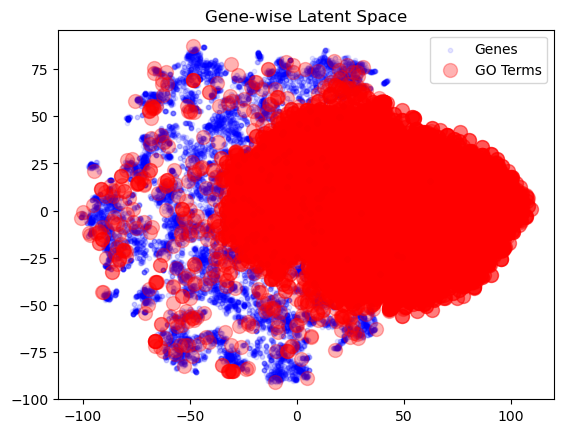

In [233]:
#Training data
plot_embeddings(gene_embeddings[0], go_term_embeddings[0],
               s1=10, s2=100, alpha1=0.1, alpha2=0.3)

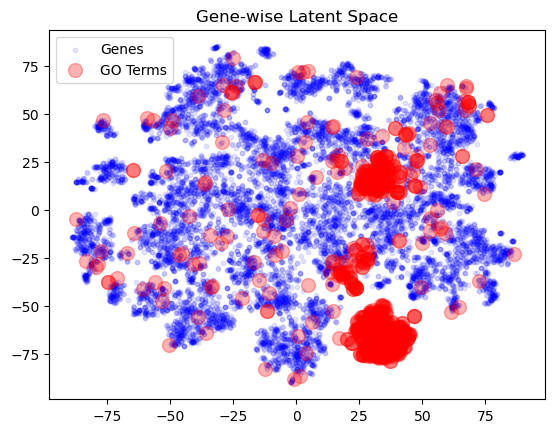

In [235]:

plot_embeddings(gene_embeddings[0], go_term_embeddings[0],
               s1=10, s2=100, alpha1=0.1, alpha2=0.3)

In [251]:
%matplotlib notebook

<IPython.core.display.Javascript object>


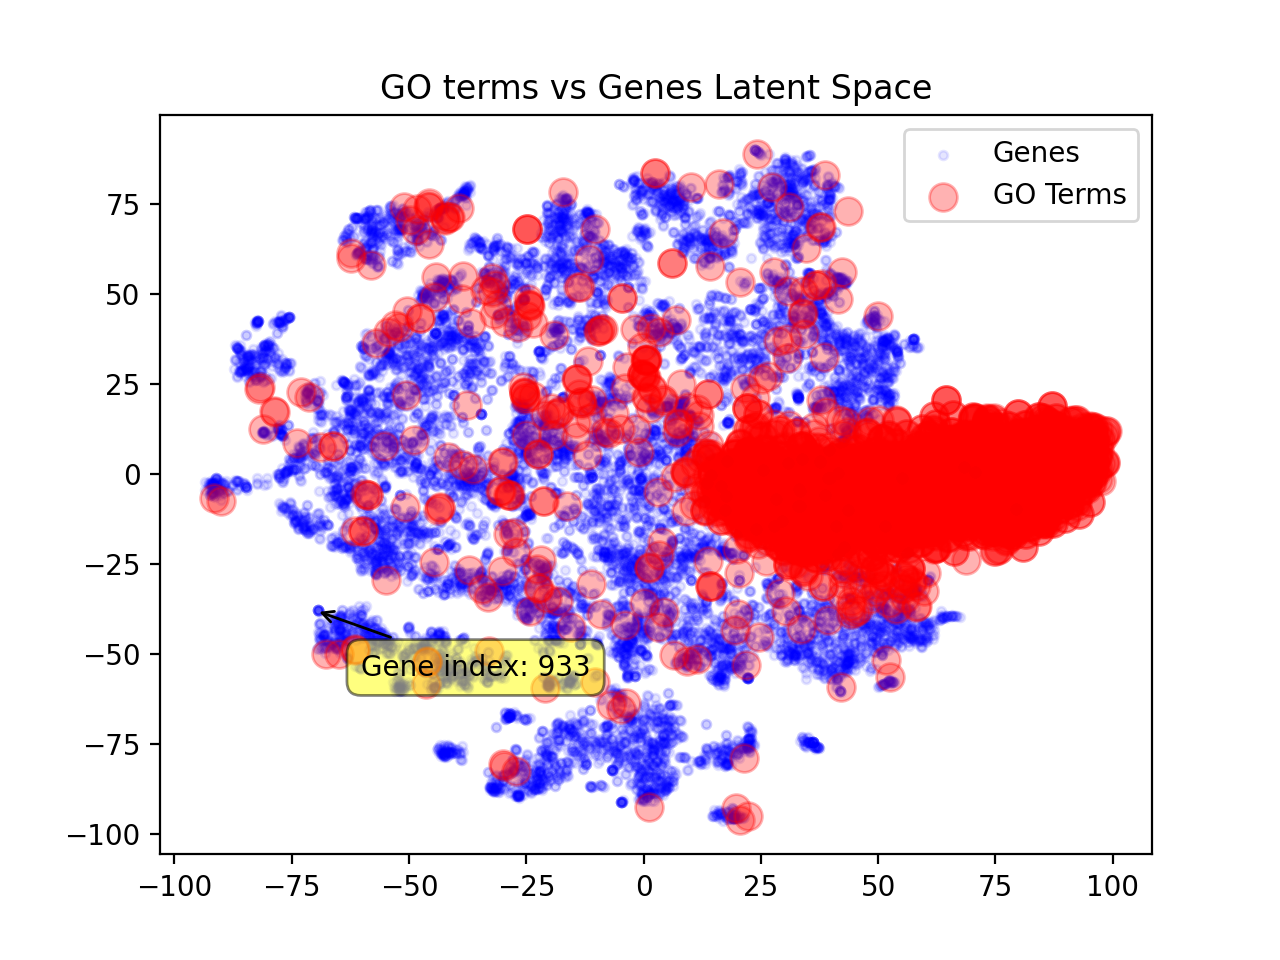

In [269]:
#Test data
plot_embeddings_interactive(gene_embeddings[0], go_term_embeddings[0][:3000], term_text[:3000],
               s1=10, s2=100, alpha1=0.1, alpha2=0.3)

In [58]:
def analyzeOne(gene_embeddings, gene_names, term_embeddings, term_names, relationships, mini = 20):
    
    gene_embeddings_dict = {gname: embed for gname, embed in zip(gene_names, gene_embeddings)}
    term_embeddings_dict = {tname: embed for tname, embed in zip(term_names, term_embeddings)}
    
    belong_similarities =[]
    no_belong_similarities = []
    names = []
    
    for term, t_genes in tqdm(relationships.items()):
        
        if len(t_genes) > mini:
            belong = t_genes
            no_belong = list(set(gene_names) - set(t_genes))

            belong_embedding = np.array([gene_embeddings_dict[g] for g in belong])
            no_belong_embedding = np.array([gene_embeddings_dict[g] for g in no_belong])

            _, bsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], belong_embedding)
            
            _, nsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], no_belong_embedding)
            

            belong_similarities.append(np.squeeze(bsim))
            no_belong_similarities.append(np.squeeze(nsim))
            names.append(term)
            
    return belong_similarities, no_belong_similarities, names
    

In [207]:
gene_names = gene_to_summary.keys()
term_names = go_to_summary.keys()

belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings[0],
                                                         gene_names, go_term_embeddings[0],
                                                         term_names, relationships,
                                                         mini=0
                                                        )


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 2982/2982 [01:31<00:00, 32.59it/s]


In [119]:
len(belong_similarities) , len(no_belong_similarities)

(36, 36)

In [100]:
only_for = ["GO:0000139", "GO:0000981", "GO:0006811", "GO:0031410"]
only_for_indx = [i for i,g in enumerate (index_names) if g in only_for]

only_for_indx, index_names


([0, 2, 8, 11],
 ['GO:0000139',
  'GO:0000166',
  'GO:0000981',
  'GO:0005515',
  'GO:0005524',
  'GO:0005829',
  'GO:0005856',
  'GO:0005886',
  'GO:0006811',
  'GO:0007165',
  'GO:0016301',
  'GO:0031410',
  'GO:0046872'])

In [ ]:
s = len(index_names)

belong_similarities = [belong_similarities[i] 
                       for i in range(s) if i in only_for_indx ]
no_belong_similarities= [no_belong_similarities[i]
                         for i in range(s) if i in only_for_indx ]

index_names = [index_names[i] for i in range(s) if i in only_for_indx ]


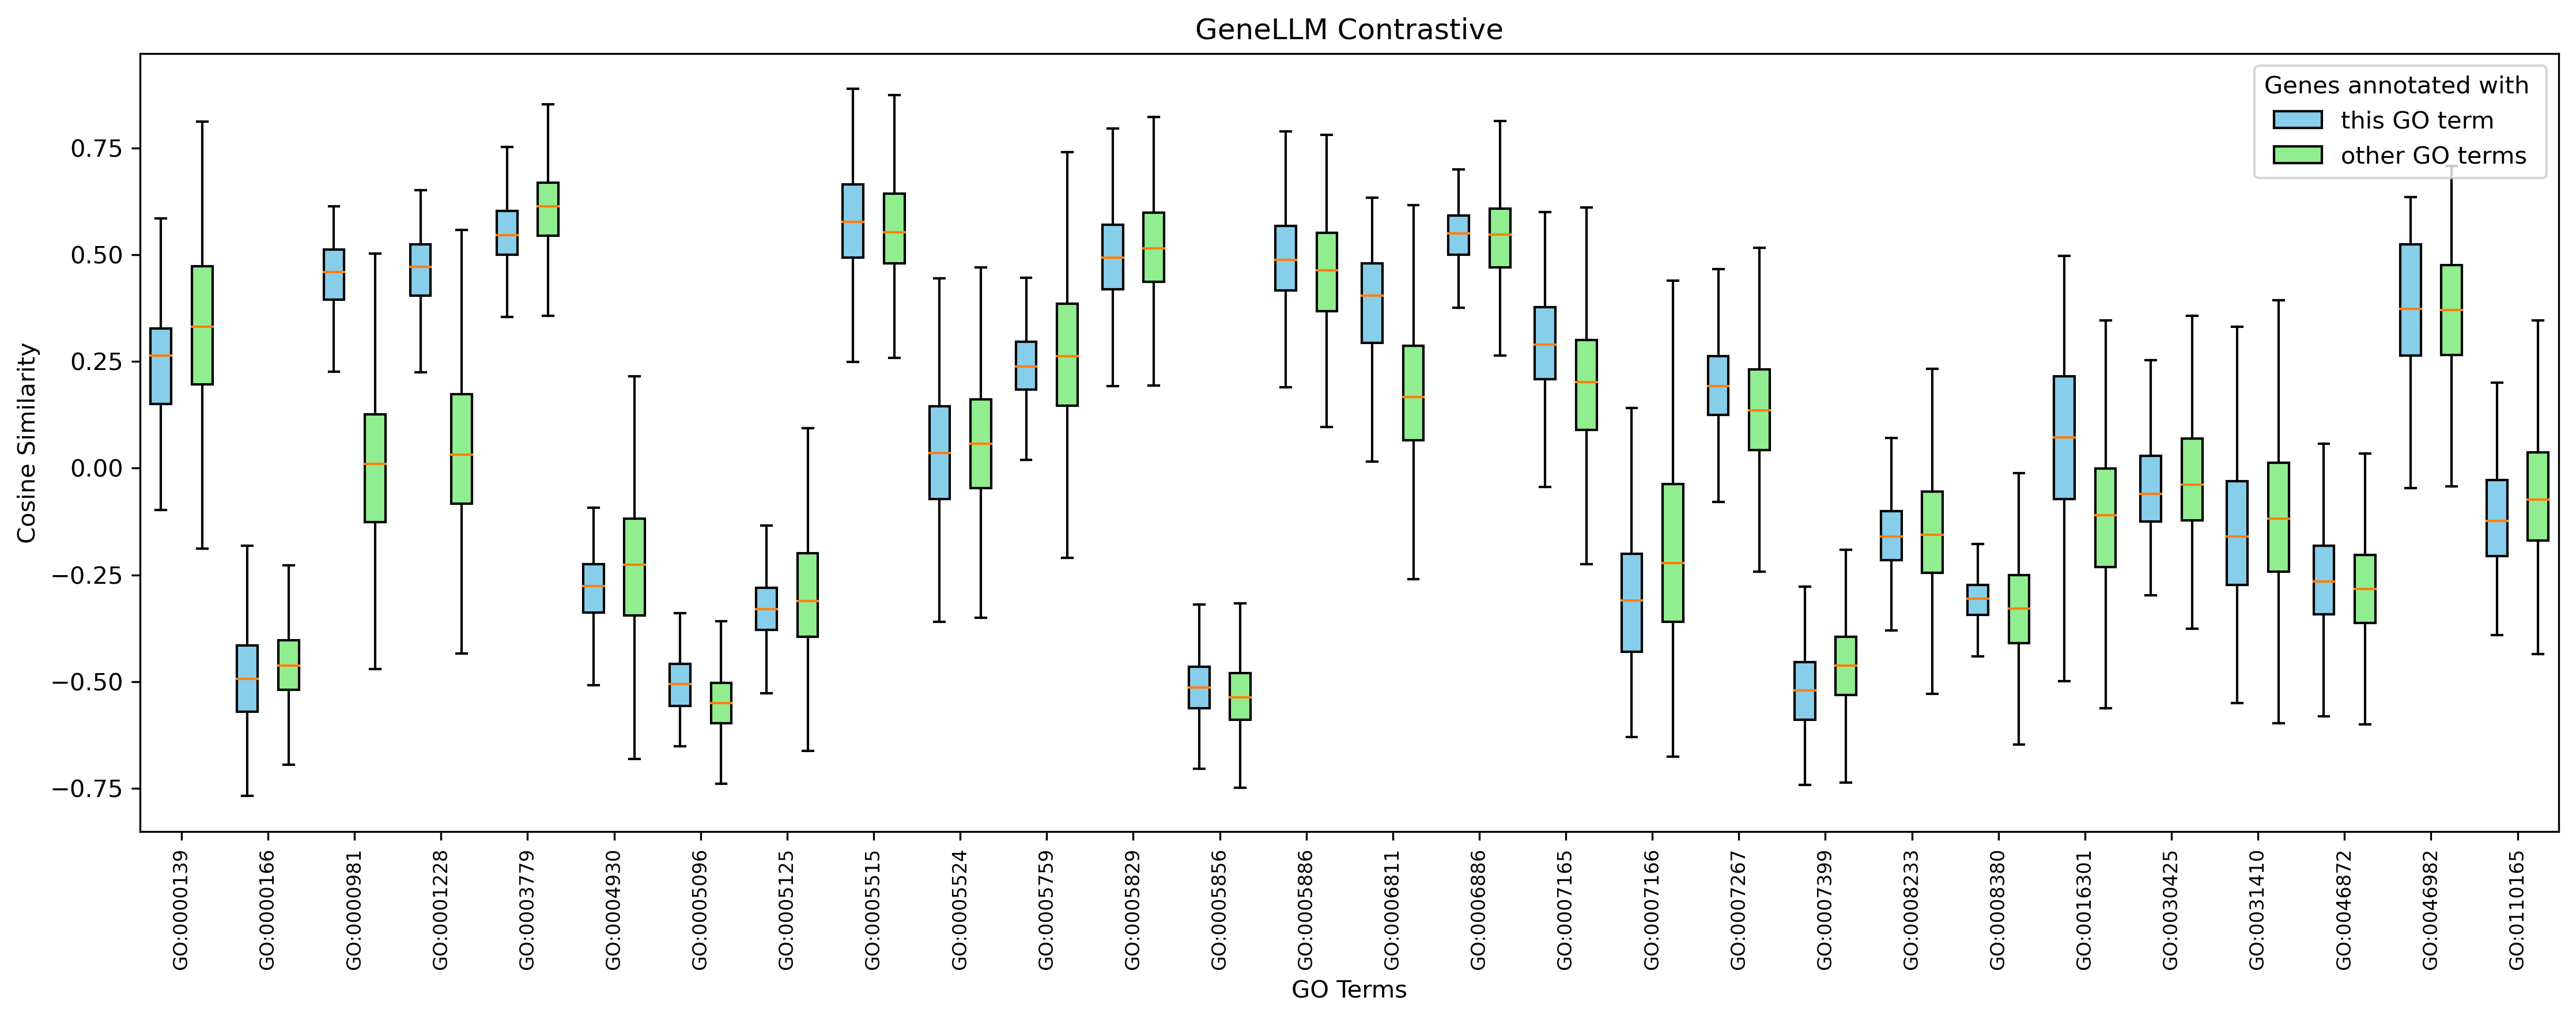

In [183]:

fig, ax = plt.subplots(figsize=(15, 6), dpi=300)


s = len(index_names)

spacing = 0.1  # Additional spacing between pairs
positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

# Box plot for the first 20 of belong_similarities
bp1 = ax.boxplot(belong_similarities,
                 positions=positions_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="skyblue"),
                 showfliers=False)

# Box plot for the first 20 of no_belong_similarities
bp2 = ax.boxplot(no_belong_similarities,
                 positions=positions_no_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="lightgreen"),
                 showfliers=False)

# Adding labels and titles
ax.set_title('GeneLLM Contrastive')
ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
ax.set_xticklabels(index_names, rotation=90, fontsize=8)
ax.set_xlabel('GO Terms')
ax.set_ylabel('Cosine Similarity')

# ax.set_ylim(0.75,1)

# Adding legend
legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this GO term',
                                                        'other GO terms'],
                   loc='best', title='Genes annotated with ')
legend.get_title().set_fontsize('10')  



# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Genes annotated with GO term','Genes annotated with other GO terms'], loc='upper right')

plt.tight_layout()
plt.show()


In [208]:
from scipy import stats


def hr_at_k(belong_similarities, no_belong_similarities):
    
    GO_ranks = []
    for go_sim, go_no_sim in zip(belong_similarities, no_belong_similarities):
    
        if go_sim.ndim == 0 and go_no_sim.ndim == 0 :
            go_sim = np.array([go_sim])
            go_no_sim = np.array([go_no_sim])
            
        elif go_sim.ndim == 0:
            go_sim = np.array([go_sim])
            
        elif go_no_sim.ndim == 0:
            go_no_sim = np.array([go_no_sim])
            
        k = go_sim.shape[0]
        similarities = np.concatenate([go_sim,go_no_sim])
        labels = np.array([1]*go_sim.shape[0] + [0]*go_no_sim.shape[0])
    
    
        sorted_indices = np.argsort(-similarities)
        v = labels[sorted_indices][:k]#.any()
        v = len(v[v == 1])/k
#         v = v#/k
        
#         print(v)
        
        GO_ranks.append(v)
    
    
    return GO_ranks


def mean_rank(belong_similarities, no_belong_similarities):
        
    GO_ranks = []
    for go_sim, go_no_sim in zip(belong_similarities, no_belong_similarities):
    
        if go_sim.ndim == 0 and go_no_sim.ndim == 0 :
            go_sim = np.array([go_sim])
            go_no_sim = np.array([go_no_sim])
            
        elif go_sim.ndim == 0:
            go_sim = np.array([go_sim])
            
        elif go_no_sim.ndim == 0:
            go_no_sim = np.array([go_no_sim])
            
            
        similarities = np.concatenate([go_sim,go_no_sim])
        labels = np.array([1]*go_sim.shape[0] + [0]*go_no_sim.shape[0])
            
        
        ranks = stats.rankdata(-similarities, method='average')  # Negative for descending order

        relevant_ranks = ranks[labels == 1]


        GO_ranks.append(np.mean(relevant_ranks))
        
    return np.log(GO_ranks)

In [209]:
ranks = hr_at_k(belong_similarities, no_belong_similarities)
np.mean(ranks)

0.0029175404910852347

In [210]:
ranks = mean_rank(belong_similarities, no_belong_similarities)
ranks.mean()

8.513362322854137

In [ ]:
#Look at training data
#Fix k
#sort once


# pickles/BestModel.pkl:
    #log mean_rank: 8.513
    #hr@k: 0.00291


# Base
    #log mean_rank:    6.83
    #hr@k : 0.044

# Old CL
    #log mean_rank:    5.4
    #hr@k : 0.14


In [86]:
index_names

['GO:0000139',
 'GO:0000166',
 'GO:0000981',
 'GO:0005515',
 'GO:0005524',
 'GO:0005829',
 'GO:0005856',
 'GO:0005886',
 'GO:0006811',
 'GO:0007165',
 'GO:0016301',
 'GO:0031410',
 'GO:0046872']

## Bias analysis

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd


relevance_scores =[]
for k in [5,10,50,100,200,350]:
    print(k)
    print("-"*60)
    
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    held_out_set = pd.read_csv("/home/tailab/LitGene/data/zero-shot/held_out_set.csv")
    relationships = held_out_set.groupby("GO Term")['Gene name'].apply(set).to_dict()
    
    trim_GO = lambda summary, n=10: ' '.join(summary.split()[:n])
    
    GO_summary_df = held_out_set#.set_index("GO Term")["Term Summary"]
    GO_summary_df["Term Summary"] = GO_summary_df["Term Summary"].apply(lambda s: trim_GO(s,k))
    
    go_to_summary = GO_summary_df.set_index('GO Term')['Term Summary'].to_dict()
    
    
    
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
    gene_names = gene_to_summary.keys()
    go_names = go_to_summary.keys()


    gene_text= list(gene_to_summary.values())
    go_text= list(go_to_summary.values()) 
    text = gene_text + go_text

    
#     with open( f"zero-shot/KEGG/{k}/model_{str(0)}.pkl", 'rb') as file:
#         loaded_model = pickle.load(file)
    
    loaded_model = torch.load(f"zero-shot/state_dict_0.pth")
    
    embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()

    gene_embeddings = embed[:len(gene_text)] 
    go_embeddings = embed[len(gene_text):]


    belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings,
                                                                          gene_names, go_embeddings,
                                                                          go_names, relationships,
                                                                          mini=0)

    lst = relevance_differences(belong_similarities, no_belong_similarities)
    relevance_scores.append(lst)
    

In [ ]:
# fig, ax = plt.subplots(figsize=(15, 6), dpi=300)

s = len(belong_similarities)
spacing = 0.7  # Additional spacing between pairs
positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

# Box plot for the first 20 of belong_similarities
bp1 = ax.boxplot(belong_similarities,
                 positions=positions_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="skyblue"),
                 showfliers=False)

# Box plot for the first 20 of no_belong_similarities
bp2 = ax.boxplot(no_belong_similarities,
                 positions=positions_no_belong,
                 patch_artist=True,
                 boxprops=dict(facecolor="lightgreen"),
                 showfliers=False)

# Adding labels and titles
ax.set_title('GeneLLM Contrastive')
ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
ax.set_xticklabels(index_names, rotation=90, fontsize=8)
ax.set_xlabel('GO Terms')
ax.set_ylabel('Cosine Similarity')

# Adding legend
legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this GO term',
                                                        'other GO terms'],
                   loc='upper right', title='Genes annotated with ')
legend.get_title().set_fontsize('10')  



# ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['Genes annotated with GO term','Genes annotated with other GO terms'], loc='upper right')

plt.tight_layout()
plt.show()


In [8]:
def zero_shot_learning(go_term_embeddings, gene_embeddings, threshold=0.5):
    """
    Determines if genes belong to GO terms using zero-shot learning based on cosine similarity, 
    without explicit for loops.

    Args:
    - go_term_embeddings (array): Array of embeddings for GO terms.
    - gene_embeddings (array): Array of embeddings for genes.
    - threshold (float): The threshold for deciding if a gene belongs to a GO term.

    Returns:
    - distances (array): Array of cosine similarity values between each gene and GO term pair.
    - predictions (array): Array of predictions (0 or 1) indicating whether the gene belongs to the GO term.
    """
    
    go_term_norms = np.linalg.norm(go_term_embeddings, axis=1, keepdims=True)
    gene_norms = np.linalg.norm(gene_embeddings, axis=1, keepdims=True)
    
    normalized_go_terms = go_term_embeddings / go_term_norms
    normalized_genes = gene_embeddings / gene_norms


    distances = pairwise_distances(normalized_genes, normalized_go_terms, metric='cosine')
    similarities = 1 - distances


    #include all negative genes 
    #calculate AUC per go term where distances as your predictions. 
    #box plot
    
    
    
    predictions = (similarities >= threshold).astype(int)#.numpy()
#     print(predictions)

    
    labels = np.ones(predictions.shape)
    accuracy = accuracy_score(labels, predictions)
    
    return distances, similarities, predictions, accuracy

def analyzeOne(gene_embeddings, gene_names, term_embeddings, term_names, relationships, mini = 20):
    
    gene_embeddings_dict = {gname: embed for gname, embed in zip(gene_names, gene_embeddings)}
    term_embeddings_dict = {tname: embed for tname, embed in zip(term_names, term_embeddings)}
    
    belong_similarities =[]
    no_belong_similarities = []
    names = []
    
    for term, t_genes in tqdm(relationships.items()):
        
        if len(t_genes) > mini:
            belong = t_genes
            no_belong = list(set(gene_names) - set(t_genes))

            belong_embedding = np.array([gene_embeddings_dict[g] for g in belong])
            no_belong_embedding = np.array([gene_embeddings_dict[g] for g in no_belong])

            _, bsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], belong_embedding)
            
            _, nsim, _, _ = zero_shot_learning([term_embeddings_dict[term]], no_belong_embedding)
            

            belong_similarities.append(np.squeeze(bsim))
            no_belong_similarities.append(np.squeeze(nsim))
            names.append(term)
            
    return belong_similarities, no_belong_similarities, names
 
def relevance_differences(belong_similarities, no_belong_similarities):
    
    s=len(belong_similarities)
    return [np.mean(belong_similarities[i]) - np.mean(no_belong_similarities[i]) for i in range(s)]

def plot_zero_shot_sim(gene_embedding,gene_names,
                       kegg_embedding, kegg_names,
                       relationships, mini=0,
                       title = "GeneLLM",
                       ylim = [0,1]
                      ):

    fig, ax = plt.subplots(figsize=(15, 6), dpi=600)


    belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embedding,
                                                                          gene_names, 
                                                                          kegg_embedding,
                                                                          kegg_names,
                                                                          relationships,
                                                                          mini=0)
    
    s = len(belong_similarities)
    spacing = 0.7  
    positions_belong = [i * (2 + spacing) for i in range(s)]  # Adjusted even positions
    positions_no_belong = [i * (2 + spacing) + 1 for i in range(s)]  # Adjusted odd positions

    # Box plot for the first 20 of belong_similarities
    bp1 = ax.boxplot(belong_similarities[:s],
                     positions=positions_belong,
                     patch_artist=True,
                     boxprops=dict(facecolor="#FF7F50"),
                     showfliers=False)

    # Box plot for the first 20 of no_belong_similarities
    bp2 = ax.boxplot(no_belong_similarities[:s],
                     positions=positions_no_belong,
                     patch_artist=True,
                     boxprops=dict(facecolor="#DDA0DD"),
                     showfliers=False)

    # Adding labels and titles
    #'Predicting KEGG pathways from GeneLLM trained on GO terms'
    ax.set_title(title)
    ax.set_xticks([(a + b) / 2 for a, b in zip(positions_belong, positions_no_belong)])
    ax.set_xticklabels(index_names[:s], rotation=90, fontsize=8)
    ax.set_xlabel('KEGG Pathways')
    ax.set_ylabel('Cosine Similarity')

    # Adding legend
    legend = ax.legend([bp1["boxes"][0], bp2["boxes"][0]], ['this pathway',
                                                            'other pathways'],
                       loc='upper right', bbox_to_anchor=(1.15, 1), title='Genes annotated with ')

    legend.get_title().set_fontsize('10')  


    if ylim is not None:
        ax.set_ylim(ylim[0], ylim[1])

    plt.tight_layout()
    plt.show()


# Extract KEGG

In [1]:
import pandas as pd

{'FES': 'This gene encodes the human cellular counterpart of a feline sarcoma retrovirus protein with transforming capabilities. The gene product has tyrosinespecific protein kinase activity and that activity is required for maintenance of cellular transformation. Its chromosomal location has linked it to a specific translocation event identified in patients with acute promyelocytic leukemia but it is also involved in normal hematopoiesis as well as growth factor and cytokine receptor signaling. Alternative splicing results in multiple variants encoding different isoforms. Tyrosineprotein kinase that acts downstream of cell surface receptors and plays a role in the regulation of the actin cytoskeleton, microtubule assembly, cell attachment and cell spreading. Plays a role in FCER1 (high affinity immunoglobulin epsilon receptor)mediated signaling in mast cells. Acts downstream of the activated FCER1 receptor and the mast/stem cell growth factor receptor KIT. Plays a role in the regulati

In [10]:
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()
df_relation = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_genes.tsv', sep='\t').dropna(subset=["id", "Genes"])
df_relation["Genes"] = df_relation["Genes"].apply(lambda g: g.split(";"))

kegg_summary_dict = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                              sep='\t', header=None).set_index('id')['Summary'].to_dict()

all_genes = genes["Gene name"].to_list()

df_relation['Genes'] = df_relation['Genes'].apply(lambda genes:[gene for gene in genes if gene in all_genes])

df_relation['Gene Summary'] = df_relation['Genes'].apply(lambda genes:[gene_to_summary.get(g, None) for g in genes ])

df_relation['KEGG Summary'] = df_relation["id"].apply(lambda i: kegg_summary_dict.get(i, None) )
df_relation = df_relation.dropna(subset=["id", "Genes", 'KEGG Summary'])

df_relation

,Term,id,Genes,Gene Summary,KEGG Summary
0,Bile secretion Homo sapiens,map04976,"[ABCC2, SLC22A1, ATP1A4, ATP1A3, ATP1A2, SLC51...",[The protein encoded by this gene is a member ...,"Bile is a vital secretion, essential for diges..."
1,Glycosylphosphatidylinositol(GPI)-anchor biosy...,map00563,"[PIGS, PIGB, PIGT, GPAA1, PIGK, PIGM, PIGG, PI...",[This gene encodes a protein that is involved ...,Cell surface proteins can be attached to the c...
3,Taste transduction Homo sapiens,map04742,"[HTR1F, HTR3E, HTR1D, HTR3C, HTR1A, HTR3D, TAS...",[Enables G proteincoupled serotonin receptor a...,Five basic tastes are recognized by humans and...
4,Salivary secretion Homo sapiens,map04970,"[ATP1A4, ATP1A3, ATP1A2, LPO, CST4, HTN3, CST3...",[The protein encoded by this gene belongs to t...,Saliva has manifold functions in maintaining t...
5,Proximal tubule bicarbonate reclamation Homo s...,map04964,"[SLC9A3, GLUD2, ATP1A4, ATP1A3, ATP1A2, SLC4A4...",[The protein encoded by this gene is an epithe...,One of the major tasks of the renal proximal t...
...,...,...,...,...,...
258,Ribosome biogenesis in eukaryotes Homo sapiens,map03008,[XRN1],[This gene encodes a member of the 5'3' exonuc...,Ribosomes are the cellular factories responsib...
259,GnRH signaling pathway Homo sapiens,map04912,[ADCY9],[Adenylate cyclase is a membrane bound enzyme ...,Gonadotropin-releasing hormone (GnRH) secretio...
260,Melanogenesis Homo sapiens,map04916,[ADCY9],[Adenylate cyclase is a membrane bound enzyme ...,Cutaneous melanin pigment plays a critical rol...
261,Alcoholism Homo sapiens,map05034,"[DRD2, SLC6A3]",[This gene encodes the D2 subtype of the dopam...,"Alcoholism, also called dependence on alcohol ..."


In [15]:
df_relation.to_csv("/home/tailab/LitGene/data/zero-shot/KEGG/kegg_genes_relationships.csv", index=False)

In [ ]:
    
    
    

    kegg_summary_dict = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                                  sep='\t', header=None).set_index('id')['Summary'].to_dict()

    all_genes = genes["Gene name"].to_list()



    df_relation['Genes'] = df_relation['Genes'].apply(lambda genes:[gene for gene in genes if gene in all_genes])
    df_relation['KEGG Summary'] = df_relation["id"].apply(lambda i: kegg_summary_dict.get(i, None) )
    df_relation = df_relation.dropna(subset=["id", "Genes", 'KEGG Summary'])

    trim_KEGG = lambda summary, n=0: ' '.join(summary.split()[:n])
    df_relation["KEGG Summary"] = df_relation["KEGG Summary"].apply(lambda s: trim_KEGG(s,k))


    relationships = df_relation.set_index('id')['Genes'].to_dict()



    kegg_to_summary = df_relation.set_index('id')["KEGG Summary"].to_dict()
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()


    gene_names = gene_to_summary.keys()
    kegg_names = kegg_to_summary.keys()


    gene_text= list(gene_to_summary.values())
    kegg_text= list(kegg_to_summary.values()) 
    text = gene_text + kegg_text


    loaded_model = torch.load(f"zero-shot/state_dict_{str(0)}.pth")
    embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()

    gene_embeddings = embed[:len(gene_text)] 
    kegg_embeddings = embed[len(gene_text):]
    
    
    belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings,
                                                                      gene_names, kegg_embeddings,
                                                                      kegg_names, relationships,
                                                                      mini=0)


    
    lst = relevance_differences(belong_similarities, no_belong_similarities)
    relevance_scores.append(lst)


In [16]:
relevance_scores = []

for k in [5,10,15,50,100,150, 200, 250, 350]:
    genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
    df_relation = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_genes.tsv', sep='\t').dropna(subset=["id", "Genes"])
    df_relation["Genes"] = df_relation["Genes"].apply(lambda g: g.split(";"))

    kegg_summary_dict = pd.read_csv('/home/tailab/LitGene/data/zero-shot/KEGG/kegg_pathways_summary.tsv', names=['id', 'Summary'],
                                  sep='\t', header=None).set_index('id')['Summary'].to_dict()

    all_genes = genes["Gene name"].to_list()



    df_relation['Genes'] = df_relation['Genes'].apply(lambda genes:[gene for gene in genes if gene in all_genes])
    df_relation['KEGG Summary'] = df_relation["id"].apply(lambda i: kegg_summary_dict.get(i, None) )
    df_relation = df_relation.dropna(subset=["id", "Genes", 'KEGG Summary'])

    trim_KEGG = lambda summary, n=0: ' '.join(summary.split()[:n])
    df_relation["KEGG Summary"] = df_relation["KEGG Summary"].apply(lambda s: trim_KEGG(s,k))


    relationships = df_relation.set_index('id')['Genes'].to_dict()



    kegg_to_summary = df_relation.set_index('id')["KEGG Summary"].to_dict()
    gene_to_summary = genes.set_index('Gene name')['Summary'].to_dict()


    gene_names = gene_to_summary.keys()
    kegg_names = kegg_to_summary.keys()


    gene_text= list(gene_to_summary.values())
    kegg_text= list(kegg_to_summary.values()) 
    text = gene_text + kegg_text


    loaded_model = torch.load(f"zero-shot/state_dict_{str(0)}.pth")
    embed = getEmbeddings(text, loaded_model, batch_size=2000).detach().cpu().numpy()

    gene_embeddings = embed[:len(gene_text)] 
    kegg_embeddings = embed[len(gene_text):]
    
    
    belong_similarities, no_belong_similarities, index_names = analyzeOne(gene_embeddings,
                                                                      gene_names, kegg_embeddings,
                                                                      kegg_names, relationships,
                                                                      mini=0)


    
    lst = relevance_differences(belong_similarities, no_belong_similarities)
    relevance_scores.append(lst)


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.75s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 27.39it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.77s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 27.51it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.76s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 26.67it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.82s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 26.77it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.80s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 26.31it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.82s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 26.72it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.82s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 27.24it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.81s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 28.16it/s]


Loading a pretrained model from a state dictionary ...
Tokenization ...
Tokenization Done.
Get Embeddings ...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:46<00:00,  5.78s/it]


torch.Size([14655, 768])


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 205/205 [00:07<00:00, 29.15it/s]


In [15]:
len(sum(list(relationships.values()), []))

1140

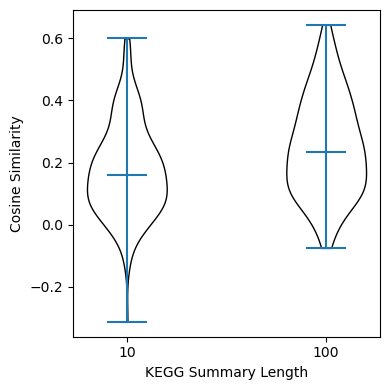

In [59]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=100)


positions = [0, 0.05] 
parts = ax.violinplot([relevance_scores[1], relevance_scores[4]],
                      widths=0.02, showmeans=False,
                      showmedians=True,
                      positions=positions,
                      showextrema=True)

# Change color to dark green for each part of the violin plot
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

# ax.set_title('Relevance Scores of genes to KEGG pathways')
ax.set_ylabel('Cosine Similarity')
ax.set_xlabel('KEGG Summary Length')

# Set x-tick labels
ax.set_xticks(positions)
# ax.set_xticks(list(range(1,3)))  # Adjust the number of ticks based on your data
# ax.set_xticklabels([5,10,15,50,100,150, 200, 250, 350])
ax.set_xticklabels([10,100])

plt.tight_layout()
plt.show()


In [62]:
relevance_scores = np.array(relevance_scores)

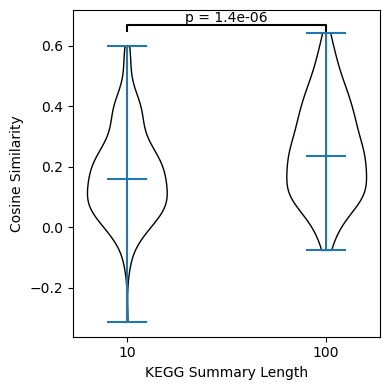

In [74]:
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
import numpy as np

# Assuming relevance_scores is defined and has the appropriate data
# Perform the Wilcoxon rank-sum test
stat, p_value = mannwhitneyu(relevance_scores[1], relevance_scores[4])

# Now let's plot the violin plot with the p-value

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4), dpi=100)

positions = [0, 0.05] 
parts = ax.violinplot([relevance_scores[1], relevance_scores[4]],
                      widths=0.02, showmeans=False,
                      showmedians=True,
                      positions=positions,
                      showextrema=True)

# Change color for each part of the violin plot
for pc in parts['bodies']:
    pc.set_facecolor('white')
    pc.set_edgecolor('black')
    pc.set_alpha(1)

ax.set_ylabel('Cosine Similarity')
ax.set_xlabel('KEGG Summary Length')

# Set x-tick labels
ax.set_xticks(positions)
ax.set_xticklabels([10,100])

# Annotate the plot with the p-value
x1, x2 = positions   # the x locations for the two distributions
y, h, col = relevance_scores[1].max() + 0.05, 0.02, 'black'
ax.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
ax.text((x1+x2)*.5, y+h, f"p = {p_value:.1e}", ha='center', va='bottom', color=col)

plt.tight_layout()
plt.show()


In [65]:
p_value <0.01

True

# Adding Contrastive Learning: Unspuervised

In [ ]:
genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
# genes['num_words'] = genes['Summary'].apply(lambda x: len(str(x).split()))
# genes = genes[genes['num_words'] < 100]
genes

In [ ]:
go_terms = pd.read_csv("/home/tailab/LitGene/data/Contrastive/go_terms.csv")
go_terms

In [ ]:
interaction_data = pd.read_csv("/home/tailab/LitGene/data/Contrastive/gene_interaction.csv")
interaction_data

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

contrastive_flag = False
margin = 2
alpha=0.5

epochs =5
lr = 1e-5
pool ="mean"
max_length = 500
batch_size = 30
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = "unsupervised"
n_labels = 1
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# model_name='kamalkraj/BioSimCSE-BioLinkBERT-BASE'

train_loader, val_loader, test_loader= process_triplet_data(interaction_data, max_length=max_length,
                                                            batch_size=batch_size,
                                                            test_split_size=0.3,
                                                            gene2vec_flag = gene2vec_flag,
                                                            model_name= model_name)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

interaction_model, history, labels_test, best_pred = trainer(epochs, train_loader, val_loader,
                                             test_loader, lr =lr, pool= pool, max_length= max_length,
                                             batch_size = batch_size, drop_rate =drop_rate,
                                             gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden,
                                             device = device, task_type = task_type,
                                             n_labels = n_labels, model_name= model_name, class_map = None,
                                            contrastive_flag = contrastive_flag, alpha =alpha,margin = margin)


In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

contrastive_flag = False
margin = 2
alpha=0.5

epochs =5
lr = 1e-5
pool ="mean"
max_length = 500
batch_size = 30
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = False
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = "unsupervised"
n_labels = 1
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

train_loader, val_loader, test_loader= process_triplet_data(go_terms, max_length=max_length,
                                                            batch_size=batch_size,
                                                            test_split_size=0.3,
                                                            gene2vec_flag = gene2vec_flag,
                                                            model_name= model_name)

print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

go_terms_model, history, labels_test, best_pred = trainer(epochs, train_loader, val_loader,
                                             test_loader, lr =lr, pool= pool, max_length= max_length,
                                             batch_size = batch_size, drop_rate =drop_rate,
                                             gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden,
                                             device = device, task_type = task_type,
                                             n_labels = n_labels, model_name= model_name, class_map = None,
                                            contrastive_flag = contrastive_flag, alpha =alpha,margin = margin)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
import json


def analyze_embeddings(models, names = ["base", "interaction", "go_terms"]):
    
    paths = ["BivalentVsLys4","BivalentVsNonMethylated", "DosageSensitivity",
             "solubility", "Tf_range", "TF_target_type", "localization"]

    results = {name:{p:dict() for p in paths} for name in names}
    
    
    for model, name in zip(models, names):
        
        
        genes = pd.read_csv("/home/tailab/LitGene/data/clean_genes.csv")
        summaries = genes["Summary"].to_list()
        gene_list= genes["Gene name"].to_list()
        
        if name == "gene2vec":
            genes_to_embeddings = dict()

            with open('data/gene2vec_embeddings.txt', 'r') as file:
                for line in file:
                    g_name, g_embed = line.strip().split("	")
                    g_embed = [float(value) for value in g_embed.split()] 

                    genes_to_embeddings[g_name.strip()] = g_embed            
            
        else:
            embeddings = getEmbeddings(summaries, model = model )        
            embeddings = embeddings.detach().cpu().numpy()
            genes_to_embeddings = {k:v for k,v in zip(gene_list,embeddings )}
            
            
        
        for dataset in paths:
            print(f"Running model:{name}, on dataset: {dataset}")
            print()
            
            df = pd.read_csv(f"data/test_data/{dataset}.csv")[["Gene name","Label"]]
            df["Embedding"]= df["Gene name"].apply(lambda g: genes_to_embeddings.get(g, None) )
            df = df.dropna().sample(frac=1).reset_index(drop=True)
            

            X = np.array(df["Embedding"].to_list())
            y = np.array(df["Label"].to_list())
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
            
            classifiers = [LogisticRegression(), LinearSVC(),
                           SVC(kernel='linear'), Perceptron(), 
                           SGDClassifier()]
            
            classifiers_name = ["LR", "LinearSVC", "SVC", "Perceptron", "SGD"]
            
            for classifier, cls_name in zip(classifiers, classifiers_name) :
                
                classifier.fit(X_train, y_train)
                y_pred = classifier.predict(X_test)
                
                acc = accuracy_score(y_test, y_pred)
                f1 = f1_score(y_test, y_pred, average='weighted')
                
                results[name][dataset][cls_name]= [acc, f1]
                
                with open("data/test_data/results.json", 'w') as json_file:
                    json.dump(results, json_file)
                
                
                print(f"{name}, {dataset},{cls_name} :{[acc, f1]} ")
    print("-"*90)
                
                
    return results


In [ ]:

res = analyze_embeddings(["gene2vec", None, interaction_model, go_terms_model],
                         names = [ "gene2vec" , "base","interaction", "go_terms"])



In [ ]:
res.keys()

In [ ]:
def retrieve_task(task_name, ret= "accuracy"):
    to_send = dict()
    for model_name in res.keys(): #['gene2vec', 'base', 'interaction', 'go_terms']
        to_send[model_name] = dict()
        
        for classifier in res[model_name][task_name].keys():
            
            if ret == "accuracy":
                to_send[model_name][classifier] = res[model_name][task_name][classifier][0]
            else:
                to_send[model_name][classifier] = res[model_name][task_name][classifier][1]
    return to_send
        

    
    
import matplotlib.pyplot as plt

def plot_linear_classifiers(data, title, margin_between_bars=0.01, text_size=7):
    
    groups = ['Gene2Vec', 'GeneLLM (base)',
                        'GeneLLM (Interaction)', 'GeneLLM (GO terms)'] 
    
    embedding_models = list(data.keys())
    print(embedding_models)

    
    classifiers = list(data[embedding_models[0]].keys())
    accuracy_values = [[data[model][classifier] for classifier in classifiers] for model in embedding_models]

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.15
    opacity = 0.8
    index = range(len(embedding_models))

    for i, classifier in enumerate(classifiers):
        bars = plt.bar([pos + i * (bar_width + margin_between_bars) for pos in index],
                       [values[i] for values in accuracy_values],
                       bar_width, alpha=opacity, label=classifier)

        # Label each bar with its value
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width() / 2, yval, round(yval, 2), ha='center', va='bottom', size=text_size)

    plt.xlabel('Embedding Models')
    plt.ylabel('F1')
    plt.title(title)
    plt.xticks([pos + (len(classifiers) - 1) * (bar_width + margin_between_bars) / 2 for pos in index],
               groups, rotation=0 )#rotation='vertical')

    # Move legend outside the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


In [ ]:
tasks = list(res["gene2vec"].keys())

In [ ]:
tasks = list(res["gene2vec"].keys())
for t in tasks:
    plot_linear_classifiers(retrieve_task(t, ret="F1"), f'F1 Scores on {t} Task')
    
    

In [ ]:
def plot_embeddings(model=None, title = "", color = "b"):
    
    
    
    genes = pd.read_csv("data/clean_genes.csv")
    summaries = genes["Summary"].to_list()
    gene_list= genes["Gene name"].to_list()

    if name.lower() == "gene2vec":
        embeddings = []

        with open('data/gene2vec_embeddings.txt', 'r') as file:
            for line in file:
                g_name, g_embed = line.strip().split("	")
                g_embed = [float(value) for value in g_embed.split()] 

                embeddings.append(g_embed)
        embeddings = np.array(embeddings)
    else:
        embeddings = getEmbeddings(summaries, model = model )        
        embeddings = embeddings.detach().cpu().numpy()
    

    gene_2d = TSNE(n_components=2).fit_transform(embeddings)
    
    plt.scatter(gene_2d[:, 0], gene_2d[:, 1], c=color, s=30, alpha=0.2, label ="Genes")
    
    plt.title(title)
    plt.show()

In [ ]:
names = ['Gene2Vec', 'GeneLLM (base)', 'GeneLLM (Interaction)', 'GeneLLM (GO terms)'] 
models = ["gene2vec", None, interaction_model, go_terms_model]
colors = ["b","g","r","y"]

for model, name,c in zip(models,names, colors):
    plot_embeddings(model, title = name, color = c)
    
    

# Adding Contrastive Learning: Localization

### Second-Stage training

In [ ]:
#genes = pd.read_csv("data/genes_clean.csv")
genes = pd.read_csv("/mnt/data/macaulay/GeneLLM2/data/genes.csv")
genes['num_words'] = genes['Summary'].apply(lambda x: len(str(x).split()))
genes = genes[genes['num_words'] < 100]


loc = pd.read_csv('data/final_subcellular_location_class.csv')[["0","Y"]]
labels_dict = loc.set_index("0")["Y"].to_dict()


genes["StrLabel"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
genes = genes.dropna(subset=["StrLabel"]).reset_index(drop=True)
genes["Label"] = genes["StrLabel"].apply(lambda l:  {'Cytoplasm': 0, 'Nucleus': 1, 'Cell membrane': 2}[l])

genes


In [ ]:
label_counts = genes['StrLabel'].value_counts()

# Create a pie chart
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)

# Set the title
plt.title(f'Distribution of {sum(label_counts)} Labels')
plt.show()

In [ ]:
#####################################################################################
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
    
# X_train, y_train = indx_to_triplet(ind_train, model_name = "gene2vec")
# X_test, y_test_g2v = indx_to_triplet(ind_test, model_name = "gene2vec")

y_train = []
for ex in train_loader.dataset:
    y_train.append(int(ex[3]))
    
    
y_test = []
for ex in val_loader.dataset:
    y_test.append(int(ex[3]))
    
# train_genes= genes.loc[indx]

# indx = []
# for ex in val_loader.dataset:#[1000]
#     indx.append(int(ex[3]))
    
# test_genes= genes.loc[indx]


# y_train=train_genes.Label.to_list()
# y_test=test_genes.Label.to_list()

X_train = getEmbeddingsWithGene2Vec(train_loader,contrastive_model)
X_test = getEmbeddingsWithGene2Vec(val_loader,contrastive_model)

X_train = X_train.detach().cpu().numpy()
X_test = X_test.detach().cpu().numpy()

# scaler = StandardScaler().fit(X_train)

# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

classifier = LogisticRegression()
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')


print(f"Accuracy: {acc}")
print(f"F1: {f1}")

## Only BERT Loss as second stage

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

contrastive_flag = True
margin = 1
alpha=0.1
epochs = 6
lr = 2e-5
pool ="mean"
max_length = 150
batch_size = 50
drop_rate = 0.1
gene2vec_hidden = 200
gene2vec_flag = True
device =  torch.device("cuda" if torch.cuda.is_available() else "cpu")
task_type = "classification"
n_labels = 3
model_name= "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
# model_name='michiyasunaga/BioLinkBERT-base'
# model_name='kamalkraj/BioSimCSE-BioLinkBERT-BASE'



# genes = pd.read_csv("/mnt/data/macaulay/GeneLLM2/data/genes.csv")

# genes['num_words'] = genes['Summary'].apply(lambda x: len(str(x).split()))
# genes = genes[genes['num_words'] < 150]

# loc = pd.read_csv('data/final_subcellular_location_class.csv')[["0","Y"]]
# labels_dict = loc.set_index("0")["Y"].to_dict()

# genes["StrLabel"] = genes["Gene name"].apply(lambda name: labels_dict.get(name,None))
# genes = genes.dropna(subset=["StrLabel"]).reset_index(drop=True)




# train_loader, val_loader, test_loader = process_data(genes, max_length, batch_size,
#                                                      gene2vec_flag = gene2vec_flag,
#                                                      model_name = model_name)



# loc = pd.read_csv('data/final_subcellular_location_class.csv')[["0","Y"]]
# labels_dict = loc.set_index("0")["Y"].to_dict()


# triplet_df["StrLabel"] = triplet_df["Gene name"].apply(lambda name: labels_dict.get(name,None))
# triplet_df = triplet_df.dropna(subset=["StrLabel"]).sample(frac=1).reset_index(drop=True)
# triplet_df["Label"] = triplet_df["StrLabel"].apply(lambda l:  {'Cytoplasm': 0, 'Nucleus': 1, 'Cell membrane': 2}[l])



# genes = pd.read_csv("data/genes_clean.csv")
# loc = pd.read_csv('data/final_subcellular_location_class.csv')[["0","Y"]]

# genes = genes[genes['Gene name'].isin(loc["0"].to_list())]




genes = pd.read_csv("//home/tailab/LitGene/data/genes.csv")

genes['num_words'] = genes['Summary'].apply(lambda x: len(str(x).split()))
genes = genes[genes['num_words'] > 150]

loc = pd.read_csv('data/final_subcellular_location_class.csv')[["0","Y"]]
labels_dict = loc.set_index("0")["Y"].to_dict()


triplet_df, go_terms_df, class_map = from_obo_to_triplet(genes, triplet="gene-wise", level = 3)

triplet_df["StrLabel"] = triplet_df["Gene name"].apply(lambda name: labels_dict.get(name,None))
triplet_df = triplet_df.dropna(subset=["StrLabel"]).sample(frac=1).reset_index(drop=True)
triplet_df["Label"] = triplet_df["StrLabel"].apply(lambda l:  {'Cytoplasm': 0, 'Nucleus': 1, 'Cell membrane': 2}[l])



train_loader, val_loader, test_loader= process_triplet_data(triplet_df, max_length=max_length,
                                                            batch_size=batch_size,
                                                            test_split_size=0.3, 
                                                            gene2vec_flag = gene2vec_flag,
                                                            model_name= model_name)


(best_model, history, labels_test, best_pred)= trainer(epochs, train_loader, test_loader, val_loader,
            lr =lr, pool= pool, max_length= max_length,
            batch_size = batch_size, drop_rate =drop_rate,
            gene2vec_flag = gene2vec_flag, gene2vec_hidden = gene2vec_hidden,
            device = device, task_type = task_type,
            n_labels = n_labels, model_name= model_name, class_map = class_map,
            load_model = None, contrastive_flag = contrastive_flag,
           alpha =alpha, margin = margin)


In [ ]:
genes = pd.read_csv("/home/tailab/LitGene/data/genes_clean.csv")
loc = pd.read_csv('/home/tailab/LitGene/data/final_subcellular_location_class.csv')[["0","Y"]]

genes = genes[genes['Gene name'].isin(loc["0"].to_list())]

triplet_df, go_terms_df, class_map = from_obo_to_triplet(genes, triplet="gene-wise", level = 3)

labels_dict = loc.set_index("0")["Y"].to_dict()


triplet_df["StrLabel"] = triplet_df["Gene name"].apply(lambda name: labels_dict.get(name,None))
triplet_df = triplet_df.dropna(subset=["StrLabel"]).reset_index(drop=True)
triplet_df["Label"] = triplet_df["StrLabel"].apply(lambda l:  {'Cytoplasm': 0, 'Nucleus': 1, 'Cell membrane': 2}[l])

triplet_df
